In [1]:
#using POMDPs
using Plots
using DifferentialEquations
using DataStructures
using ProfileView
using POMDPs
using Distributions: Normal
using Random
import POMDPs: initialstate_distribution, actions, gen, discount, isterminal
#Random.seed!(1);
using POMDPs, POMDPModels, POMDPSimulators, ARDESPOT, POMDPModelTools, POMDPPolicies, BasicPOMCP
using ParticleFilters

Gtk-Message: 18:14:33.810: Failed to load module "canberra-gtk-module"
Gtk-Message: 18:14:33.811: Failed to load module "canberra-gtk-module"


In [2]:
#Global Variables
plot_size = 800; #number of pixels
cart_size = 1; # radius in meters

In [3]:
struct location
    x::Float64
    y::Float64
    id::Float64
end

mutable struct human_state
    x::Float64
    y::Float64
    v::Float64
    goal::location
end

struct obstacle_location
    x::Float64
    y::Float64
    r::Float64 #Radius of the obstacle which is assumed to be a circle
end

mutable struct cart_state
    x::Float64
    y::Float64
    theta::Float64
    v::Float64
    L::Float64
    goal::location
end

In [4]:
mutable struct experiment_environment 
    length::Float64
    breadth::Float64
    num_humans::Int64
    goals::Array{location}
    humans::Array{human_state}
    obstacles::Array{obstacle_location}
    cart::cart_state
    end

In [1]:
function Base.show(io::IO, mime::MIME, env::experiment_environment)
    
    #Plot Boundaries
    p = plot([0.0],[0.0],legend=false,grid=false)
    plot!([env.length], [env.breadth],legend=false)
    
    #Plot Humans
    for i in 1: length(env.humans)
        scatter!([env.humans[i].x], [env.humans[i].y],color="red",msize=plot_size/env.length)
    end
    
    #Plot Obstacles
    for i in 1: length(env.obstacles)
        scatter!([env.obstacles[i].x], [env.obstacles[i].y],color="black",shape=:circle,msize=plot_size*env.obstacles[i].r/env.length)
    end
    
    #Plot Golfcart
    scatter!([env.cart.x], [env.cart.y], shape=:sq, color="blue", msize= plot_size*cart_size/env.length)
    
    plot!(size=(plot_size,plot_size))
    show(io, mime, p)
end

UndefVarError: UndefVarError: experiment_environment not defined

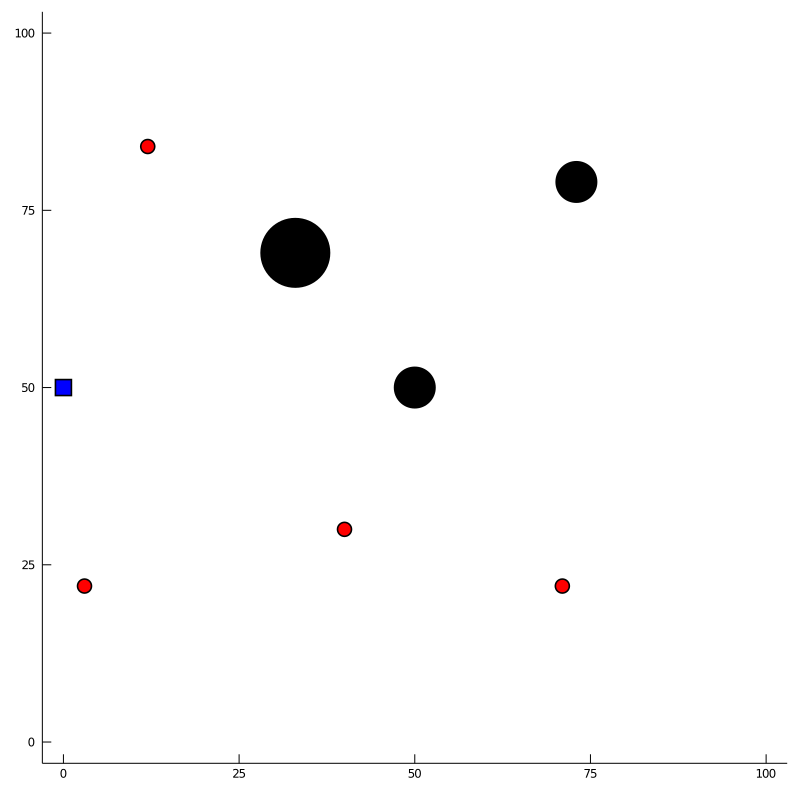

In [6]:
g1 = location(0,0,1)
g2 = location(0,100,2)
g3 = location(0,30,3)
g4 = location(14,1,4)
cart_goal = location(100,50,5)
all_goals_list = [g1,g2,g3,g4]

h1 = human_state(40,30,1,g3)
h2 = human_state(3,22,1,g4)
h3 = human_state(71,22,1,g2)
h4 = human_state(12,84,1,g1)
human_state_start_list = [h1,h2,h3,h4]

o1 = obstacle_location(50,50,3)
o2 = obstacle_location(33,69,5)
o3 = obstacle_location(73,79,3)
all_obstacle_list = [o1,o2,o3]

golfcart = cart_state(0,50,0,1,1,cart_goal)

env = experiment_environment(100.0,100.0,4,all_goals_list,human_state_start_list,all_obstacle_list,golfcart)

In [7]:
#Integration

function wrap_between_0_and_2Pi(theta)
   return mod(theta,2*pi) 
end

function travel!(du,u,p,t)
    x,y,theta = u
    v,L,alpha = p 
    
    du[1] = v*cos(theta)
    du[2] = v*sin(theta)
    du[3] = (v/L)*tan(alpha)
end

function get_intermediate_points(initial_state, time_interval, extra_parameters)
    prob = ODEProblem(travel!,initial_state,time_interval,extra_parameters)
    sol = DifferentialEquations.solve(prob,saveat=0.1)
    x = []
    y = []
    theta = []
    
    for i in 1:length(sol.u)
        push!(x,sol.u[i][1])
        push!(y,sol.u[i][2])
        push!(theta,wrap_between_0_and_2Pi(sol.u[i][3]))
    end
    
    return x,y,theta
end

# x_init = 0.0;
# y_init = 50.0;
# theta_init = -pi/6;
# cart_current_speed = 1.0
# cart_length = 1.0
# steering_angle = -pi/10

# initial_state = [x_init,y_init,theta_init]
# extra_parameters = [cart_current_speed, cart_length, steering_angle]
# time_interval = (0.0,1.0)

# x,y,theta = get_intermediate_points(initial_state, time_interval, extra_parameters);
# theta

In [8]:
mutable struct graph_node
    x::Float64
    y::Float64
    theta::Float64
    actual_cost::Float64
    heuristic_cost::Float64
    action_taken_to_reach_here::Float64
    discrete_x::Float64
    discrete_y::Float64
    discrete_theta::Float64
    parent::Any
end

In [9]:
function is_goal(node, goal_x, goal_y, threshold)
    euclidean_distance =  ( (node.x - goal_x)^2 + (node.y - goal_y)^2 )^ 0.5
    if(euclidean_distance < threshold)
        return true
    else
        return false
    end
end

function calculate_heuristic_cost(node_x, node_y, goal_x, goal_y)
    euclidean_distance =  ( (node_x - goal_x)^2 + (node_y - goal_y)^2 )^ 0.5
    return euclidean_distance
end

function get_path(current_node)
    steering_angle_controls_sequence = [] 
    @show(current_node.actual_cost)
    while(current_node!= nothing)
        push!(steering_angle_controls_sequence, current_node.action_taken_to_reach_here)
        current_node = current_node.parent
    end
    return reverse(steering_angle_controls_sequence)
end     

function get_new_x_y_theta(current_x, current_y, current_theta, steering_angle,time_interval, env, arc_length)
    if(steering_angle == 0.0)
        new_theta = current_theta
        new_x = current_x + arc_length*cos(current_theta)*time_interval
        new_y = current_y + arc_length*sin(current_theta)*time_interval
    else
        new_theta = current_theta + (arc_length * tan(steering_angle) * time_interval / env.cart.L)
        new_theta = wrap_between_0_and_2Pi(new_theta)

        new_x = current_x + ((env.cart.L / tan(steering_angle)) * (sin(new_theta) - sin(current_theta)))
        new_y = current_y + ((env.cart.L / tan(steering_angle)) * (cos(current_theta) - cos(new_theta)))
    end
    return float(new_x), float(new_y), float(new_theta)
end

function get_discrete_state(environment, x, y, theta)
    discretization_width = 0.5
    discretization_width_theta = pi/18
    max_num_bins_x = ceil(environment.length/discretization_width)
    discrete_x = clamp(ceil(x/discretization_width),1,max_num_bins_x)
    max_num_bins_y = ceil(environment.breadth/discretization_width)
    discrete_y = clamp(ceil(y/discretization_width),1,max_num_bins_y)
    max_num_bins_theta = ceil(2*pi/discretization_width_theta)
    discrete_theta = clamp(ceil(theta/discretization_width_theta),1,max_num_bins_theta)
    return discrete_x::Float64,discrete_y::Float64,discrete_theta::Float64 
end

function get_action_cost(environment, final_x::Float64, final_y::Float64, discrete_x::Float64, discrete_y::Float64, obs_thresold::Float64, hum_threshold::Float64, action::Float64)
    total_cost::Float64 = 0.0

    #Cost from going out of bounds
    if(final_x<=0.0 || final_x>=env.length)
        return Inf
    end
    if(final_y<=0.0 || final_y>=env.breadth)
        return Inf
    end

    #Cost from obstacles
    for obstacle in environment.obstacles
        euclidean_distance::Float64 = ( (final_x - obstacle.x)^2 + (final_y - obstacle.y)^2 )^ 0.5
        if(euclidean_distance >= obstacle.r + 5)
            continue
        elseif(euclidean_distance <= obstacle.r)
            total_cost = Inf
        else
            distance_between_cart_and_obstacle = euclidean_distance - obstacle.r
            total_cost += obs_thresold* (5 - distance_between_cart_and_obstacle) 
        end
    end

    #Cost from humans
    for human in environment.humans
        euclidean_distance::Float64 = ( (final_x - human.x)^2 + (final_y - human.y)^2 )^ 0.5
        if(euclidean_distance >= 1 + 5)
            continue
        elseif(euclidean_distance <= 1)
            total_cost = Inf
        else
            total_cost += hum_threshold * (5 + 1 - euclidean_distance) 
        end
    end

    #Cost from no change in steering angle 
    if(action == 0.0)
       total_cost += -0.1 
    end
    #Cost from Long Paths
    total_cost += 1

    return total_cost

end

function hybrid_a_star_search(start_x, start_y, start_theta, goal_x, goal_y, env)
    
    #Action Set
    #set_of_steering_angles = [0,+pi/12,-pi/12,+pi/6,-pi/6]
    set_of_steering_angles = [0.0]
    for i in (1:18)
        push!(set_of_steering_angles, (i*pi/180))
        push!(set_of_steering_angles, (-i*pi/180))
    end
    #delta_t = 1 second
    time_step = 1
    #Radius of circle around goal = 1m
    radius_around_goal_threshold = 1.0
    #Obstacle collision threshold
    obstacle_collision_threshold = 10.0
    #Human collision threshold
    human_collision_threshold = 10.0
    #Distance covered in one time interval
    arc_length = 1.0

    open = PriorityQueue(Base.Order.Forward);
    closed = Dict()
    dict_of_nodes = Dict()
    start_theta = wrap_between_0_and_2Pi(start_theta)
    start_discrete_x, start_discrete_y, start_discrete_theta = get_discrete_state(env,start_x,start_y,start_theta)
    
    start_node = graph_node(start_x, start_y, start_theta, 0, 
        calculate_heuristic_cost(start_x,start_y,goal_x,goal_y), 0, start_discrete_x, start_discrete_y, start_discrete_theta,nothing)
    

    node_key = string("x"*string(start_node.discrete_x)*"y"*string(start_node.discrete_y)*"theta"*string(start_node.discrete_theta))
    open[node_key] = start_node.actual_cost + start_node.heuristic_cost
    dict_of_nodes[node_key] = start_node
    
    while(length(open) != 0)
        current_node::graph_node = dict_of_nodes[dequeue!(open)]
        if(is_goal(current_node, goal_x, goal_y, radius_around_goal_threshold))
            path = get_path(current_node)
            return path
        end
        node_key = string("x"*string(current_node.discrete_x)*"y"*string(current_node.discrete_y)*"theta"*string(current_node.discrete_theta))
        closed[node_key] = current_node
        for steering_angle in set_of_steering_angles
            final_x::Float64,final_y::Float64,final_theta::Float64 = get_new_x_y_theta(current_node.x, current_node.y, current_node.theta, steering_angle, time_step, env, arc_length)
            discrete_x, discrete_y, discrete_theta = get_discrete_state(env,final_x,final_y,final_theta)
            node_key = string("x"*string(discrete_x)*"y"*string(discrete_y)*"theta"*string(discrete_theta))
            if(haskey(closed,node_key))
                continue
            end
            g = current_node.actual_cost + get_action_cost(env, final_x, final_y, discrete_x, discrete_y, obstacle_collision_threshold, human_collision_threshold, steering_angle)
            h = calculate_heuristic_cost(final_x, final_y, goal_x, goal_y)
            new_node = graph_node(final_x, final_y, final_theta, g, h, 
                steering_angle, discrete_x, discrete_y, discrete_theta, current_node)

            if(new_node.actual_cost == Inf)
                closed[node_key] = new_node
                continue
            end
            if(haskey(open,node_key))
                if(dict_of_nodes[node_key].actual_cost > new_node.actual_cost)
                    dict_of_nodes[node_key] = new_node
                    open[node_key] = new_node.heuristic_cost + new_node.actual_cost
                end
            else
                dict_of_nodes[node_key] = new_node
                open[node_key] = new_node.heuristic_cost + new_node.actual_cost
            end
        end
            
    end
    
    return nothing
    
end

#@code_warntype hybrid_a_star_search(x_init, y_init, theta_init, 100.0, 100.0, env);

In [10]:
x_init = 10.0;
y_init = 10.0;
theta_init = pi/6;
cart_current_speed = 1.0
cart_length = 1.0
time_interval = (0.0,1.0)

(0.0, 1.0)

In [13]:
@time returned_path = hybrid_a_star_search(x_init, y_init, theta_init, 100.0, 100.0, env);
length(returned_path)
#@profview hybrid_a_star_search(x_init, y_init, theta_init, 90, 10, env)

current_node.actual_cost = 121.60000000000026
  0.168874 seconds (1.66 M allocations: 75.390 MiB)


135

In [14]:
initial_state = [x_init,y_init,theta_init]
path_x, path_y, path_theta = [x_init],[y_init],[theta_init]
for steering_angle in returned_path
    extra_parameters = [cart_current_speed, cart_length, steering_angle]
    x,y,theta = get_intermediate_points(initial_state, time_interval, extra_parameters);
#     for i in 2:length(x)
#         push!(path_x,x[i])
#         push!(path_y,y[i])
#         push!(path_theta,theta[i])
#     end
    push!(path_x,last(x))
    push!(path_y,last(y))
    push!(path_theta,last(theta))
    initial_state = [last(x),last(y),last(theta)]
end

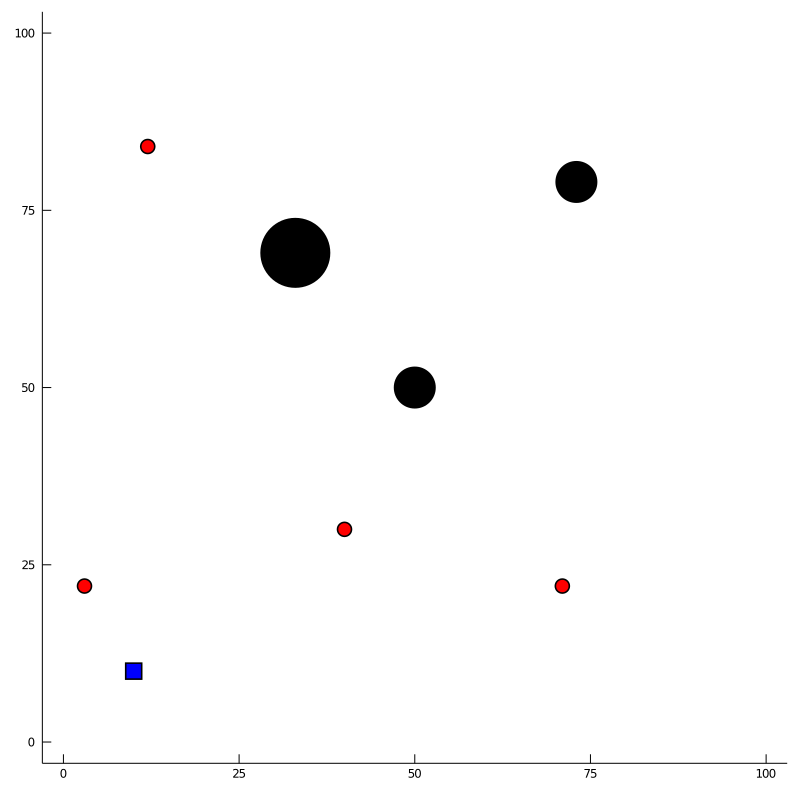

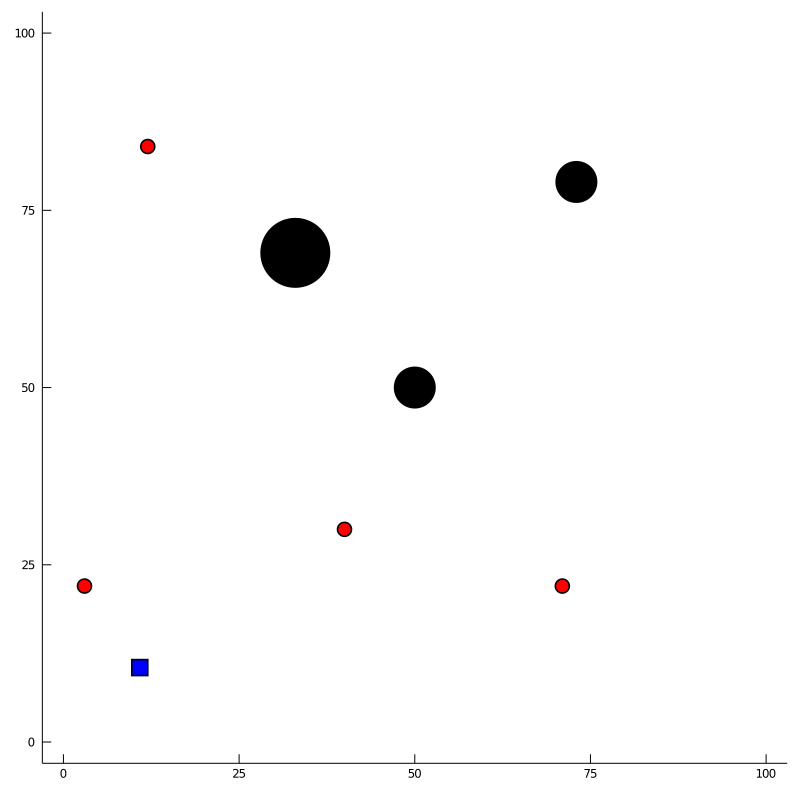

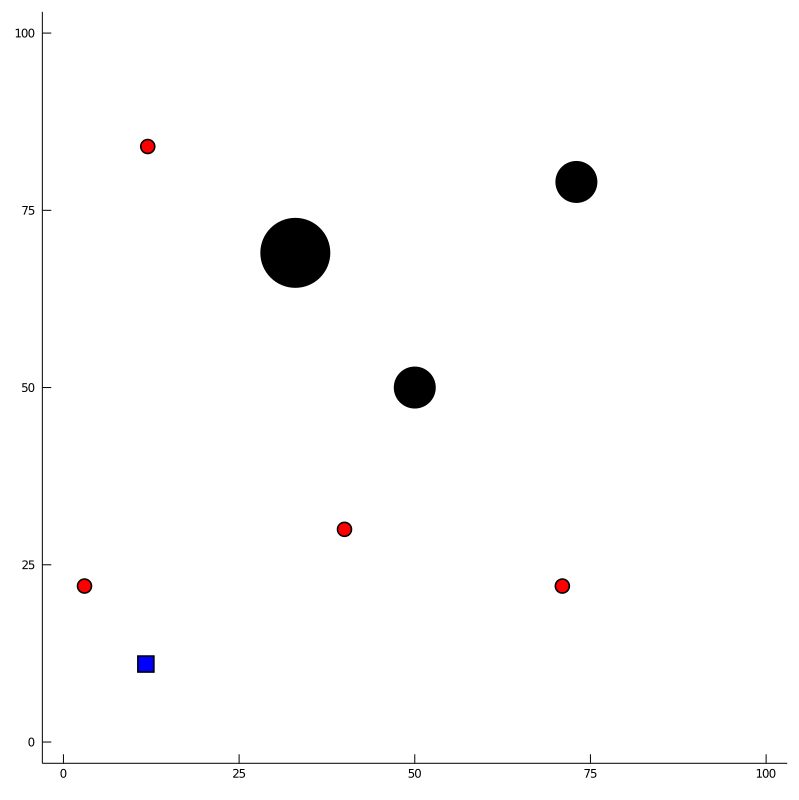

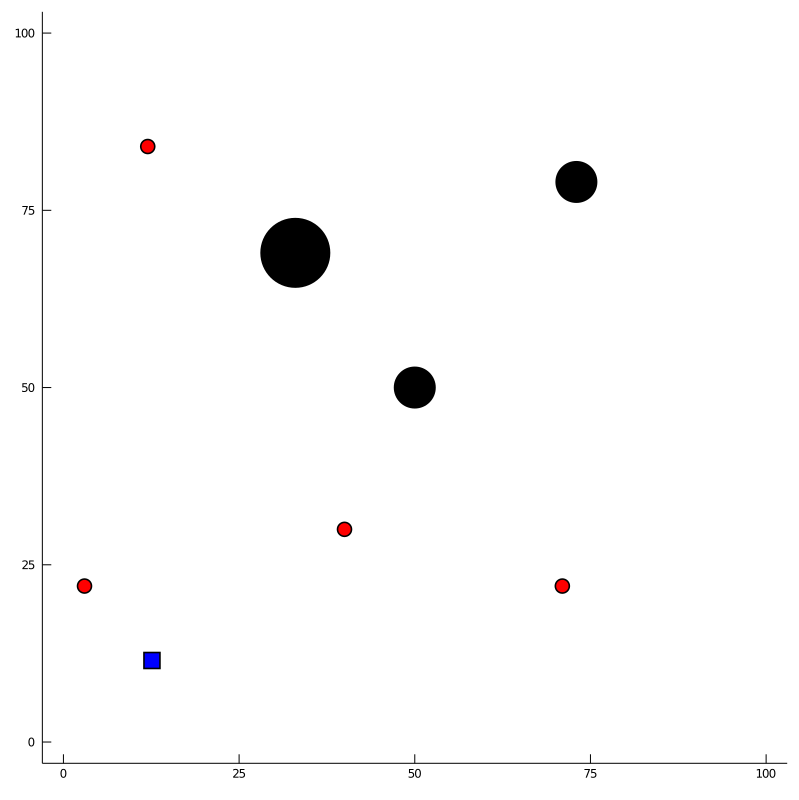

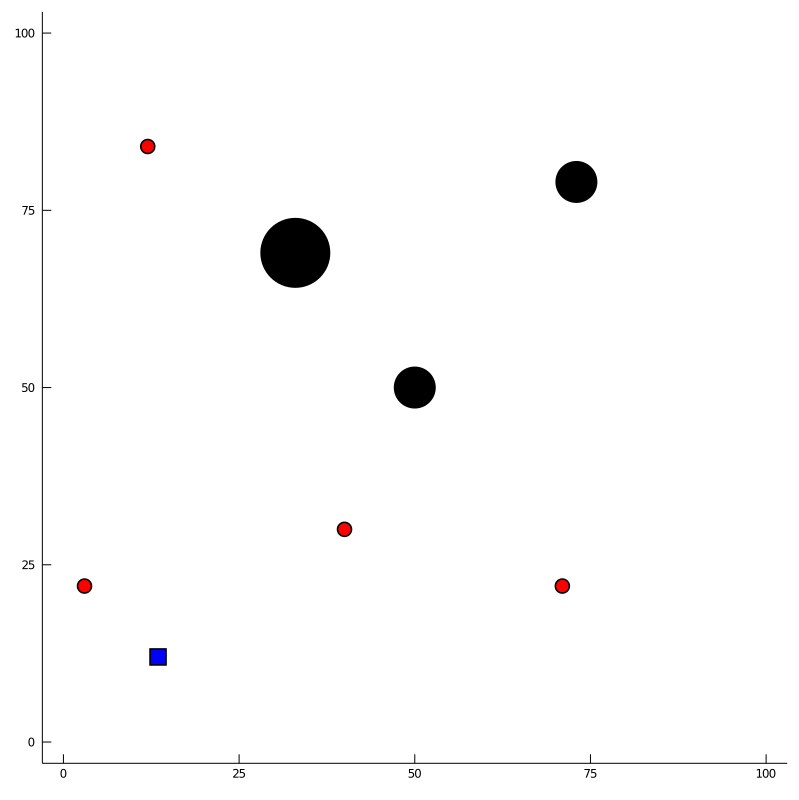

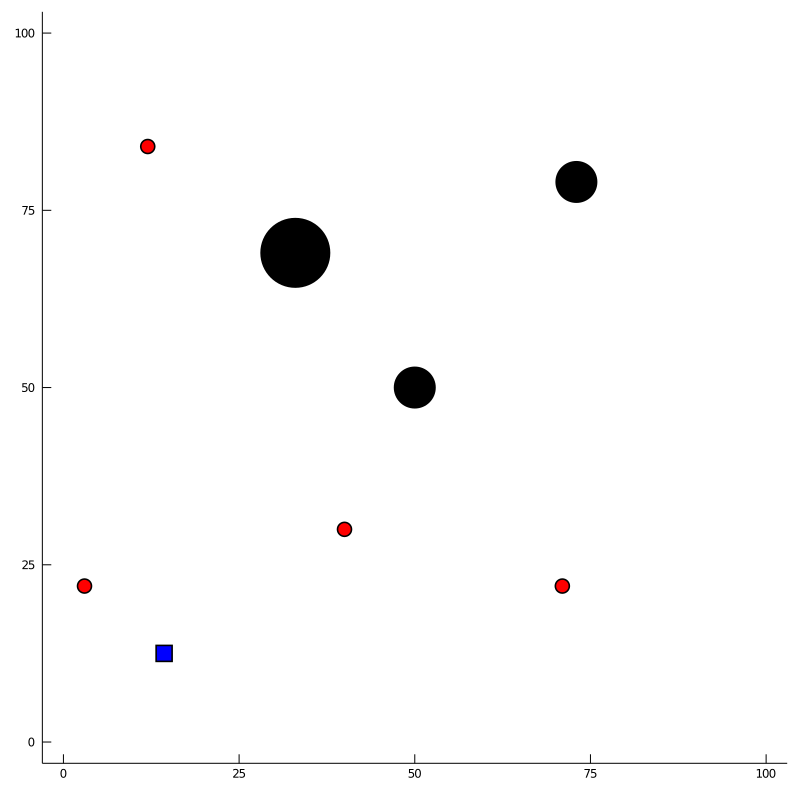

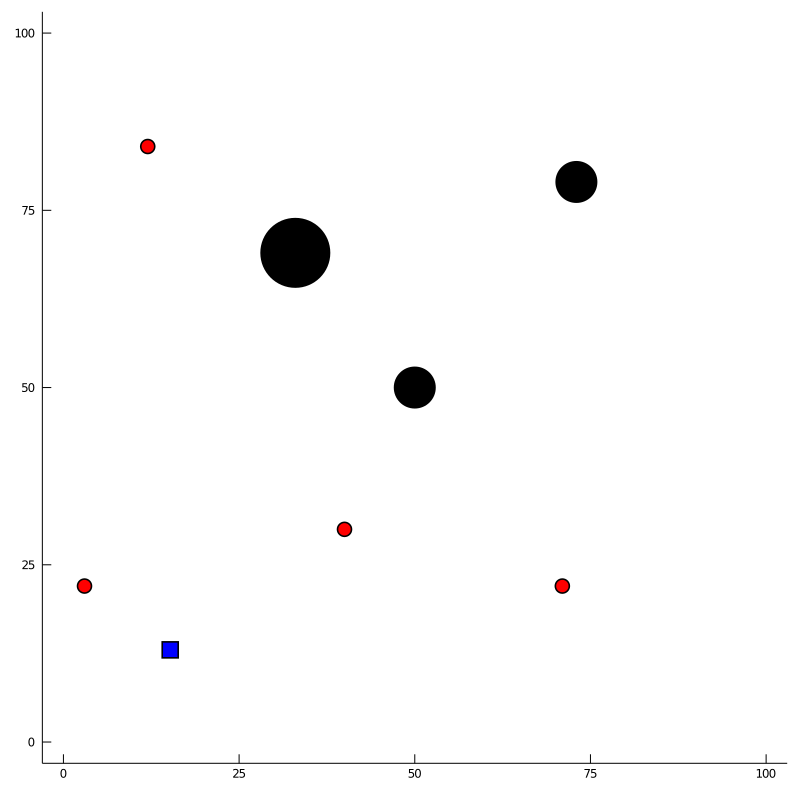

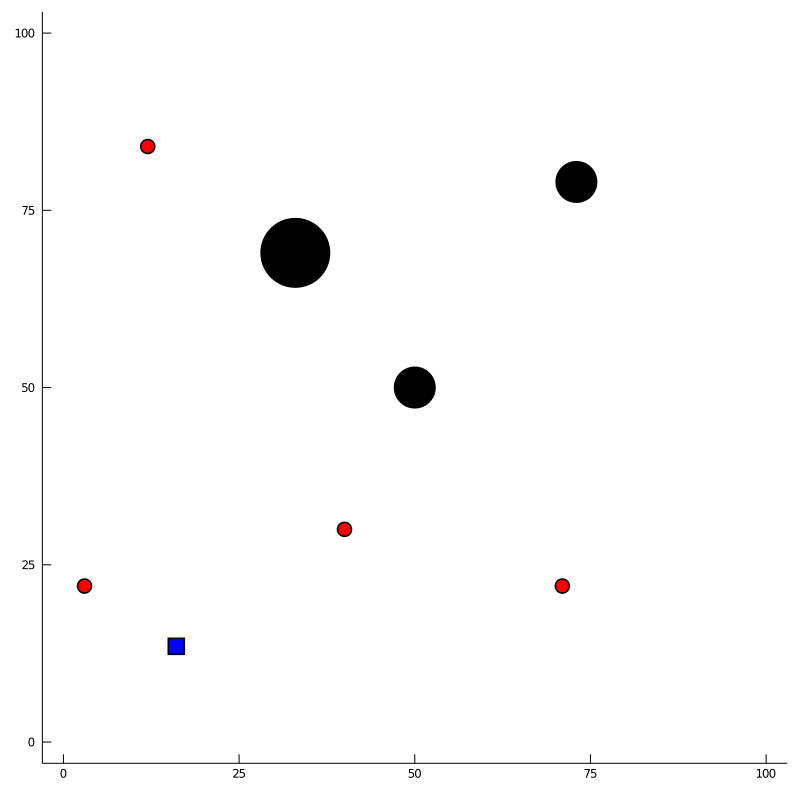

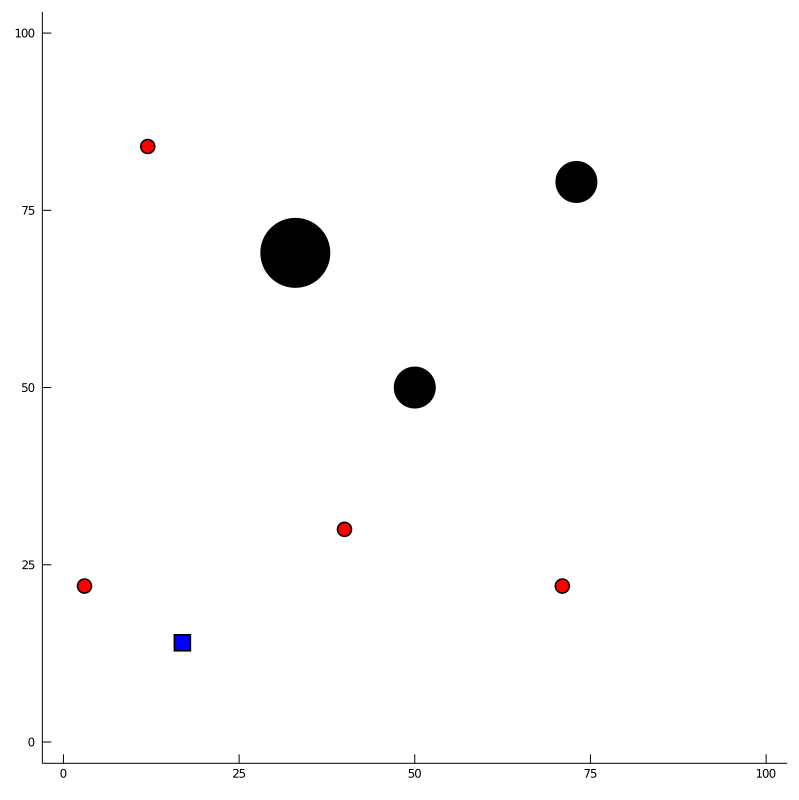

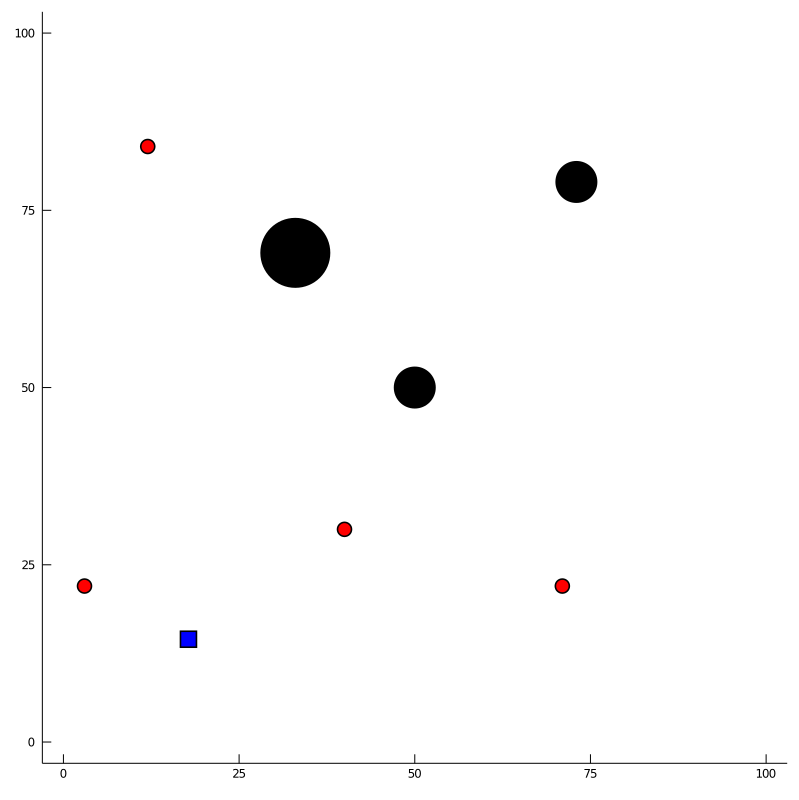

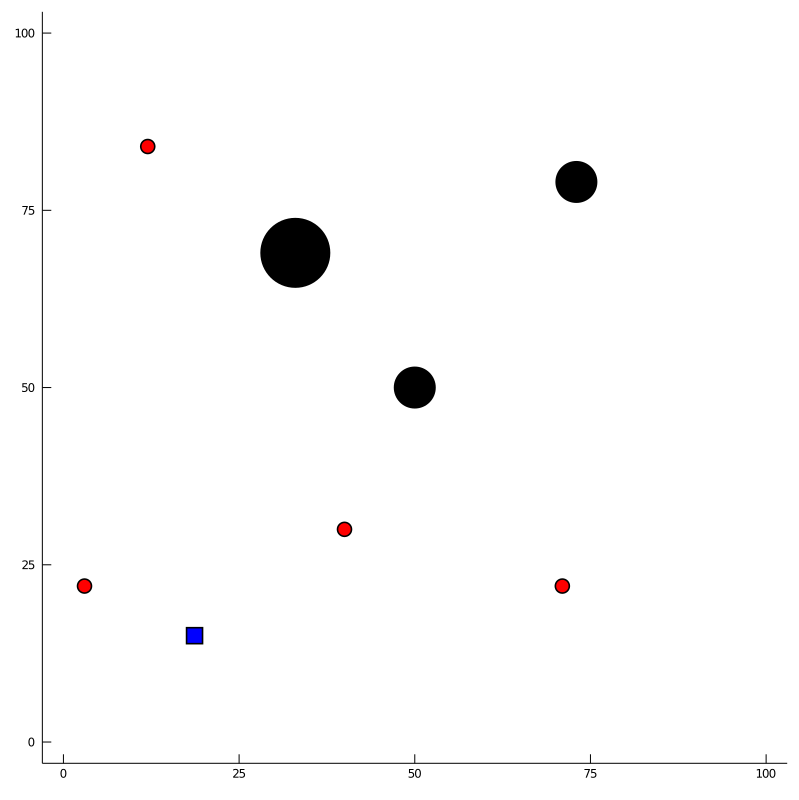

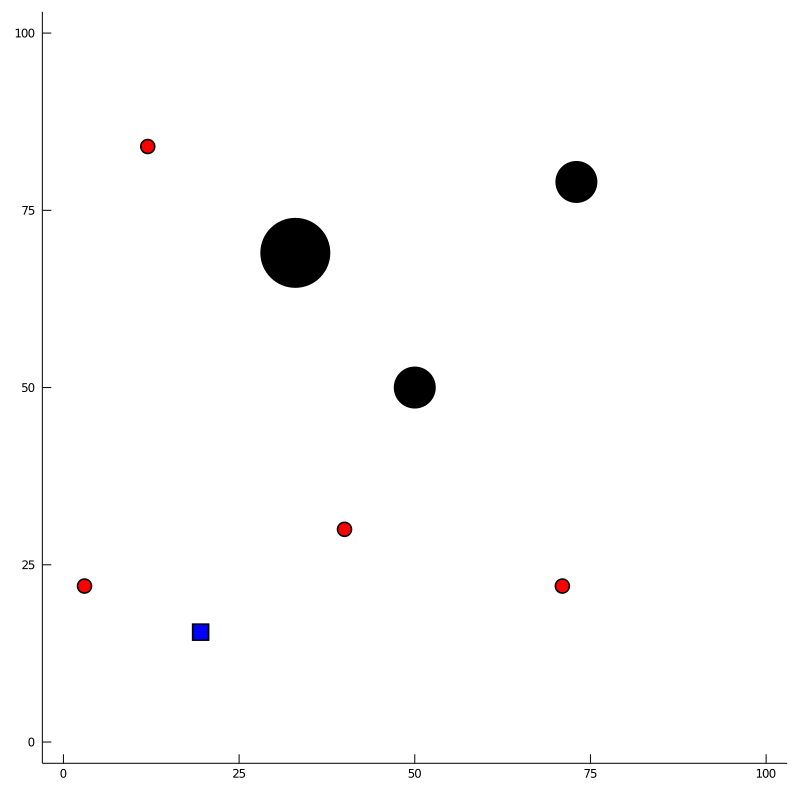

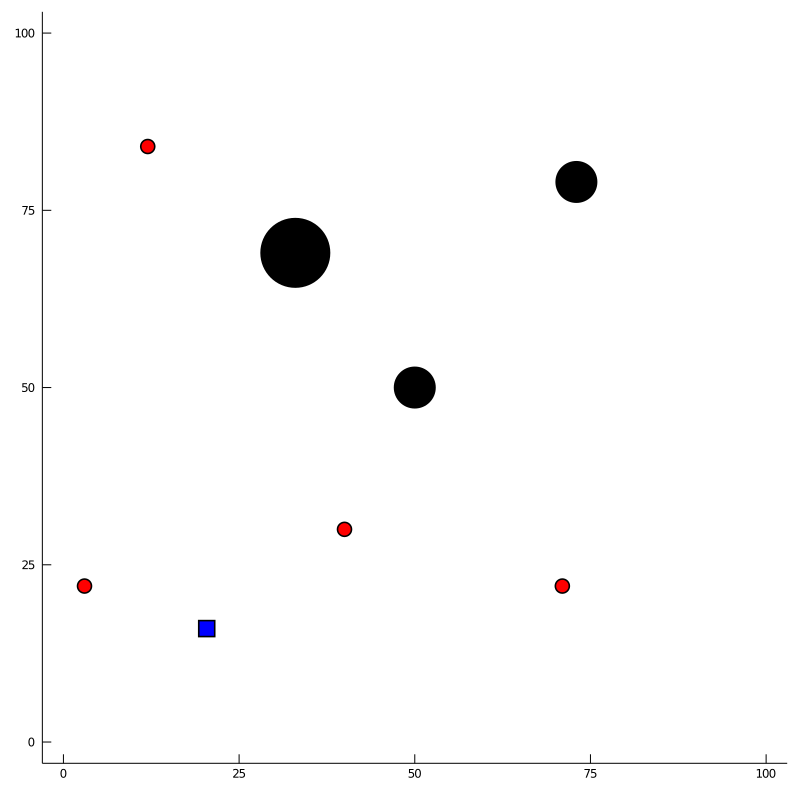

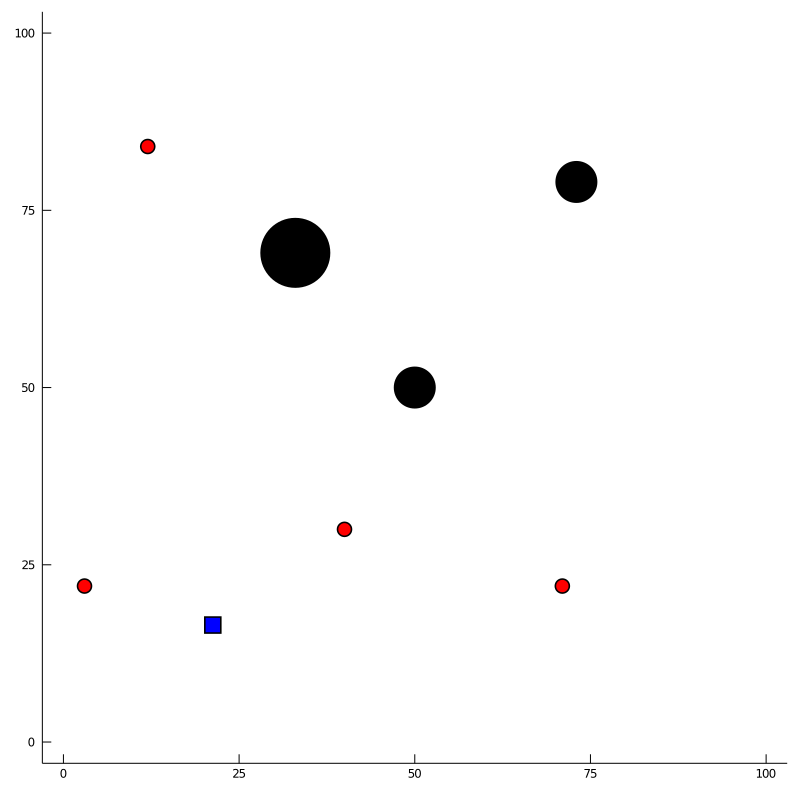

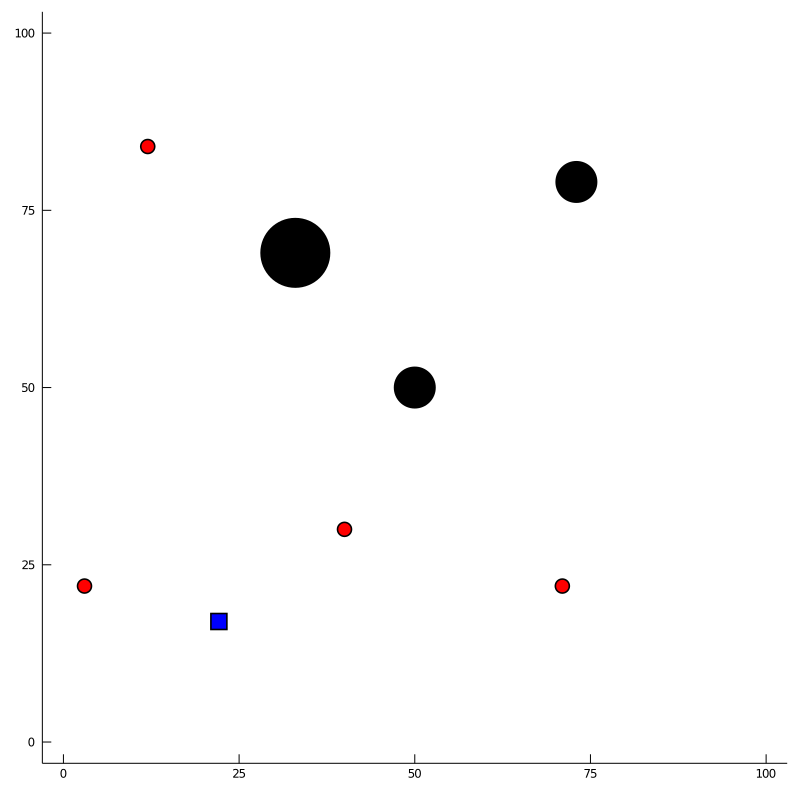

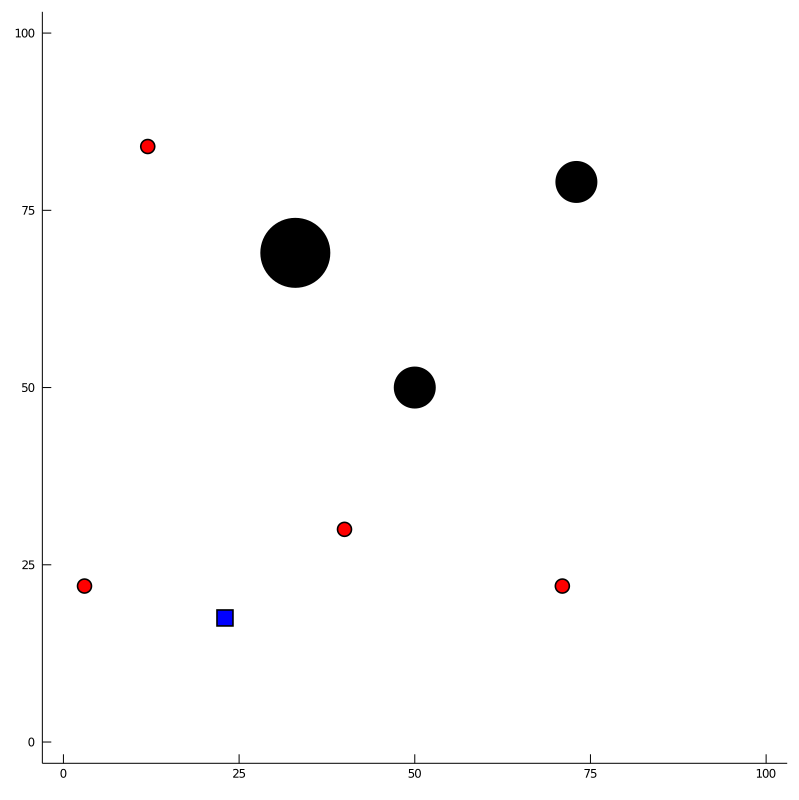

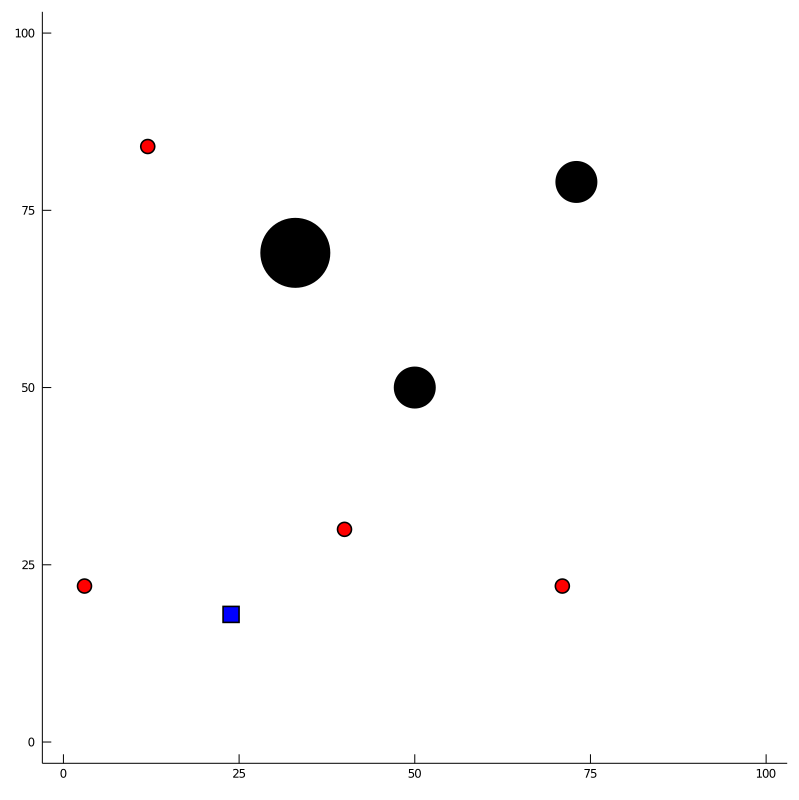

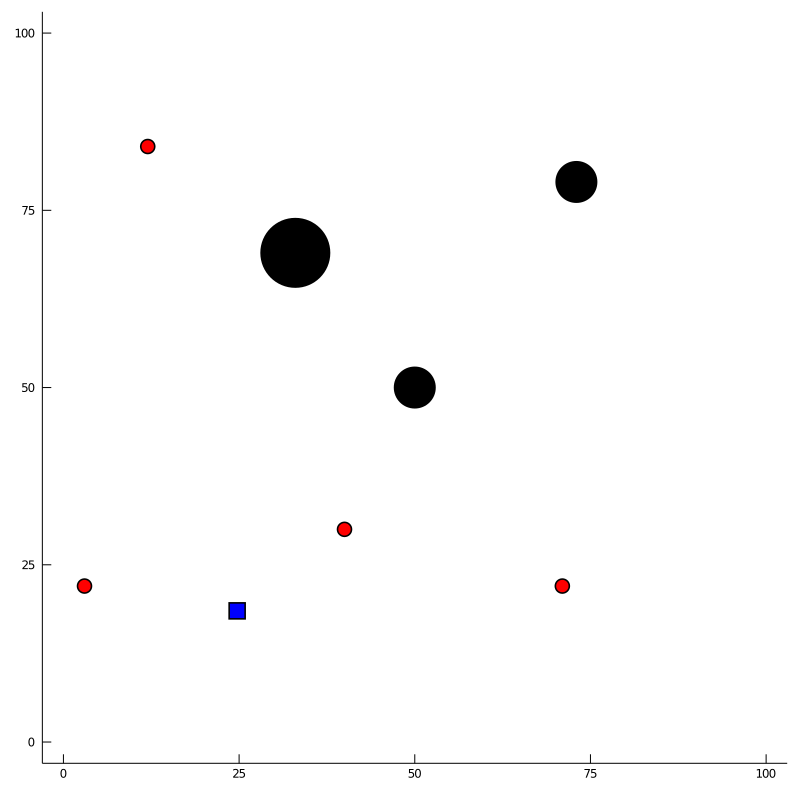

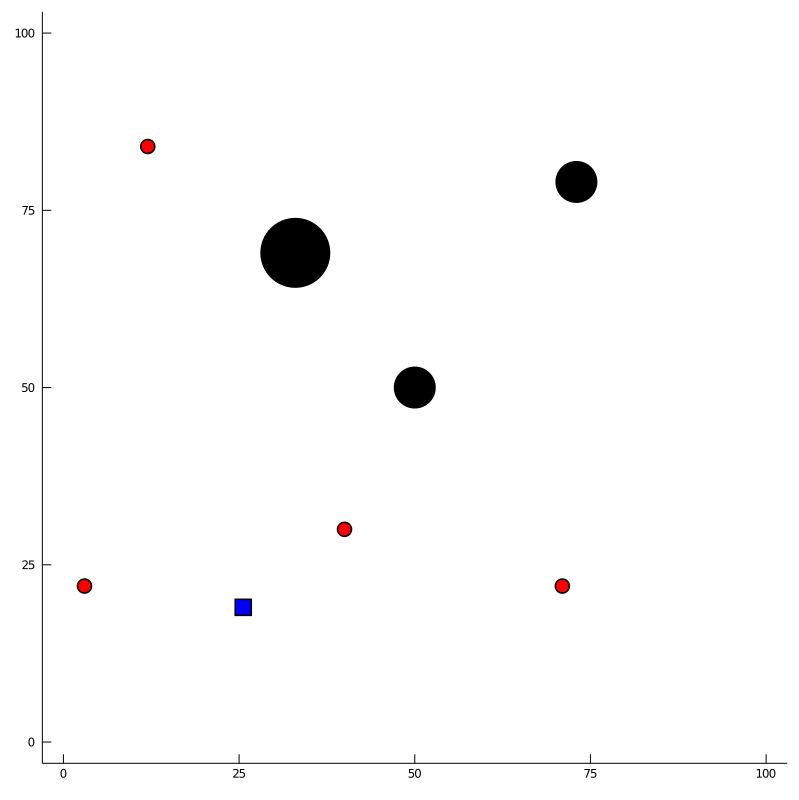

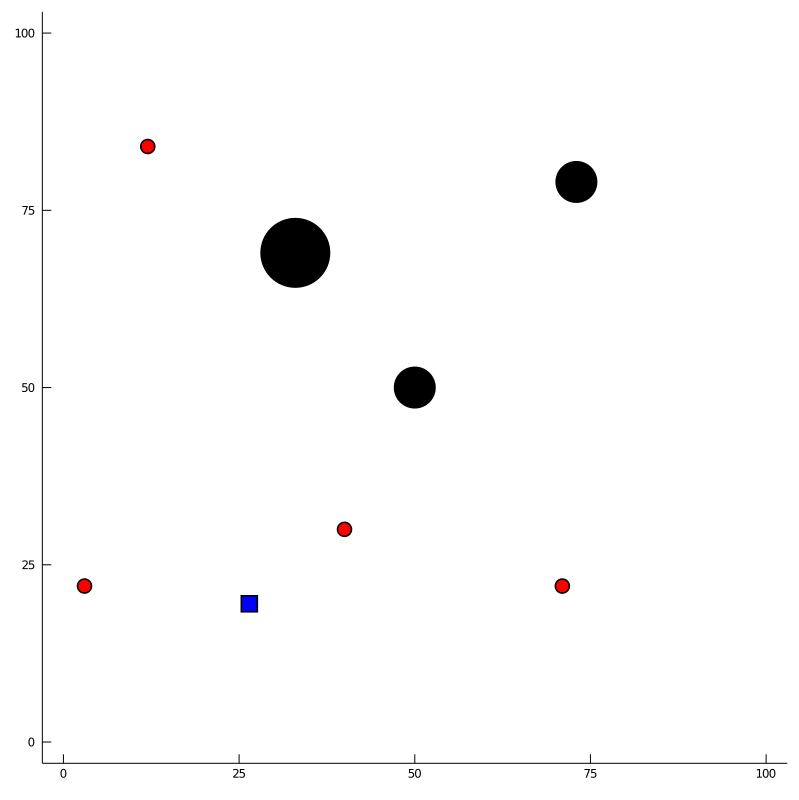

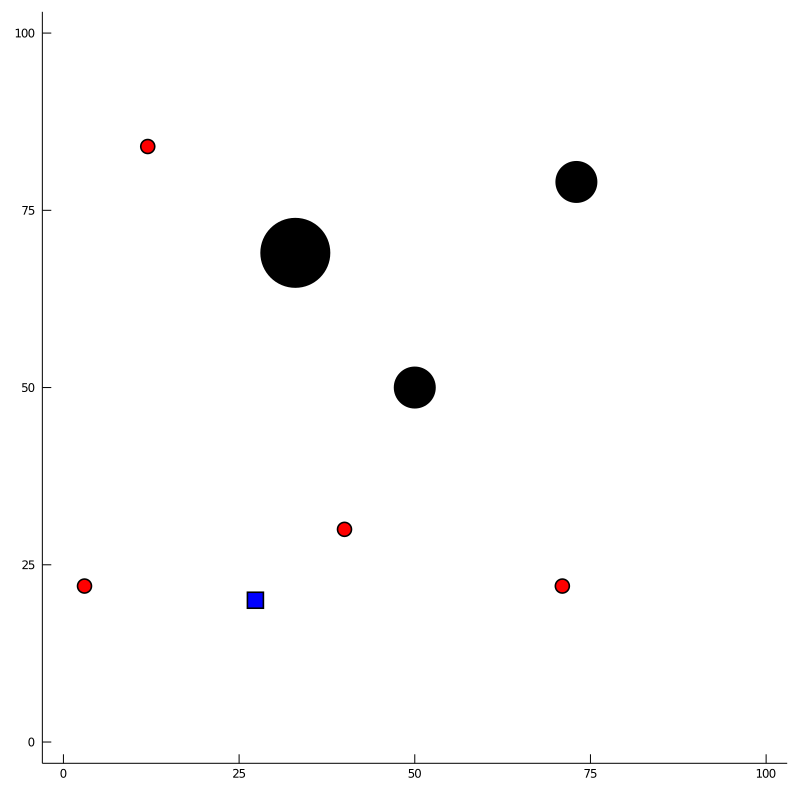

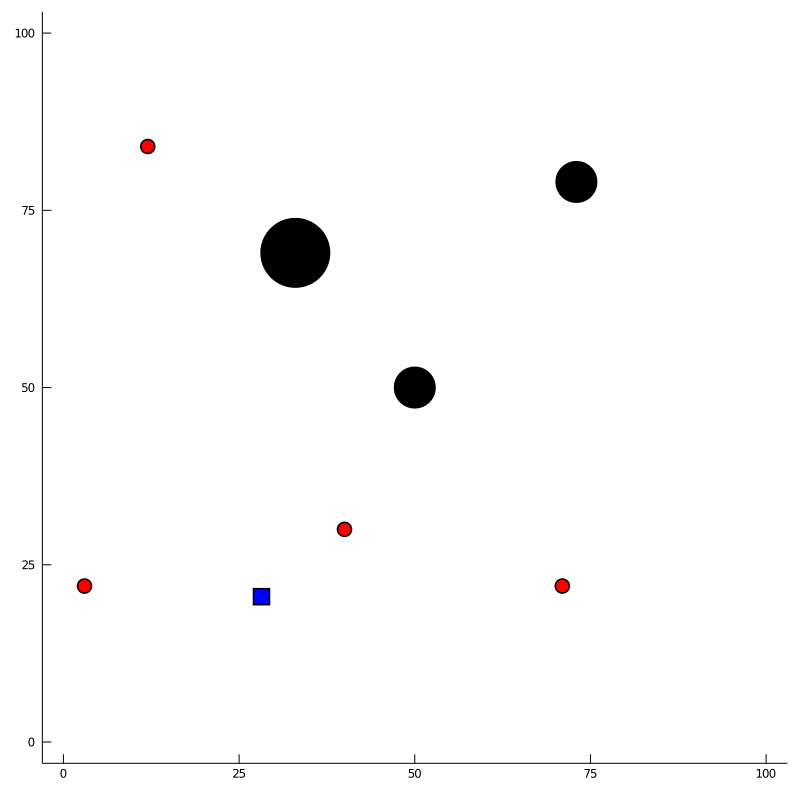

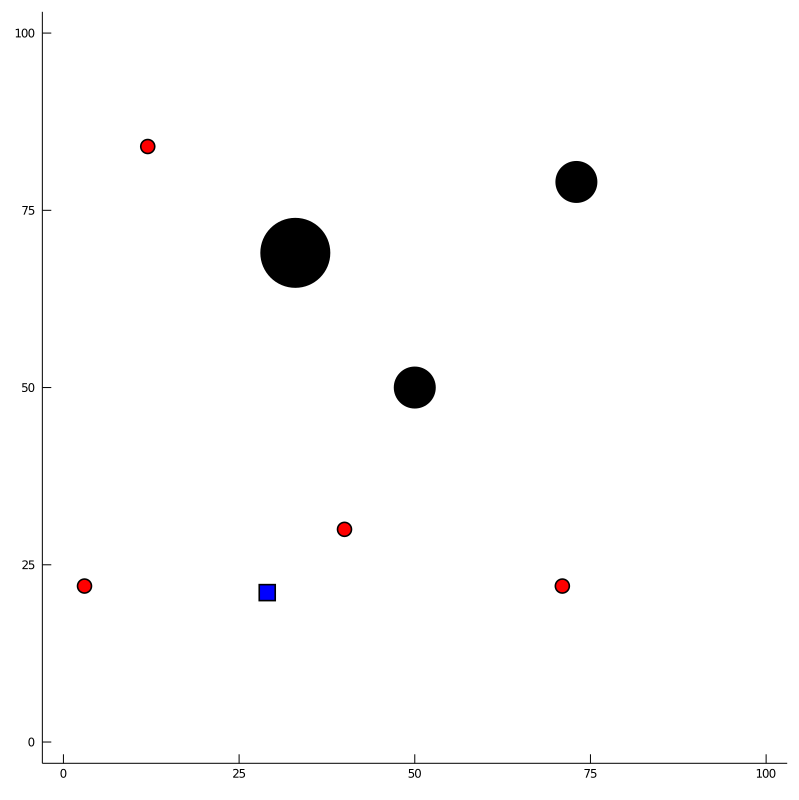

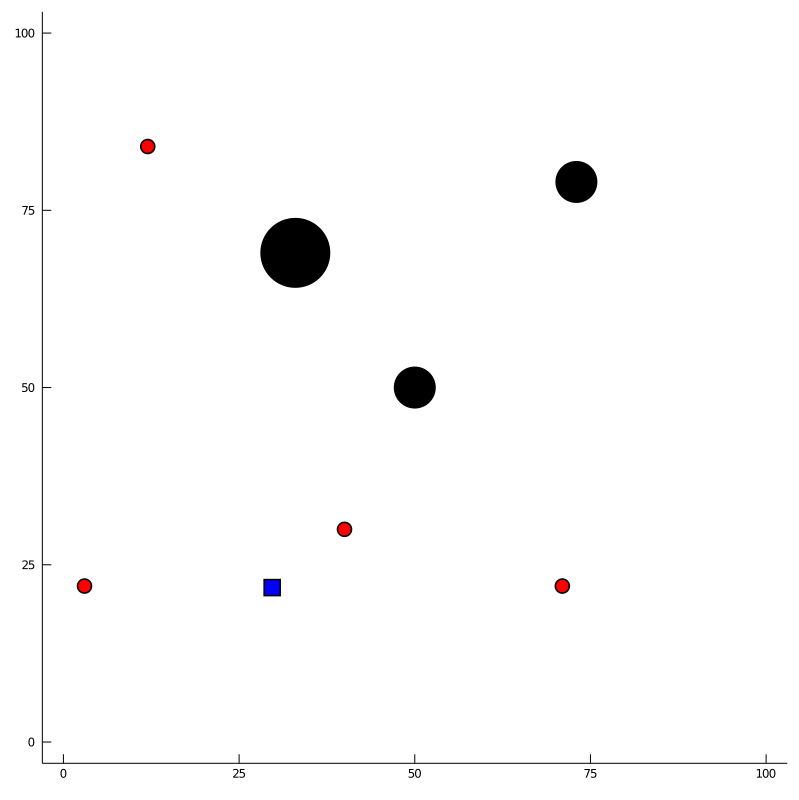

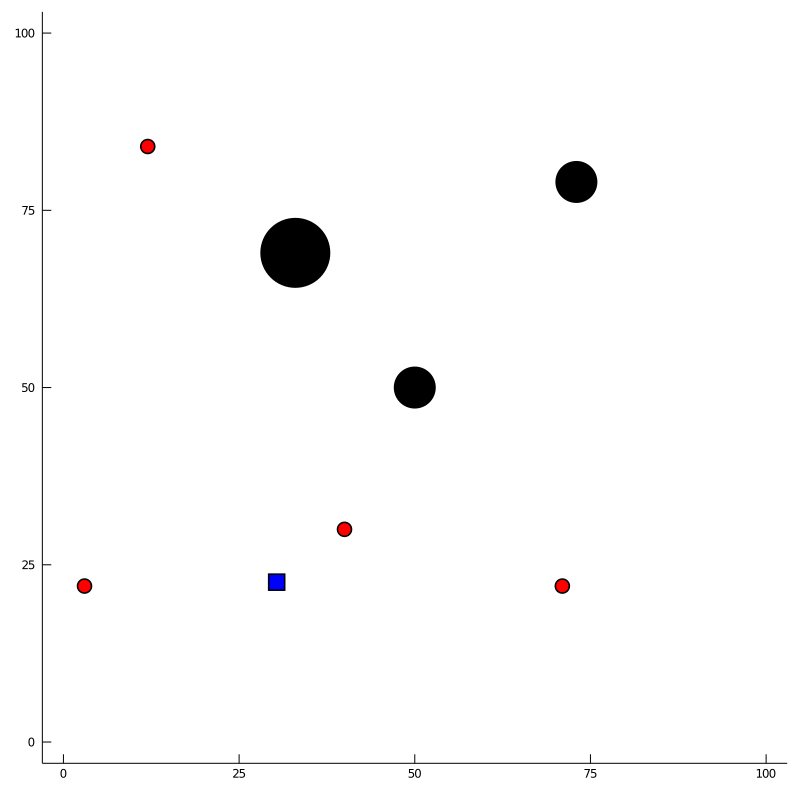

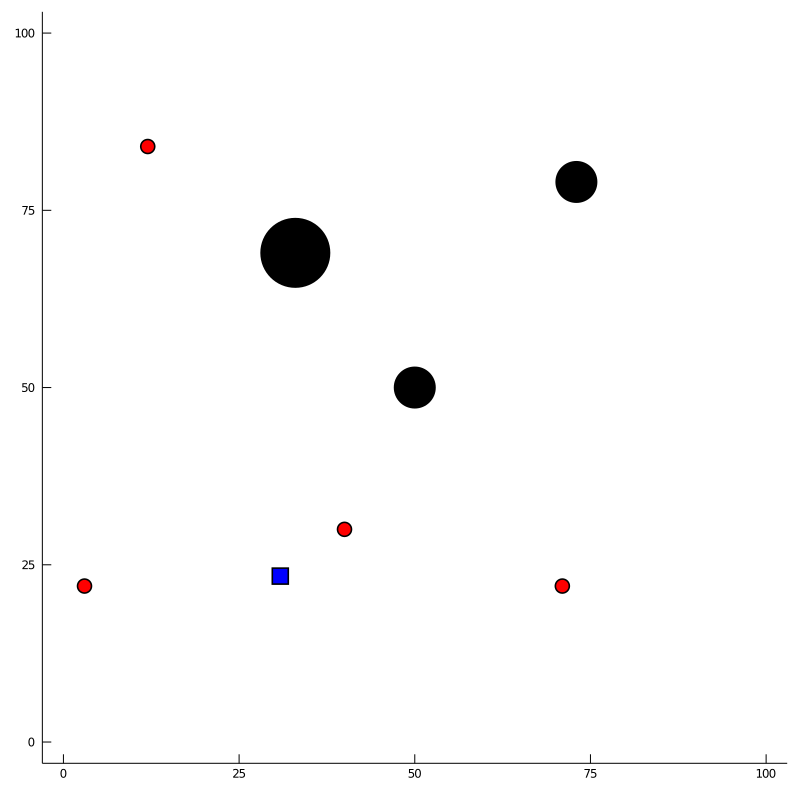

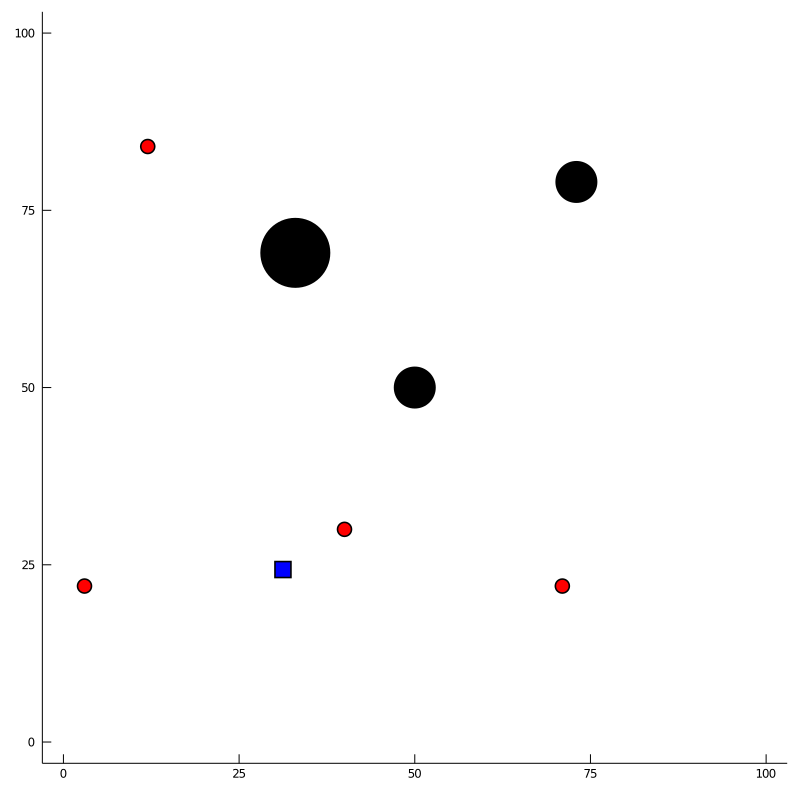

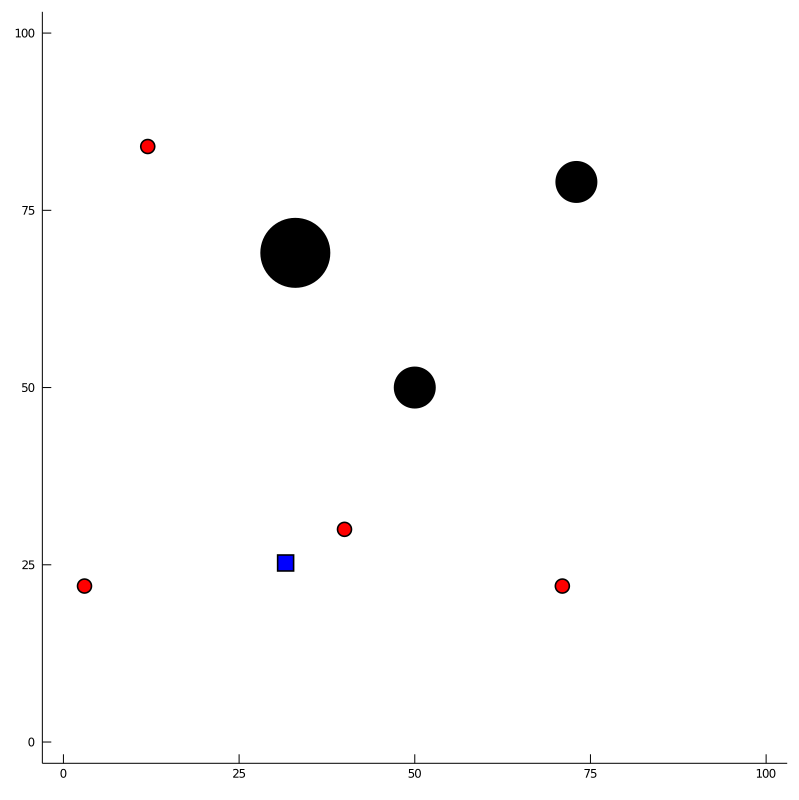

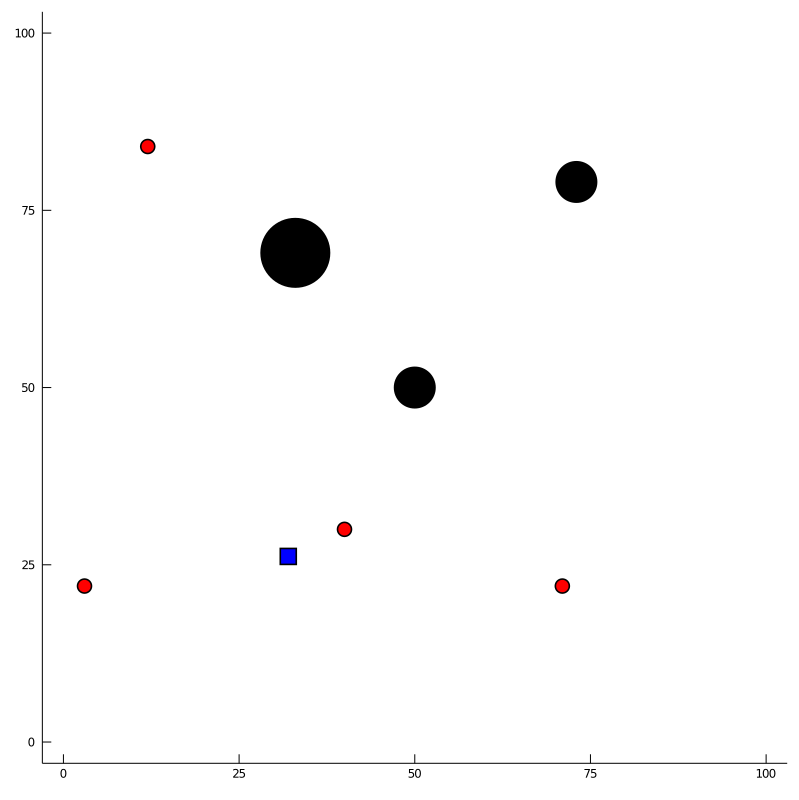

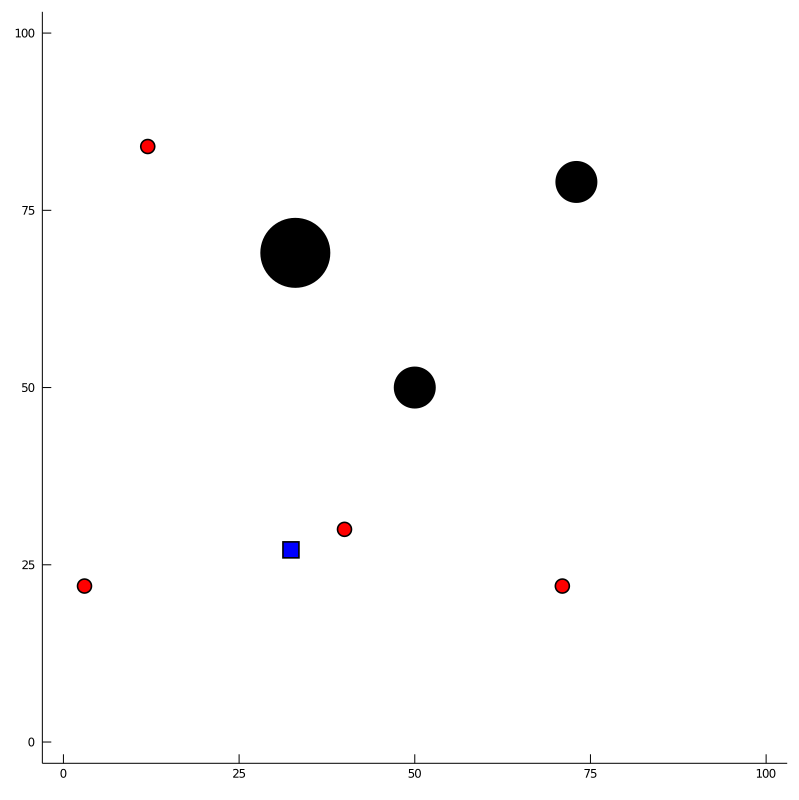

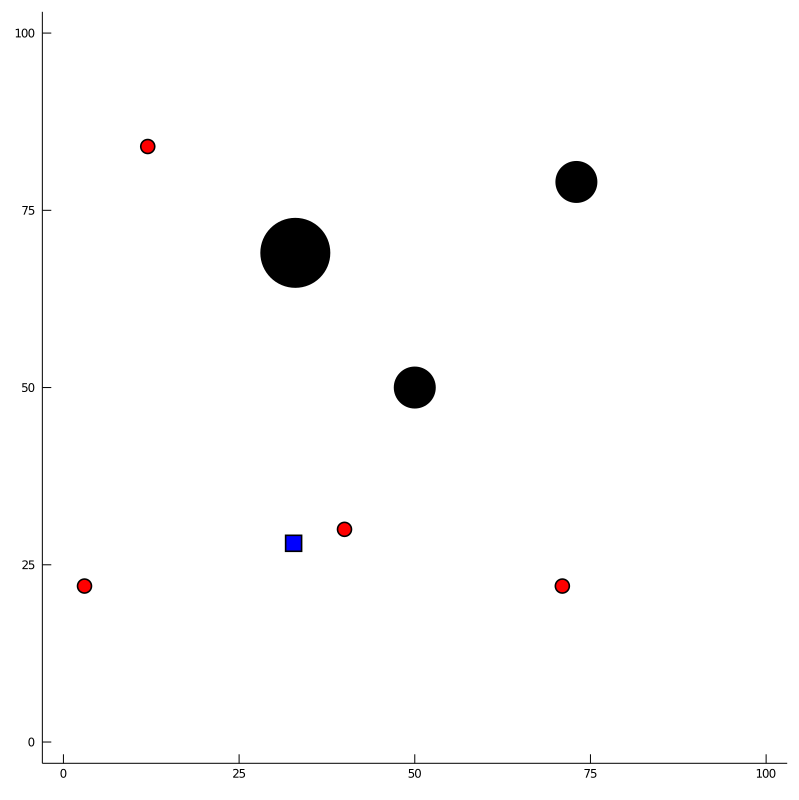

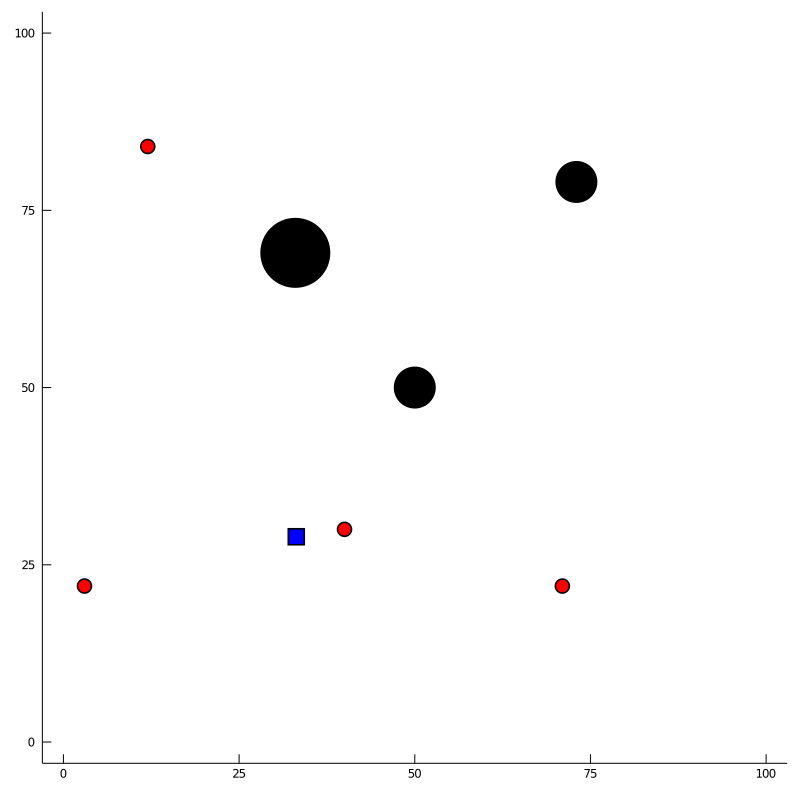

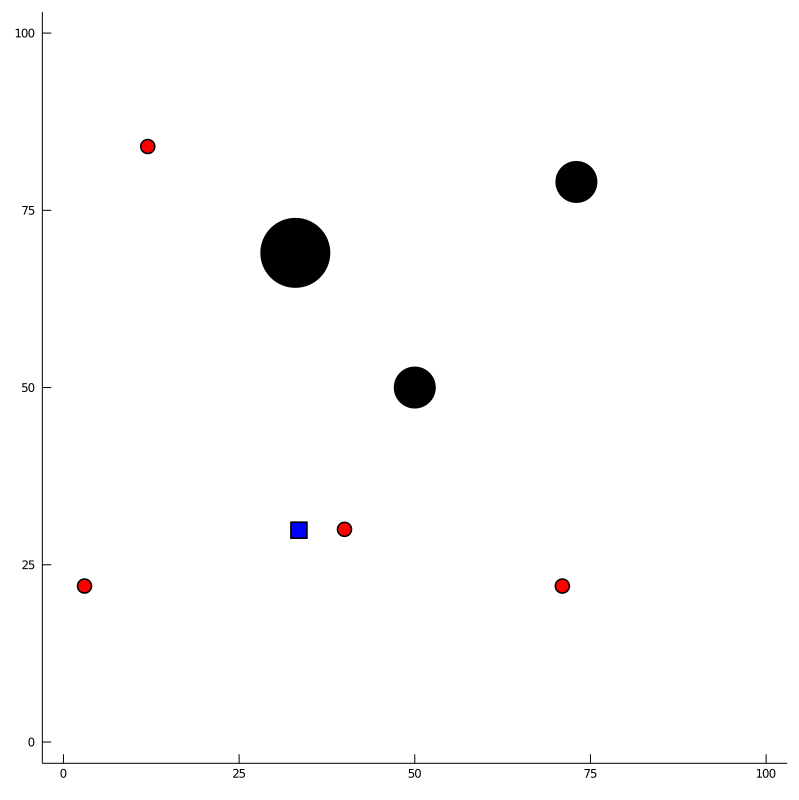

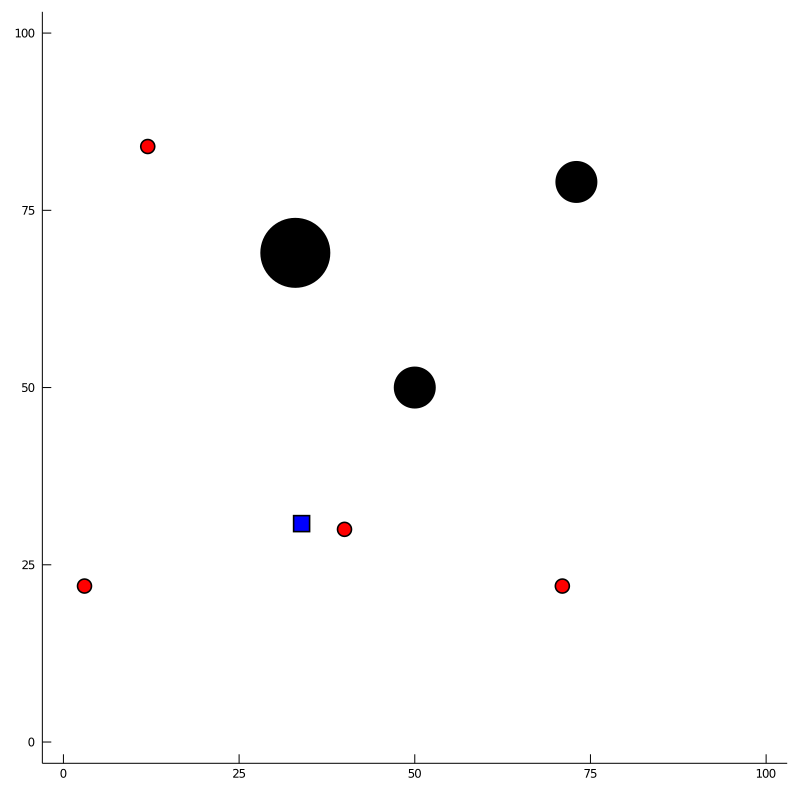

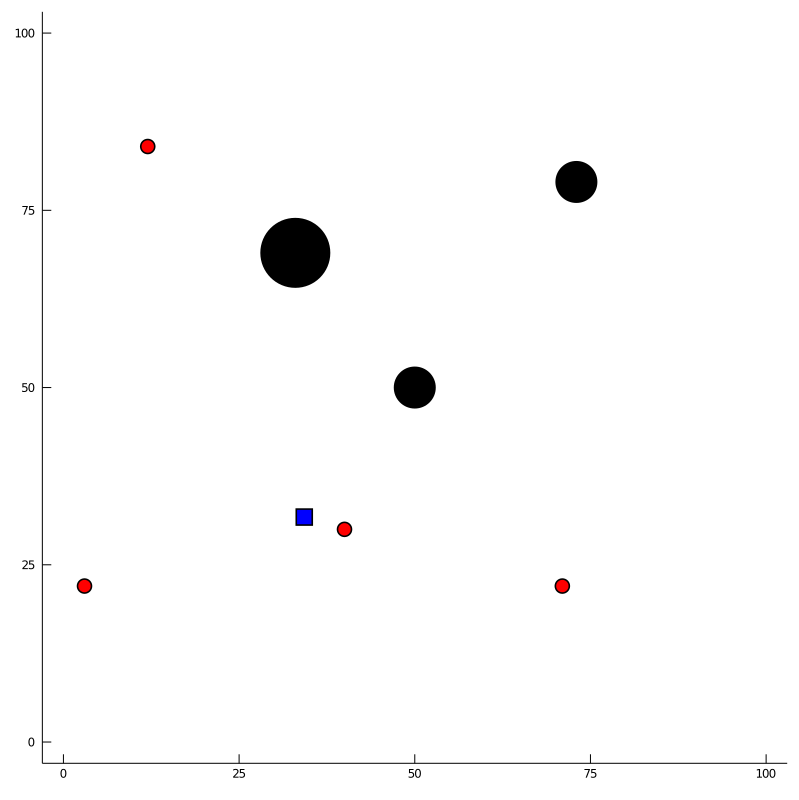

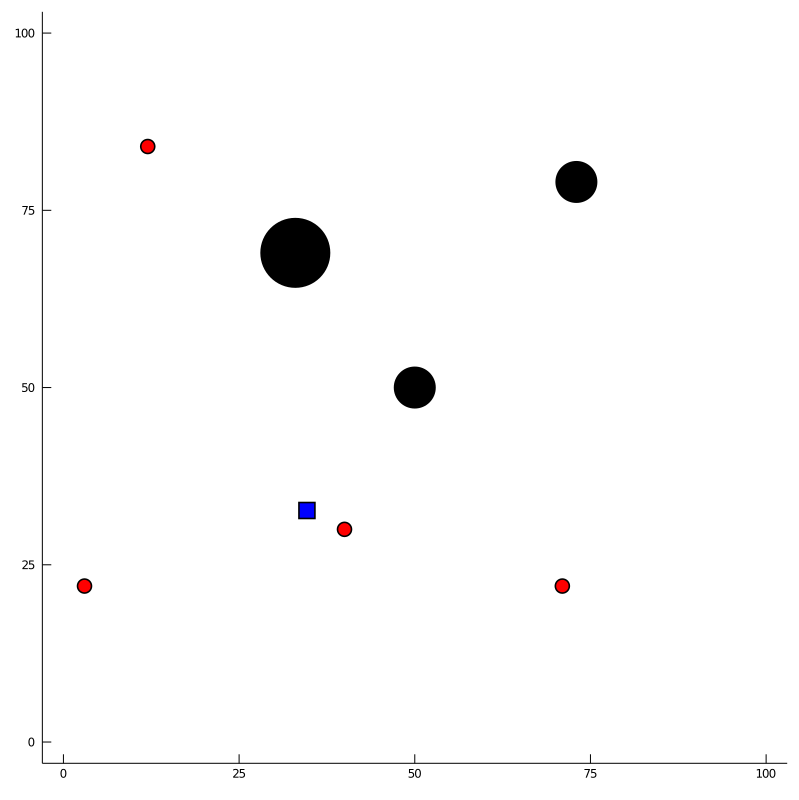

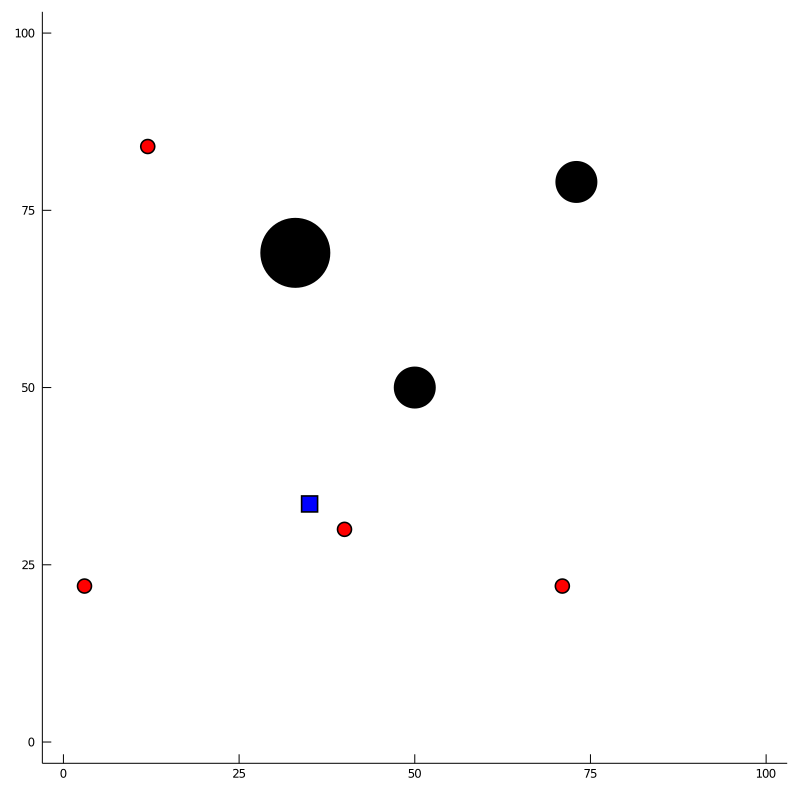

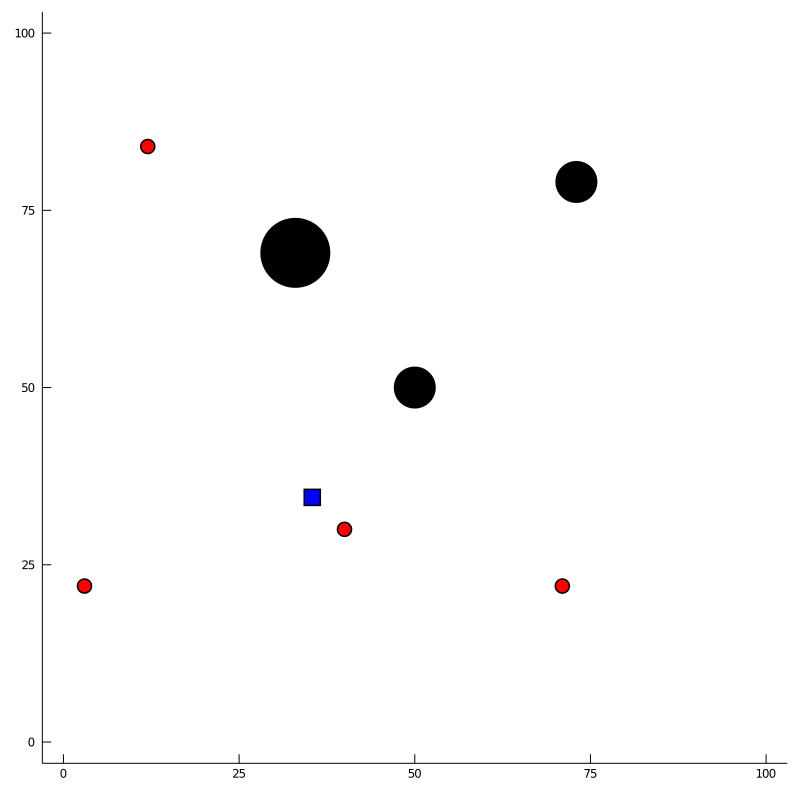

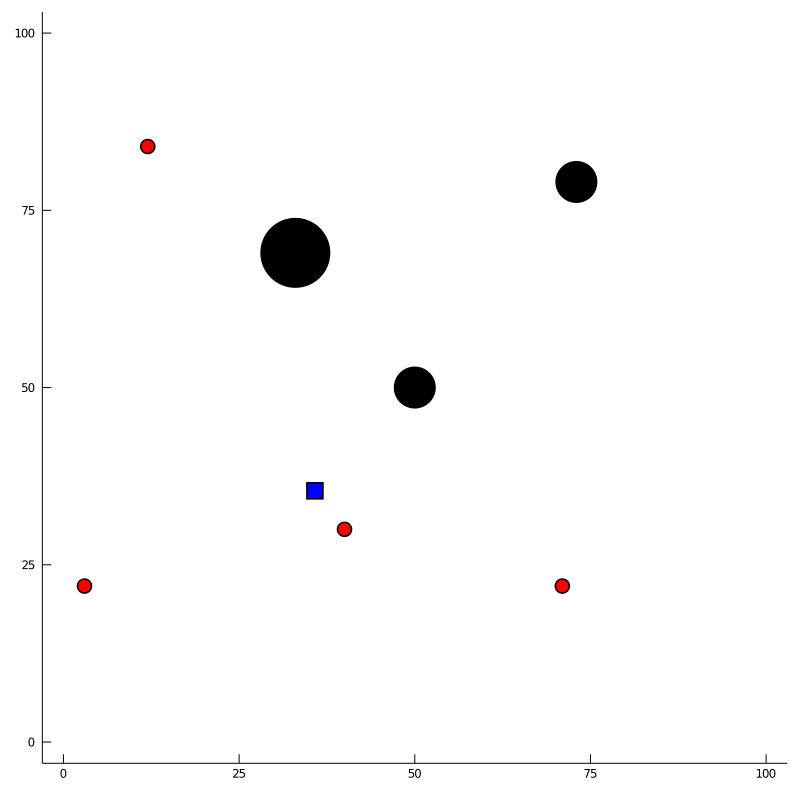

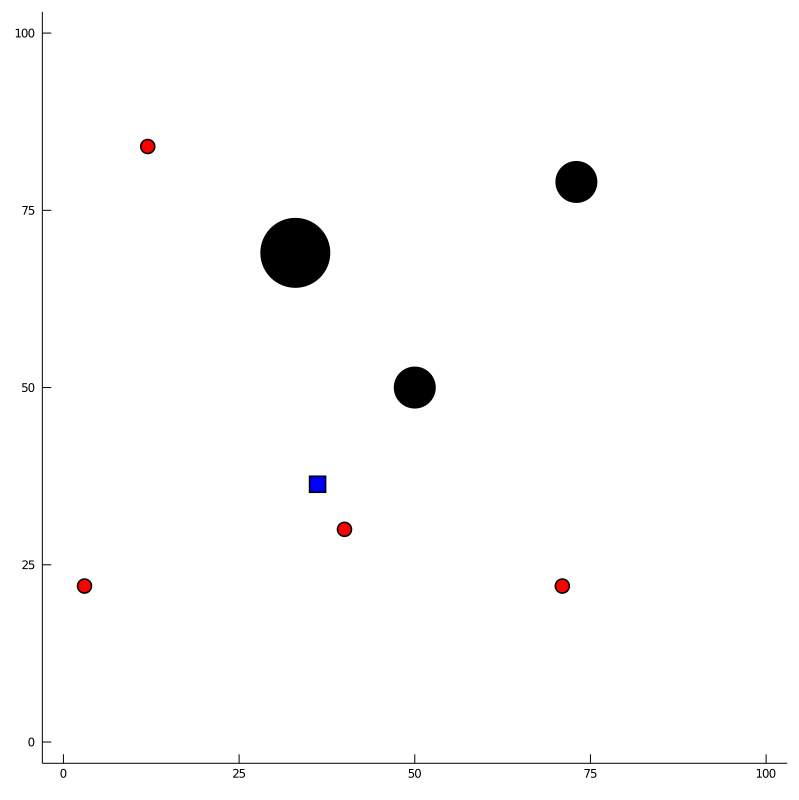

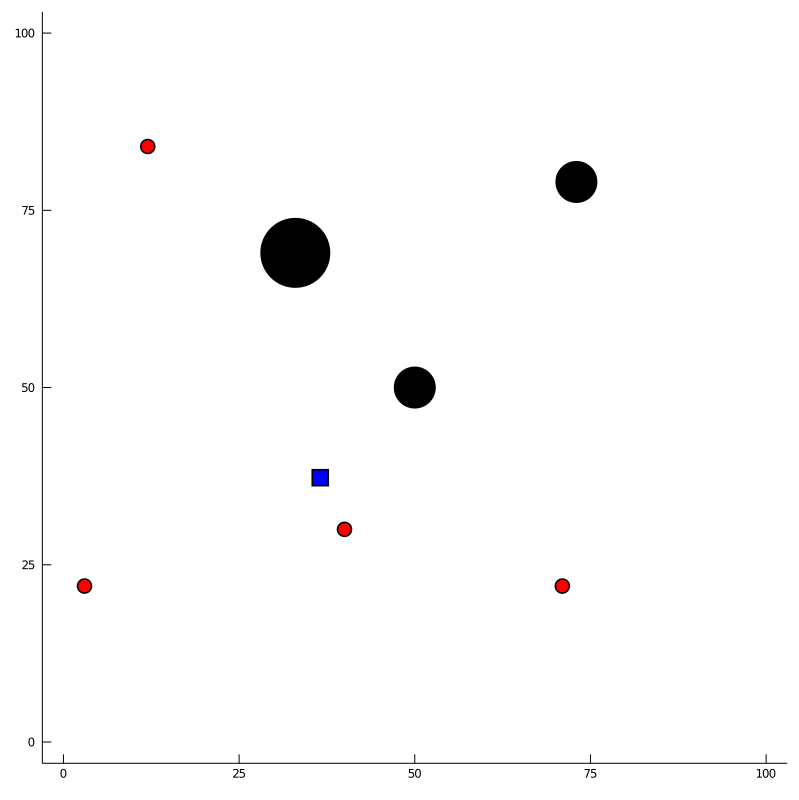

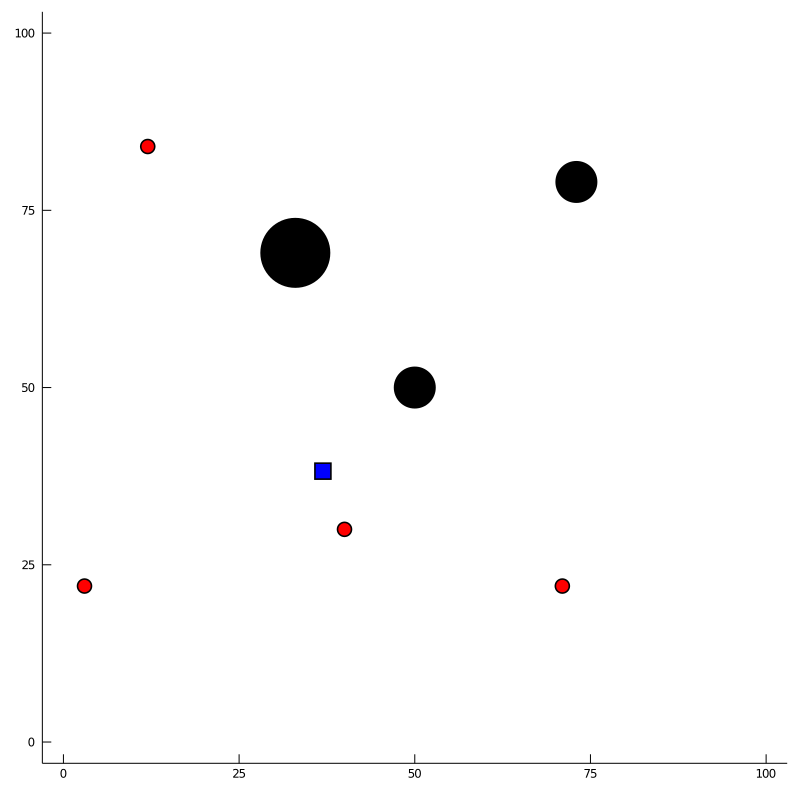

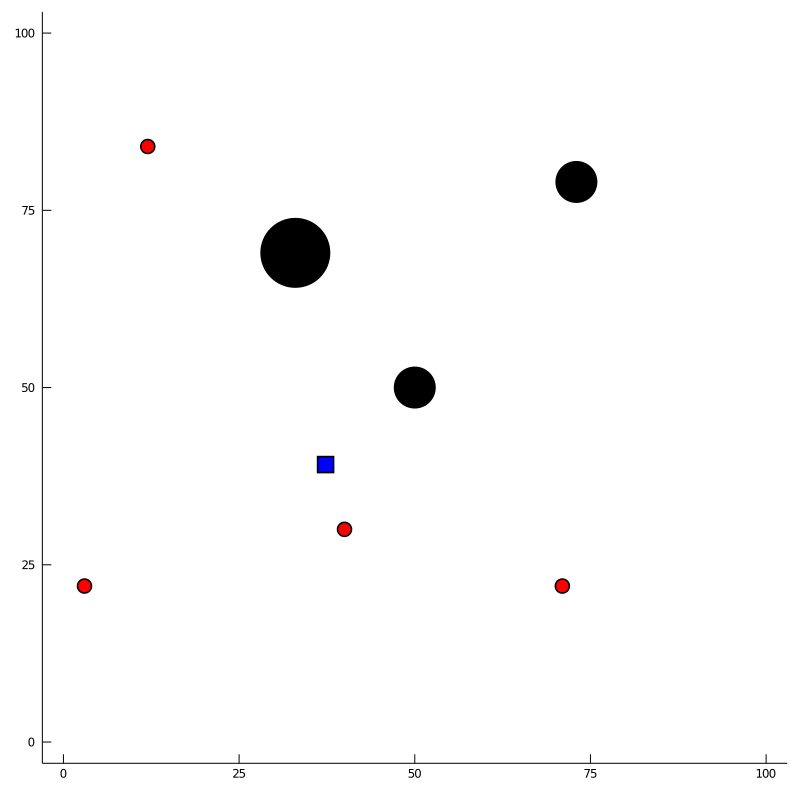

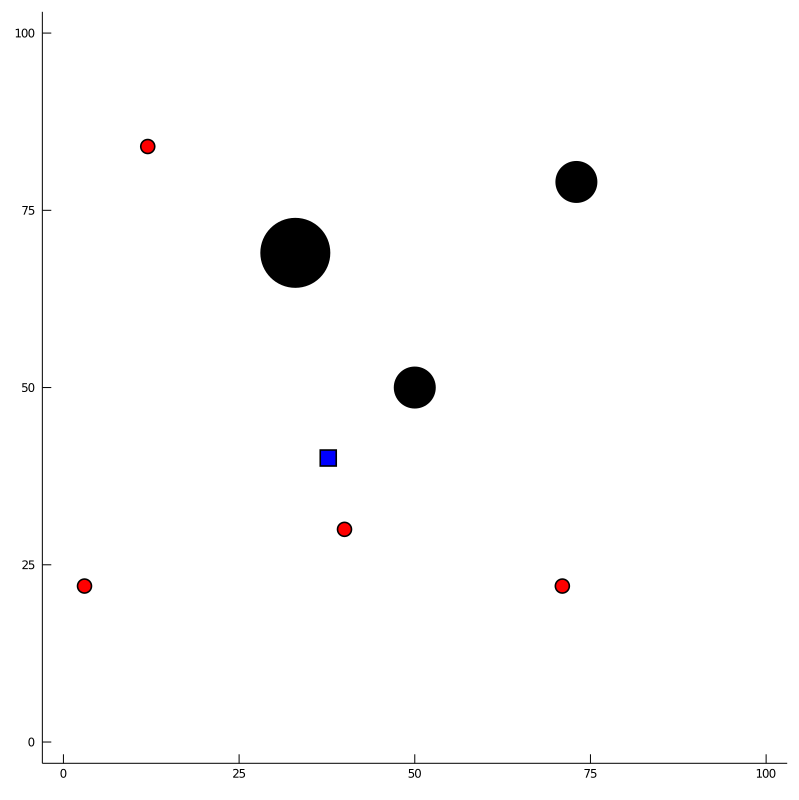

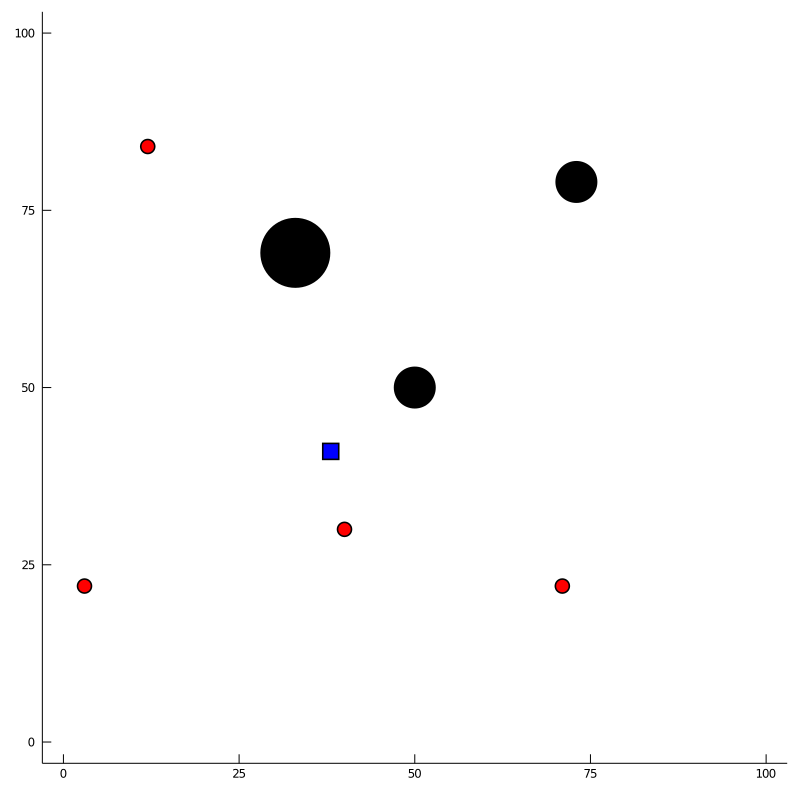

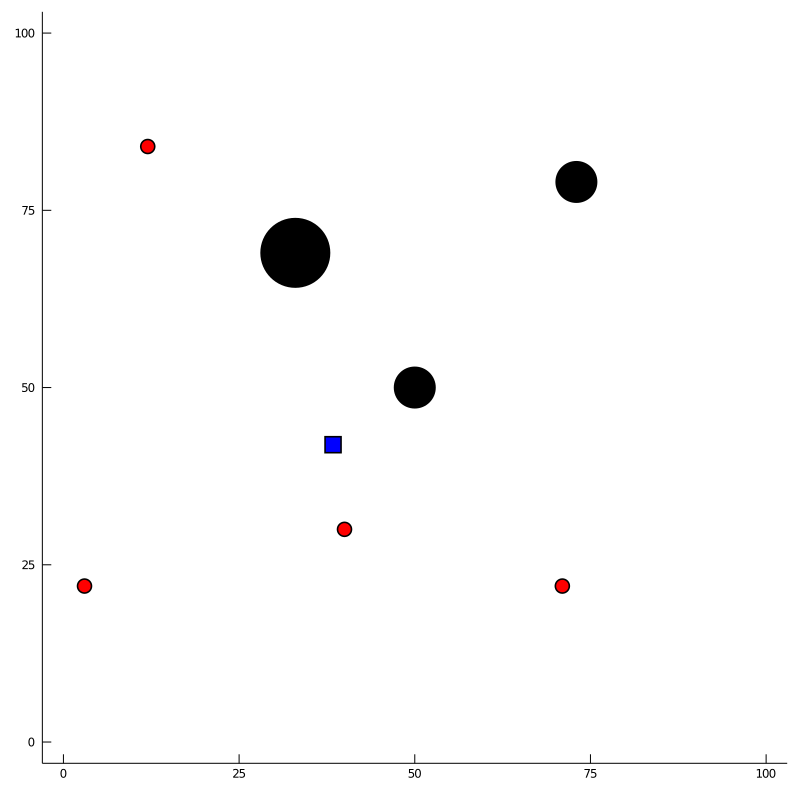

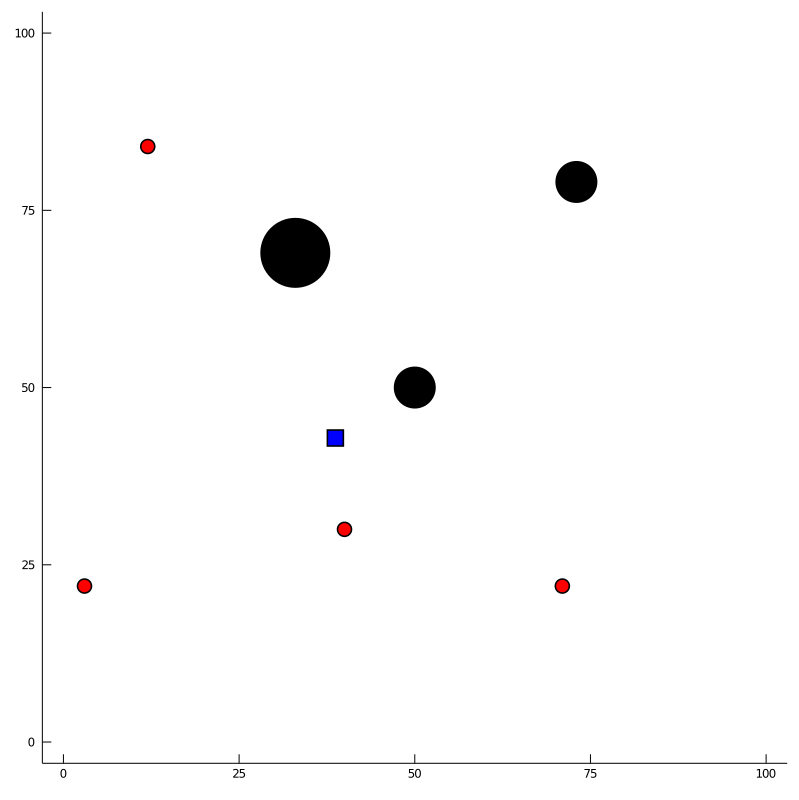

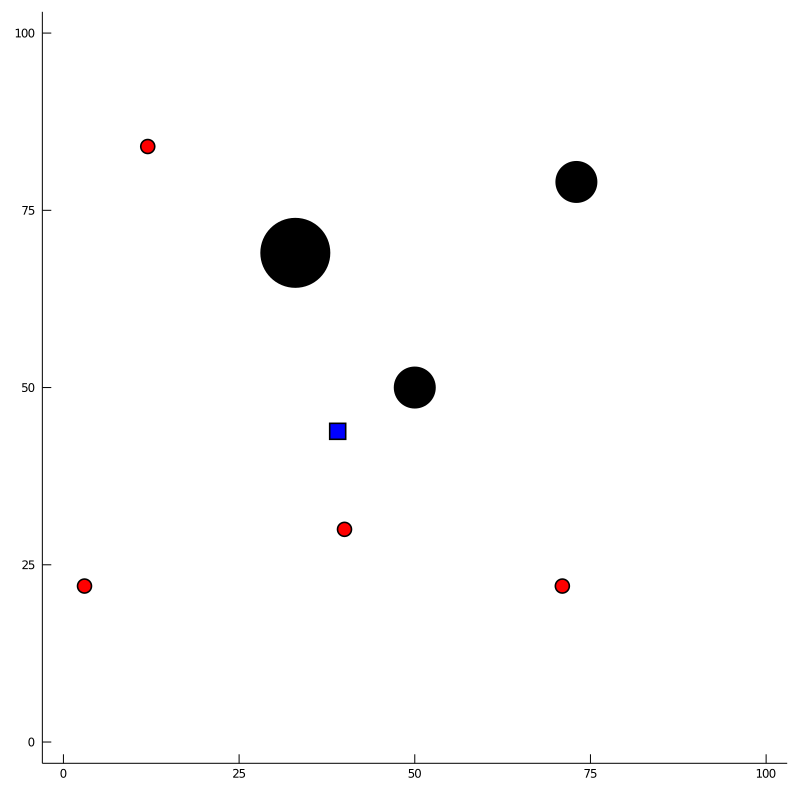

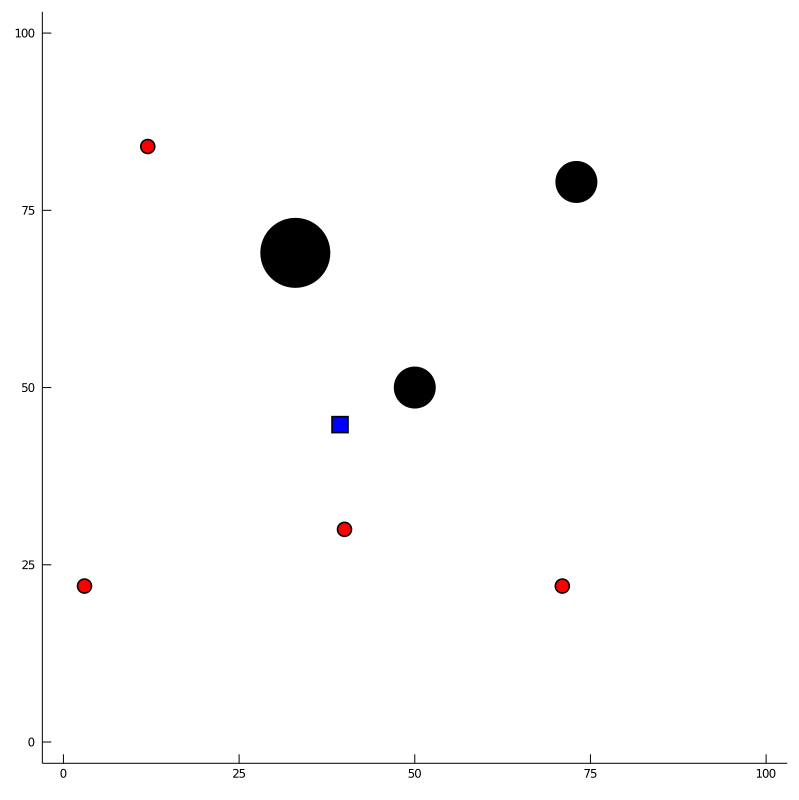

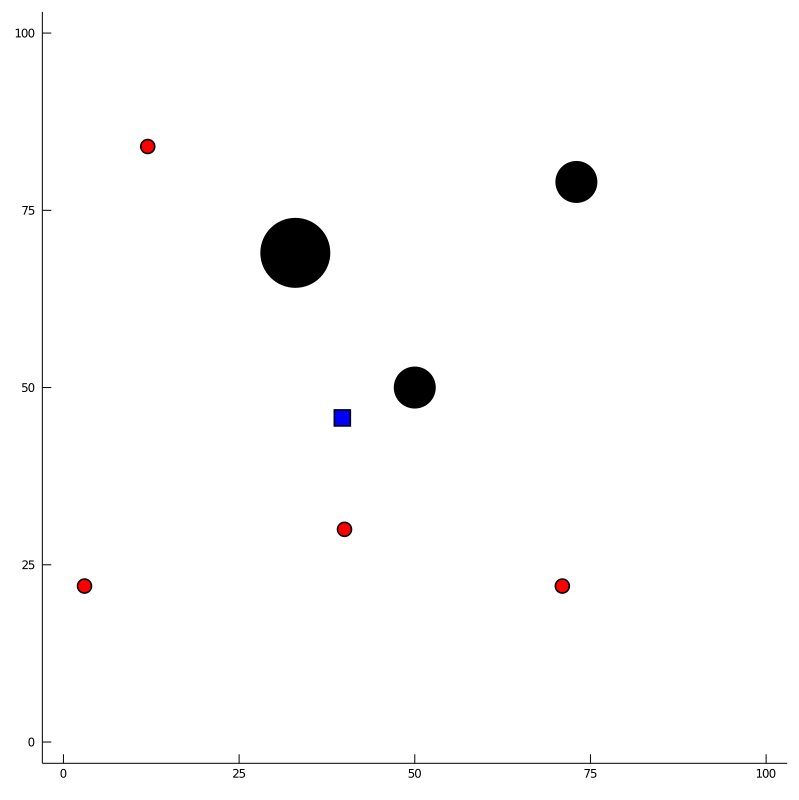

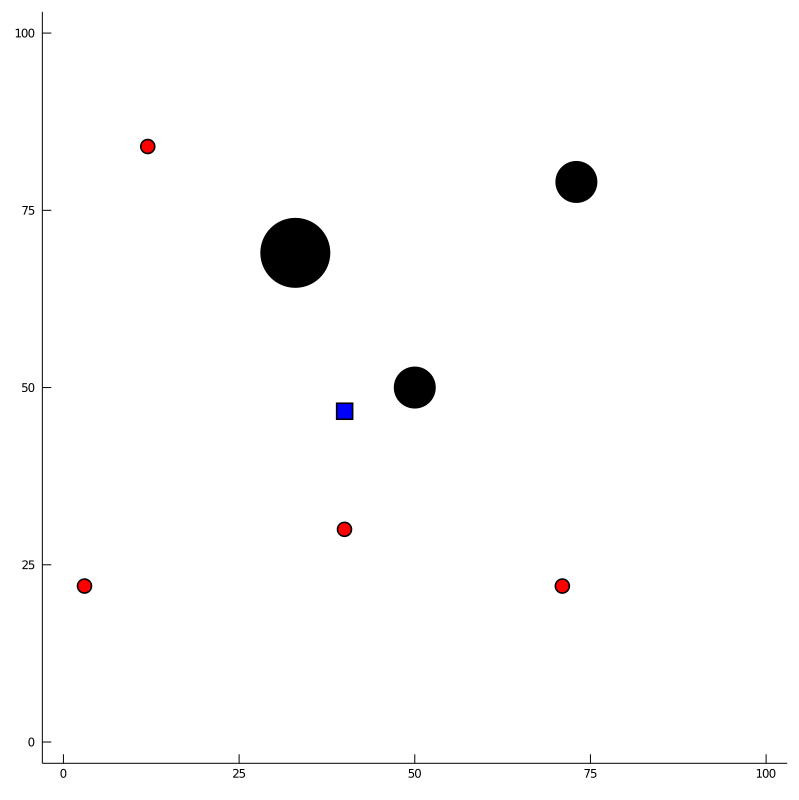

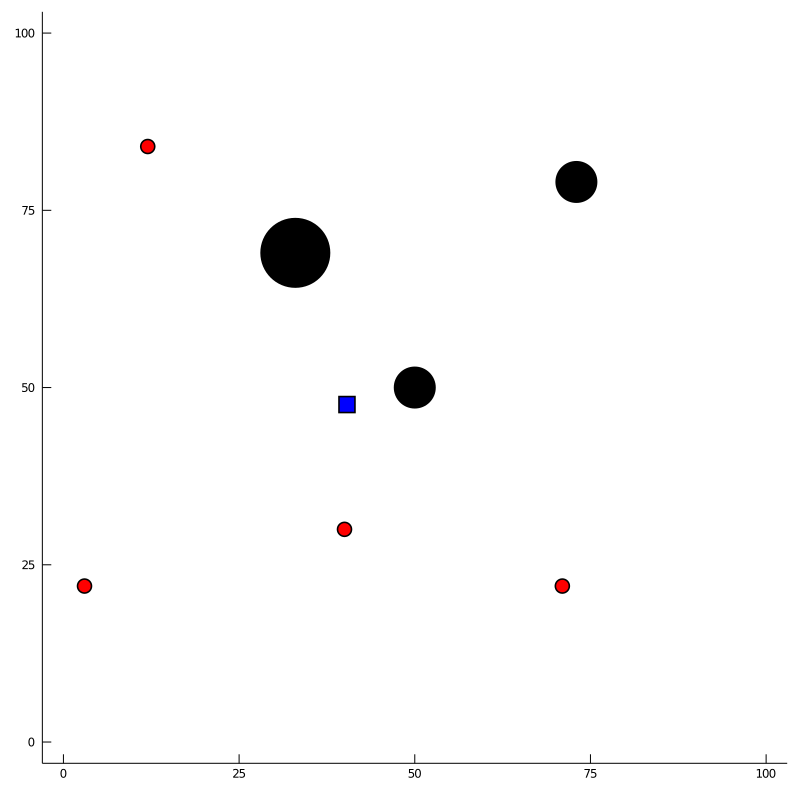

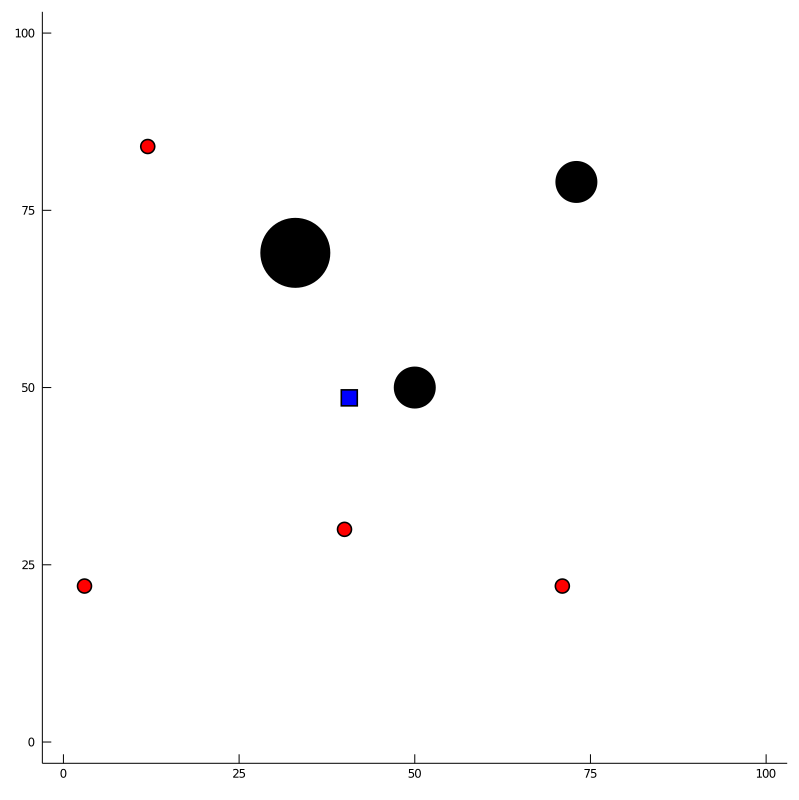

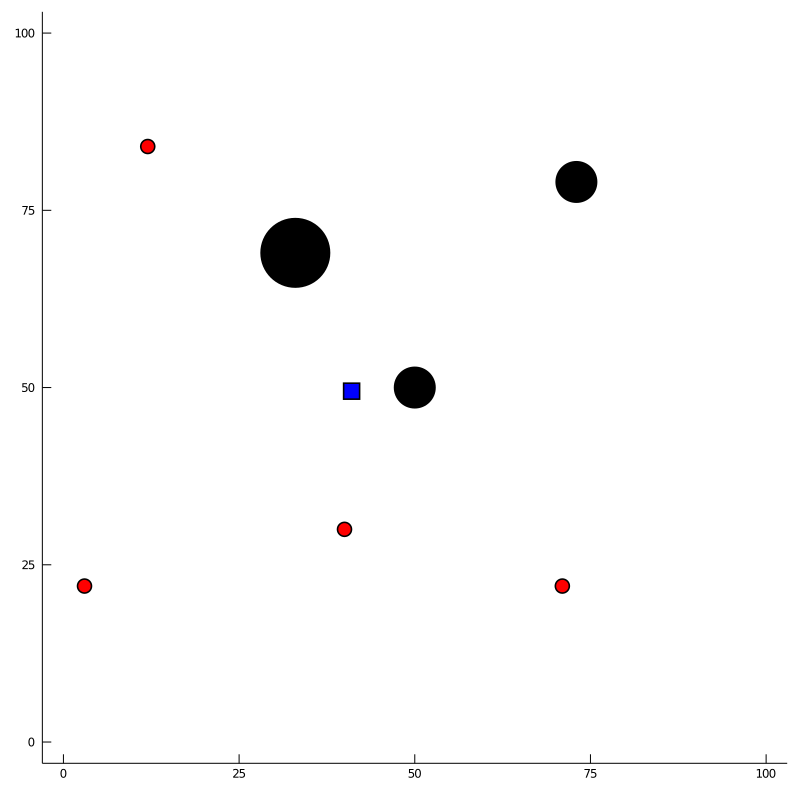

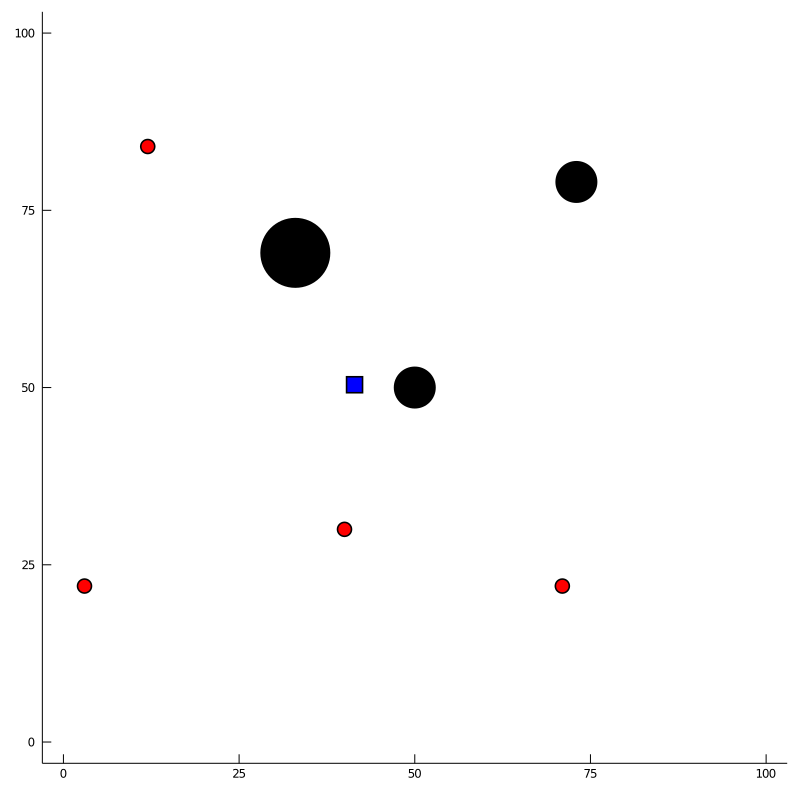

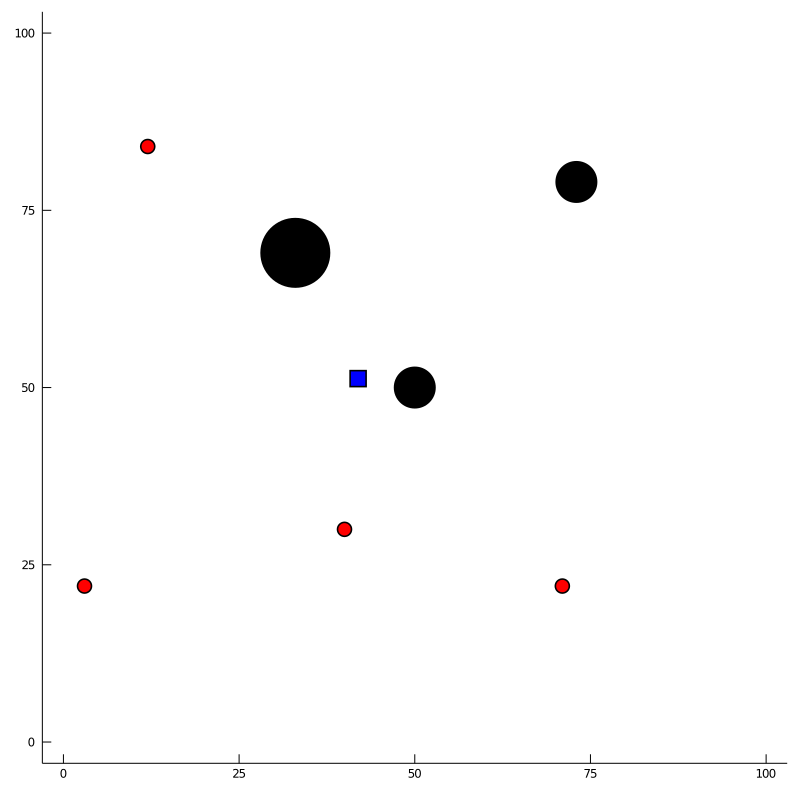

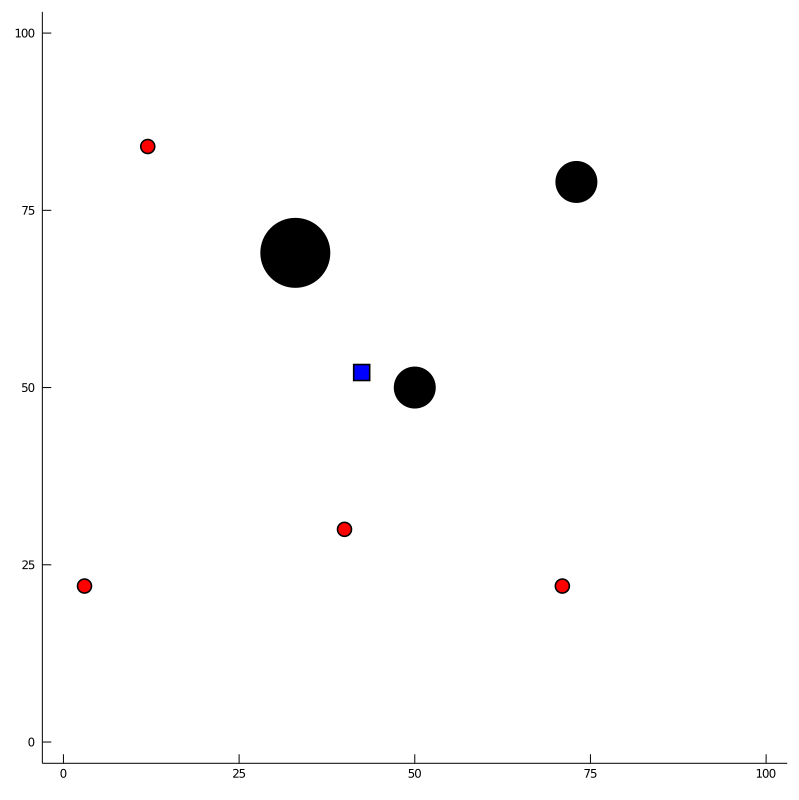

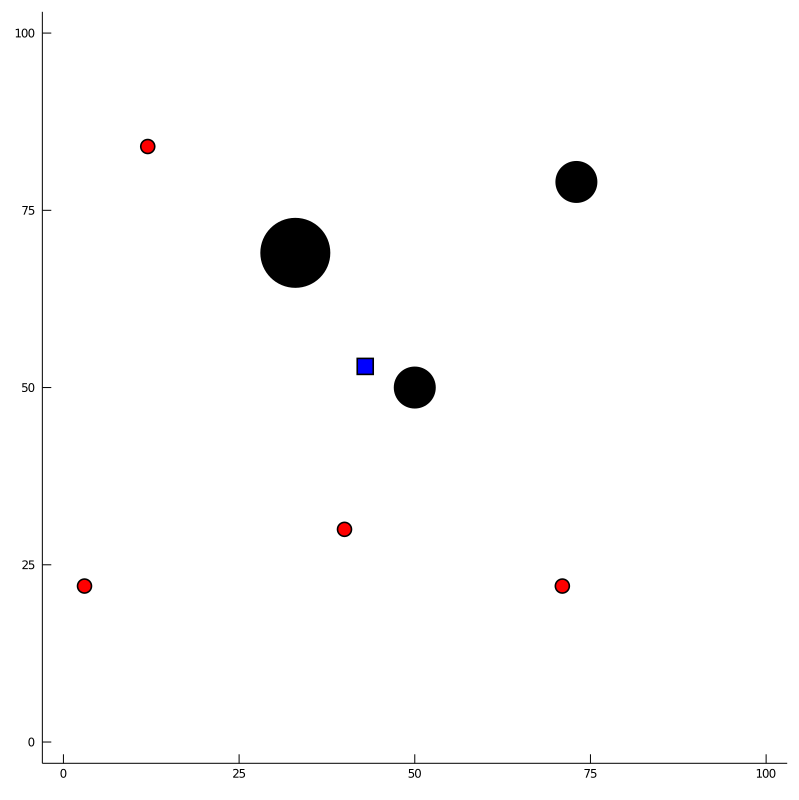

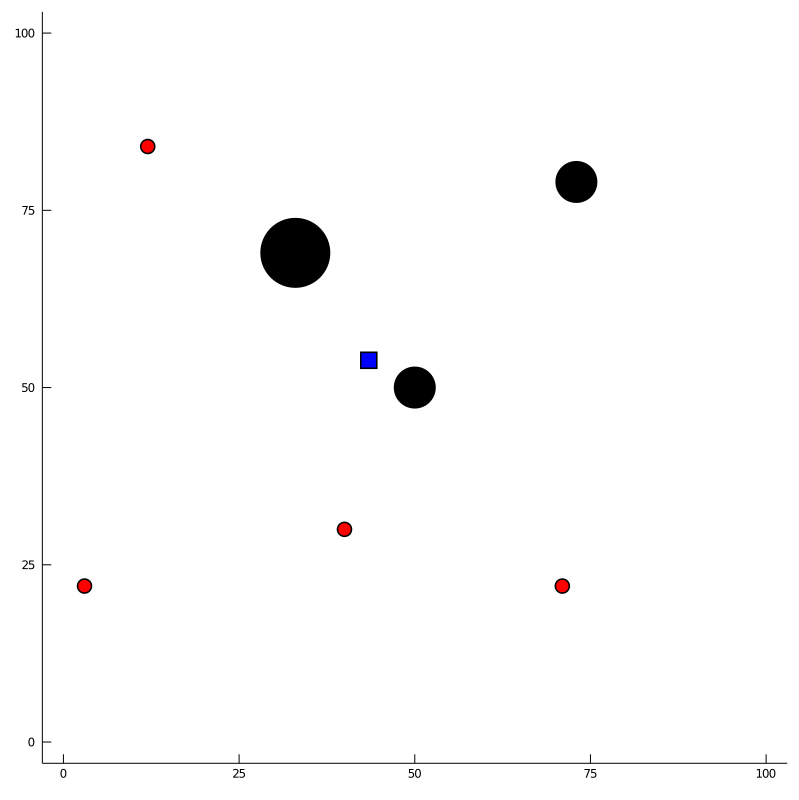

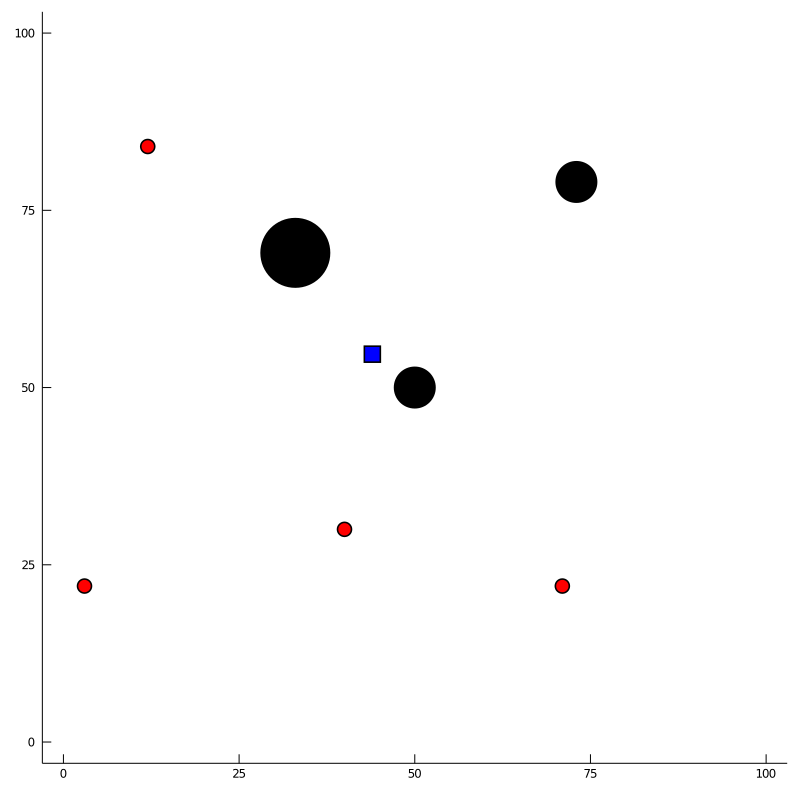

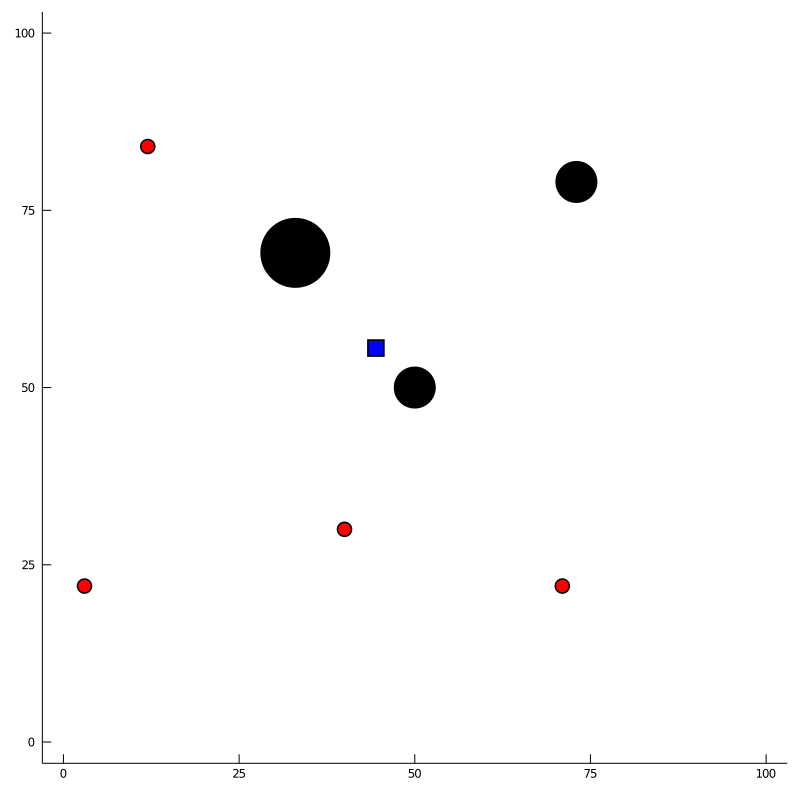

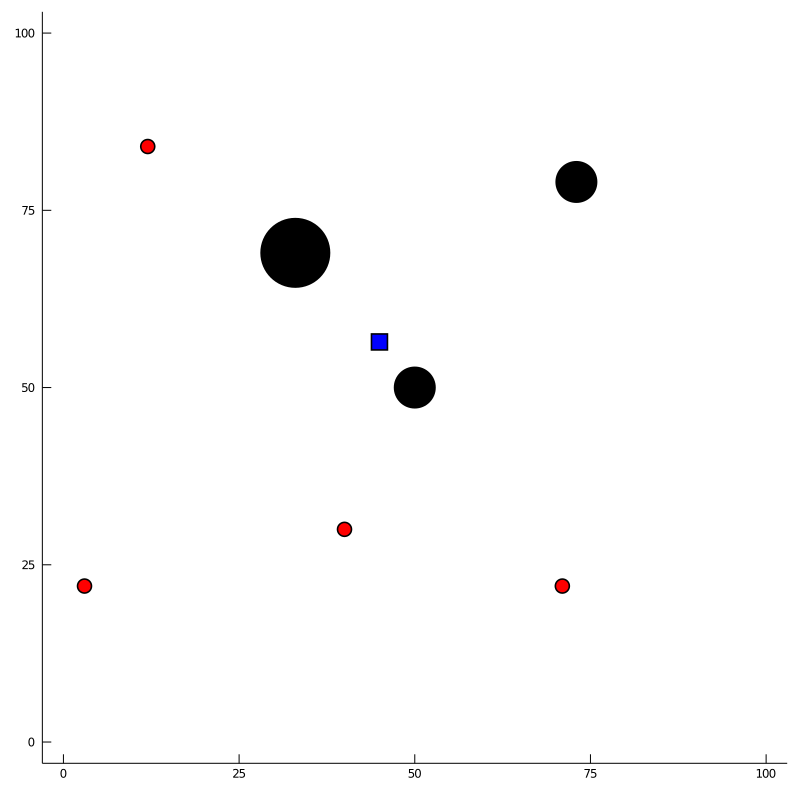

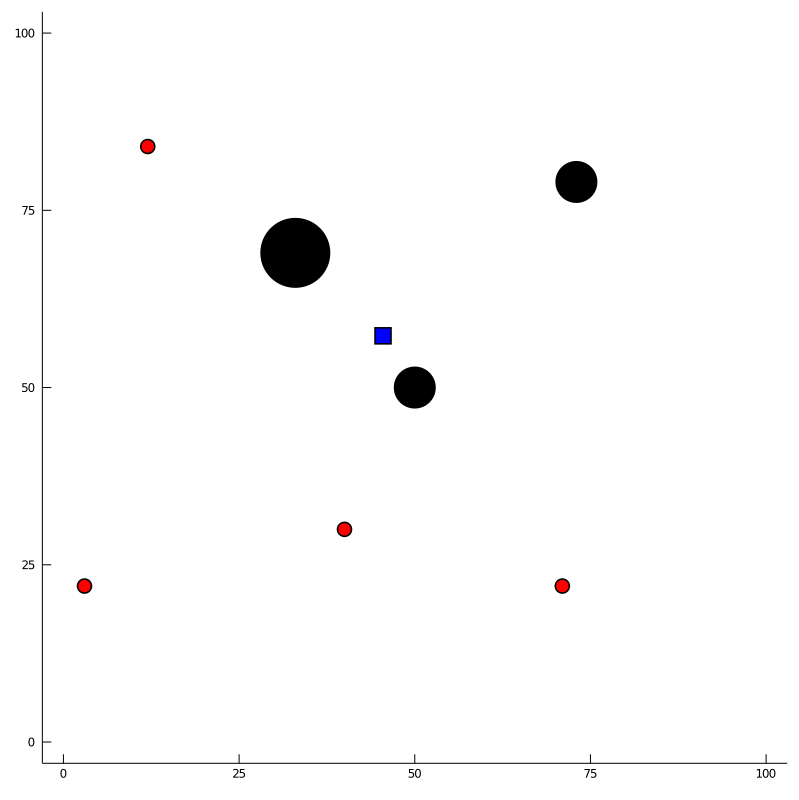

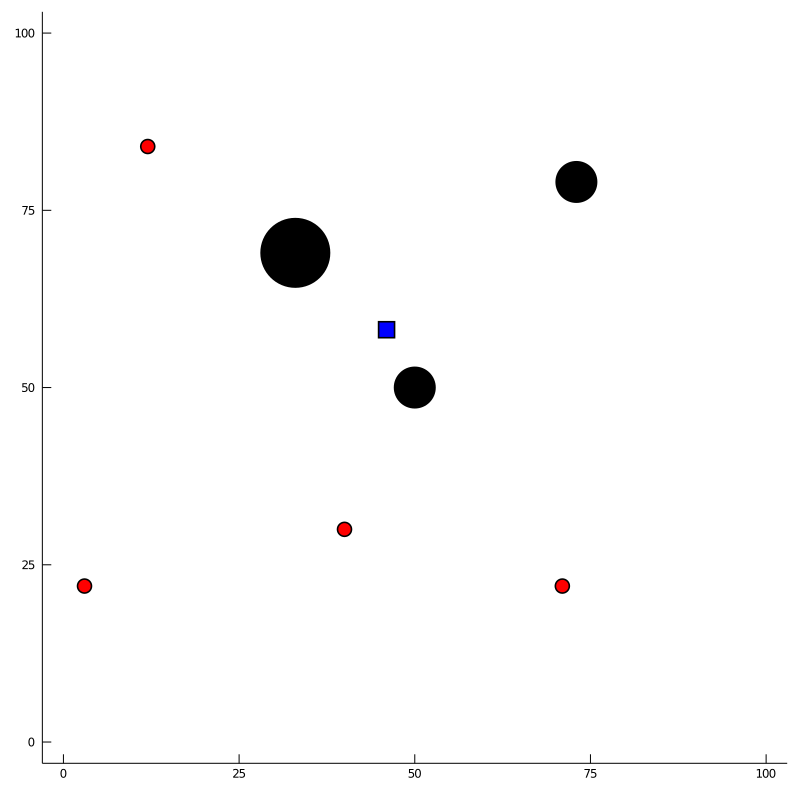

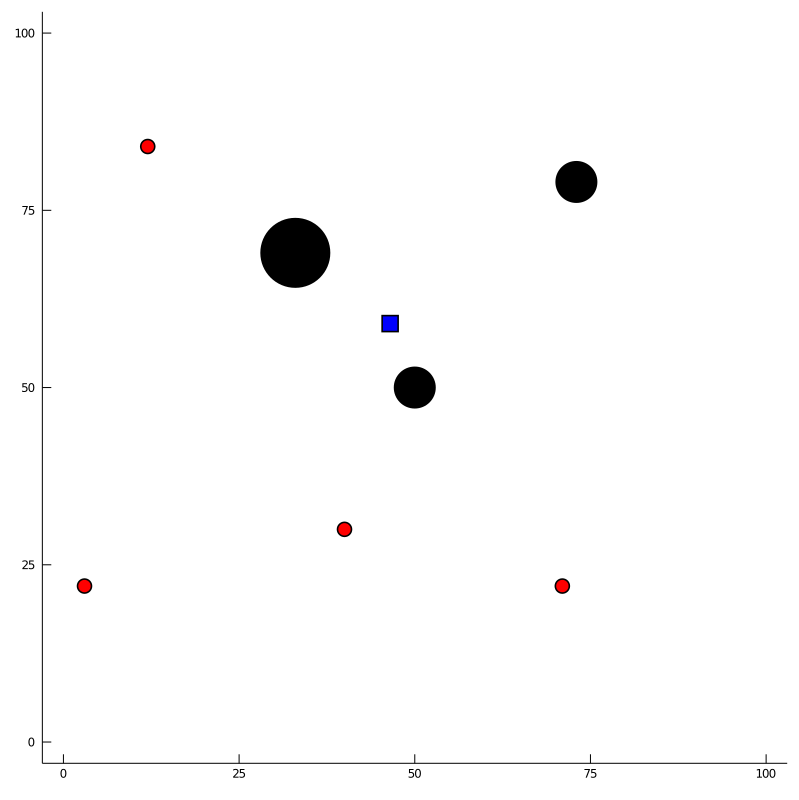

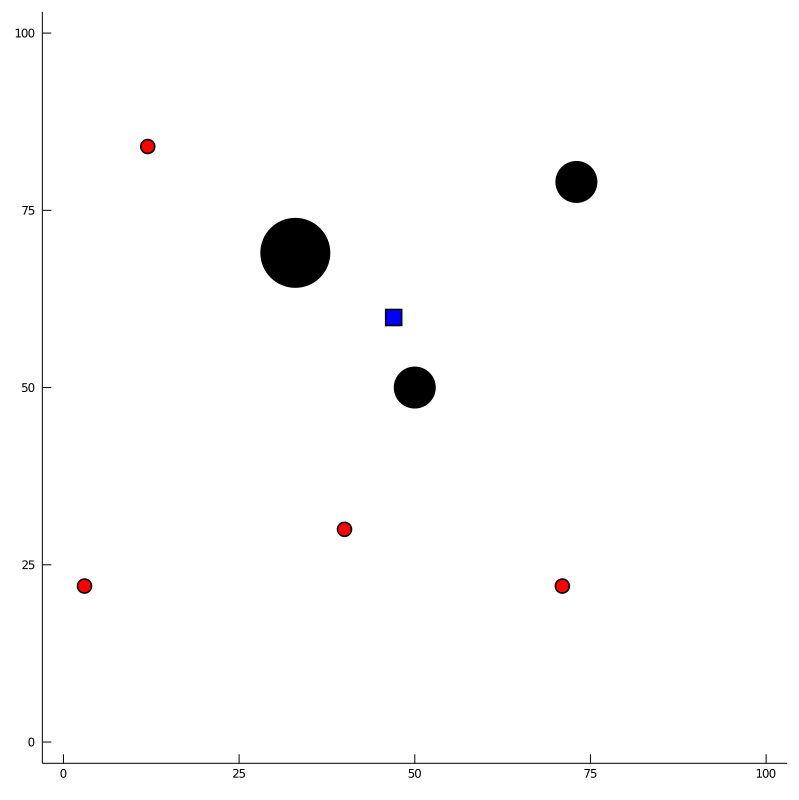

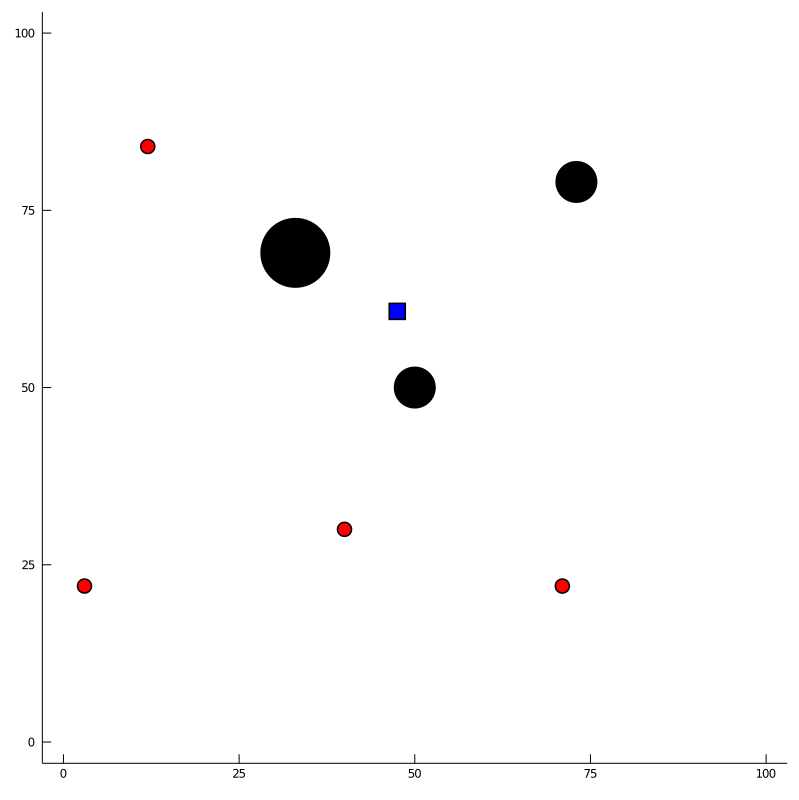

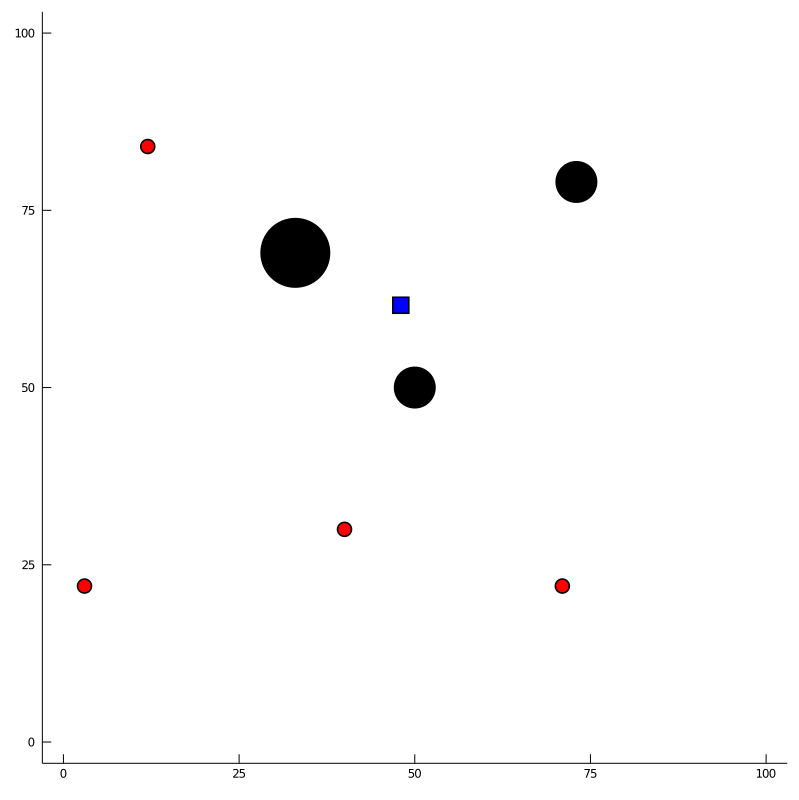

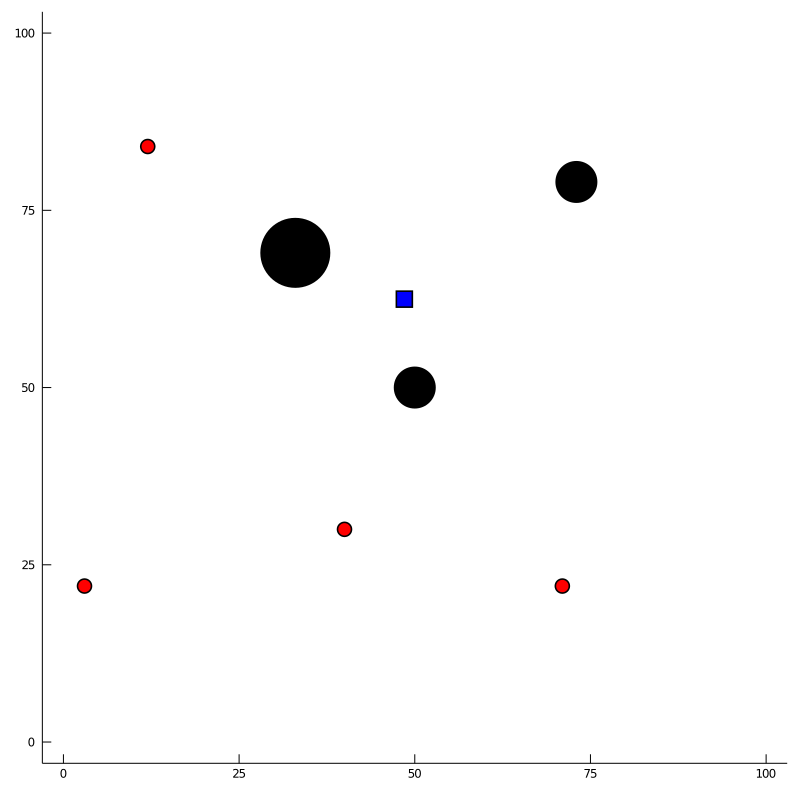

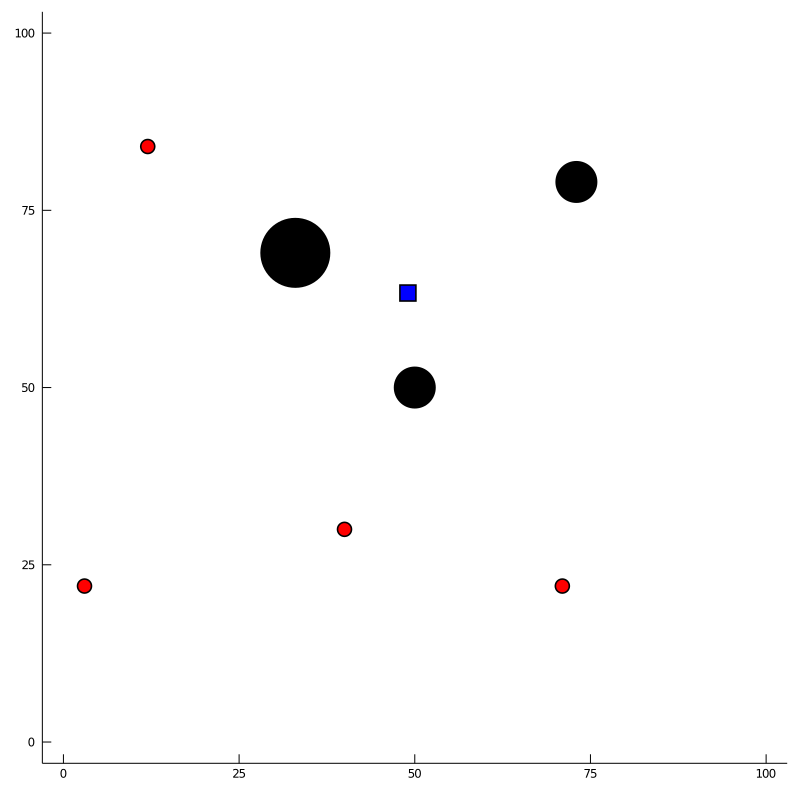

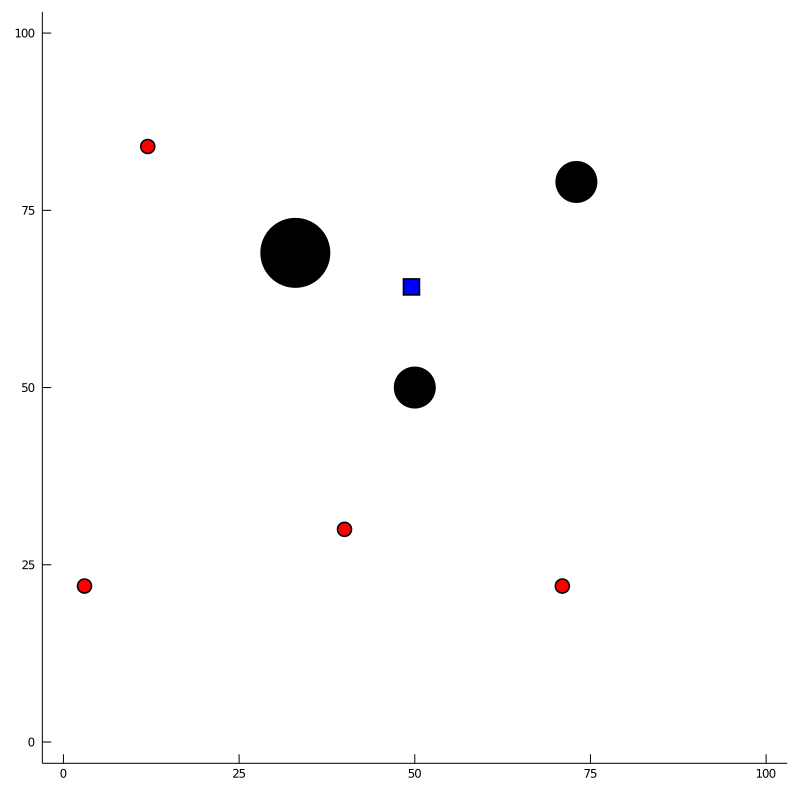

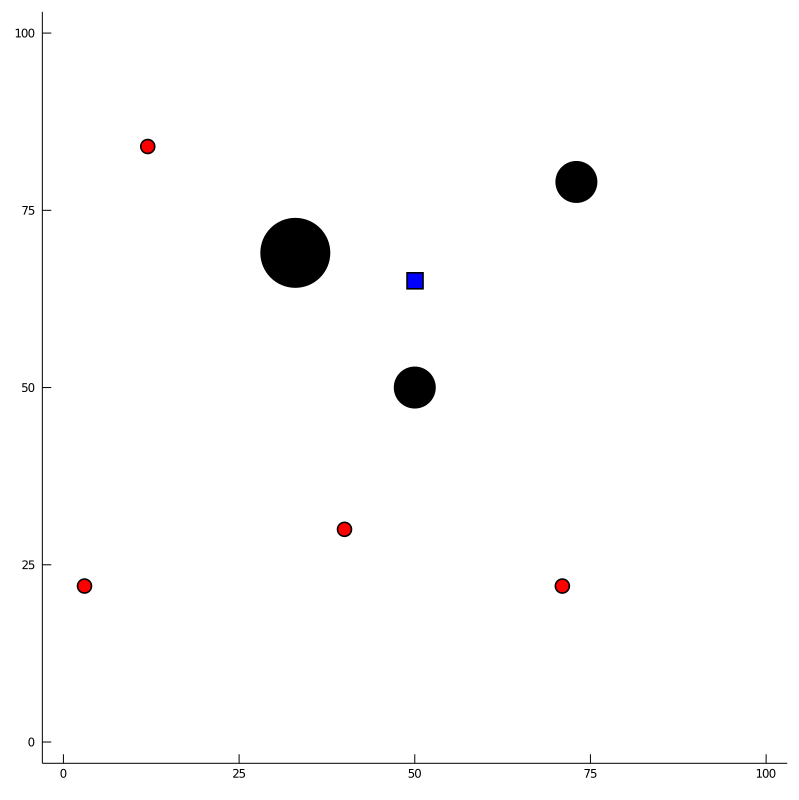

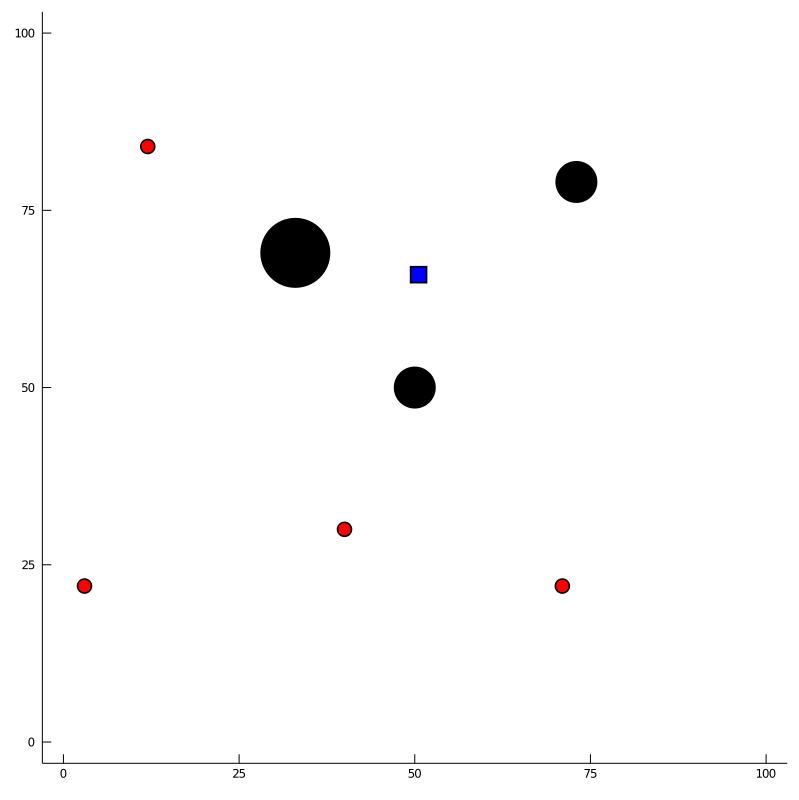

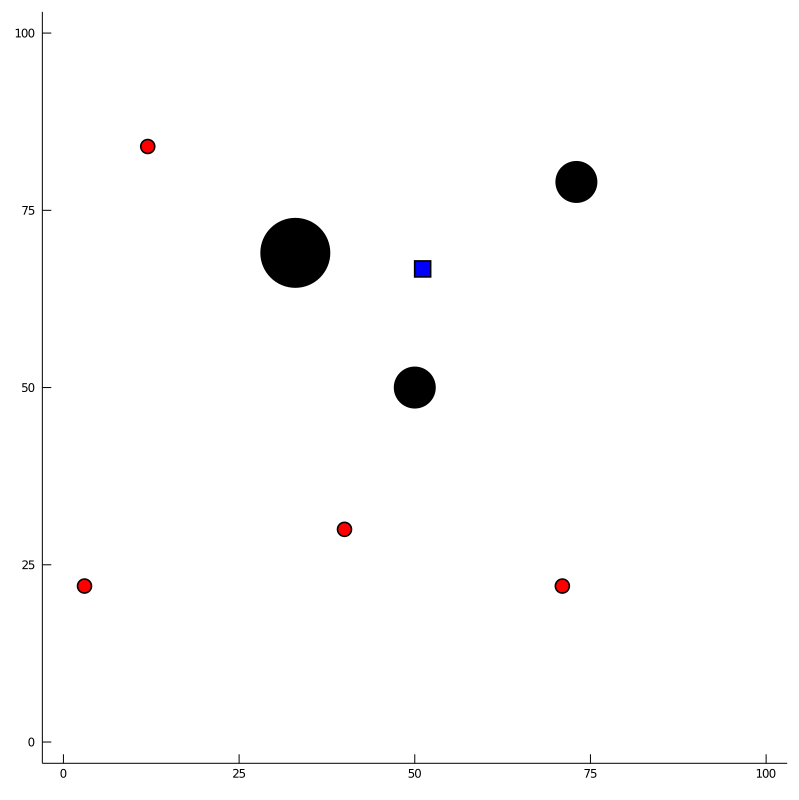

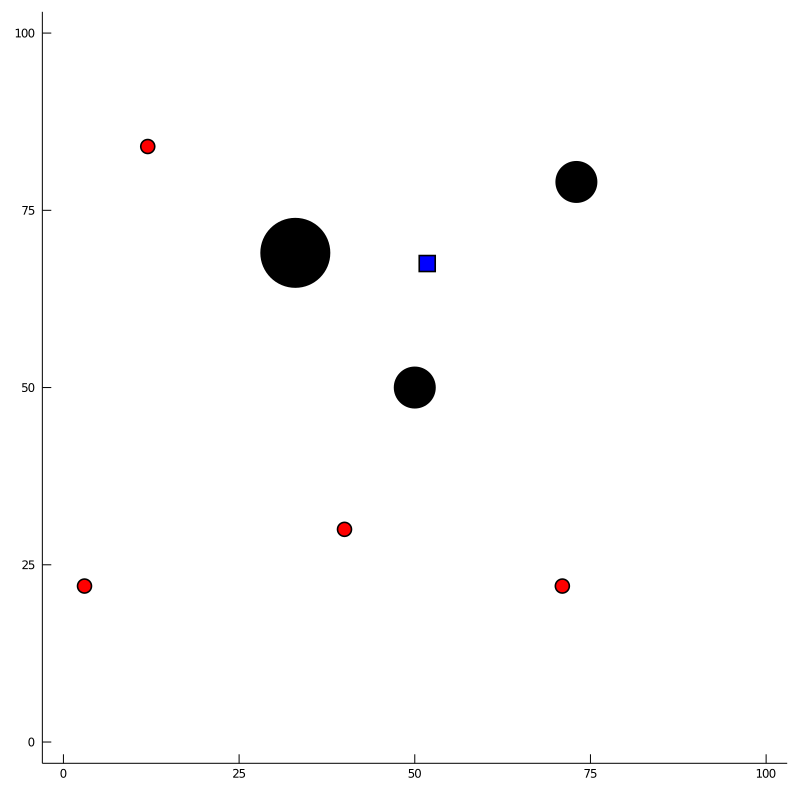

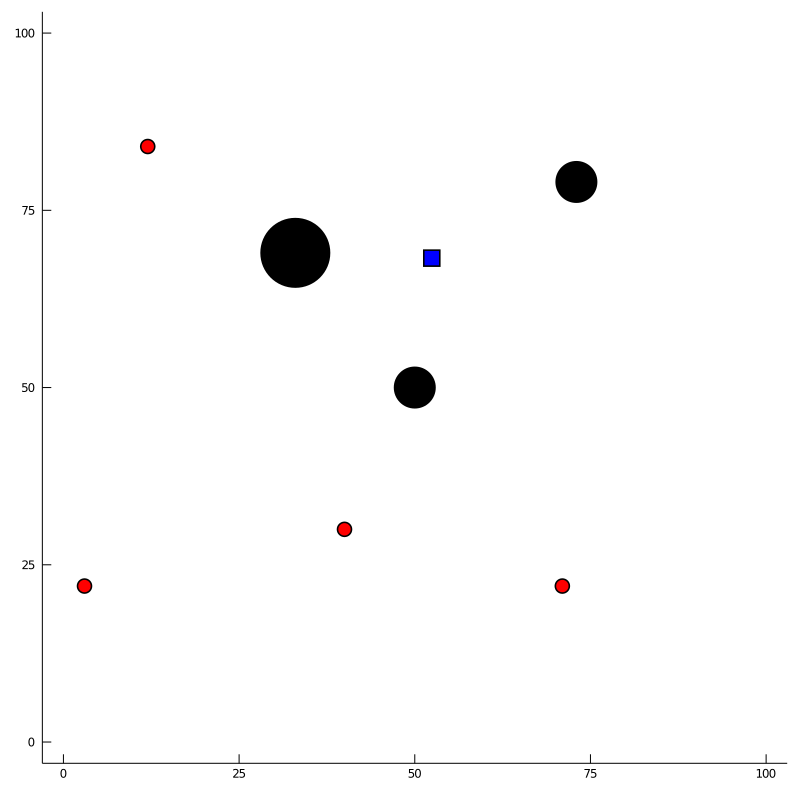

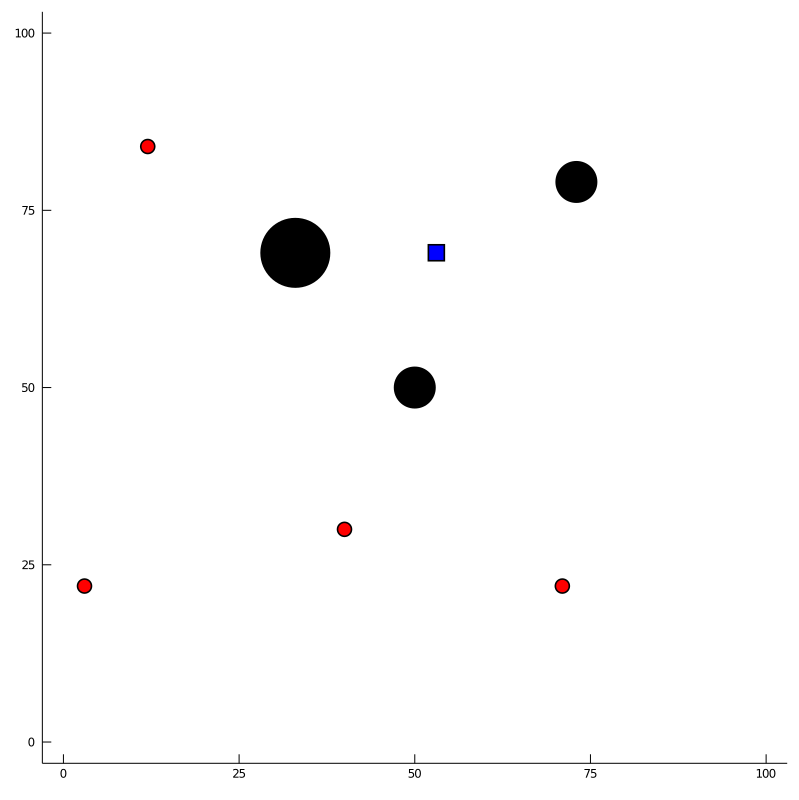

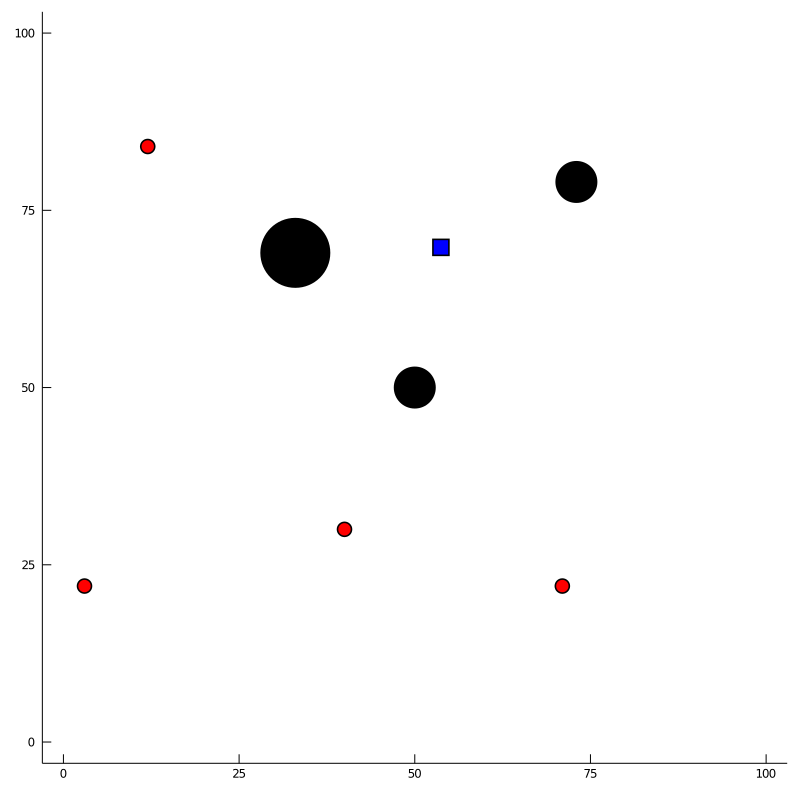

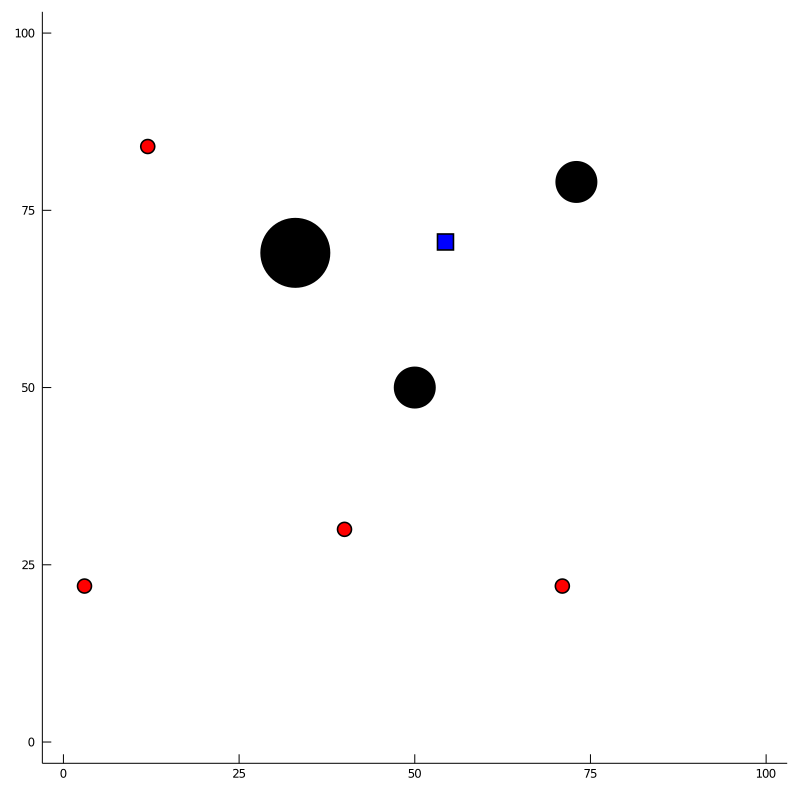

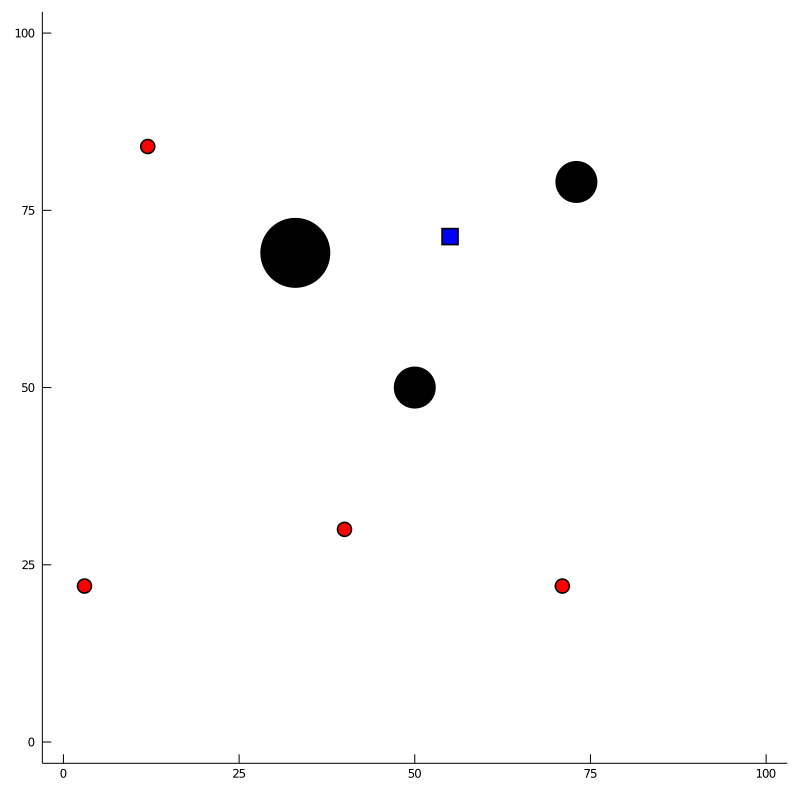

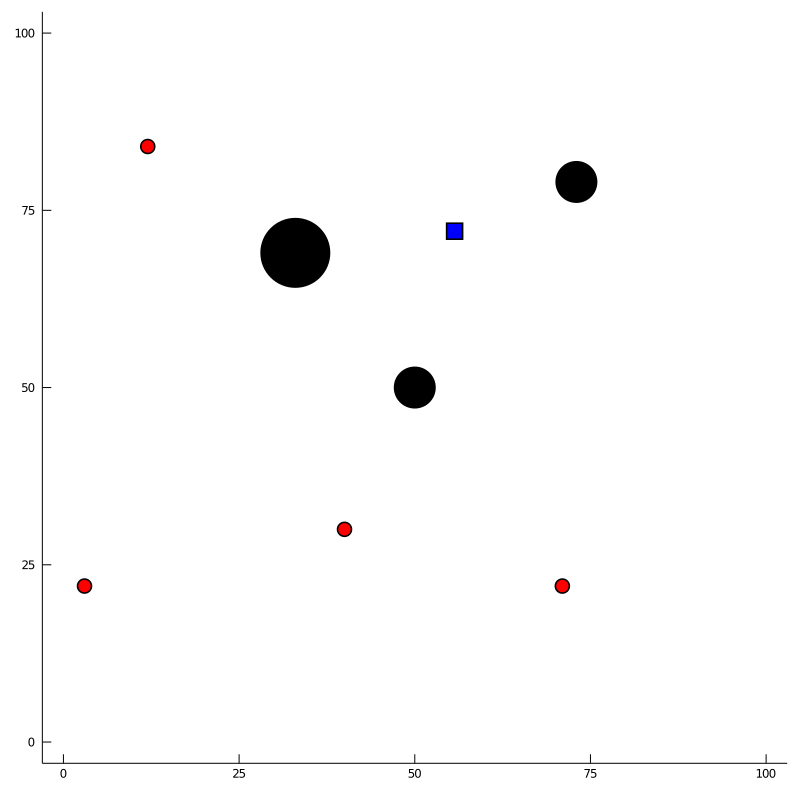

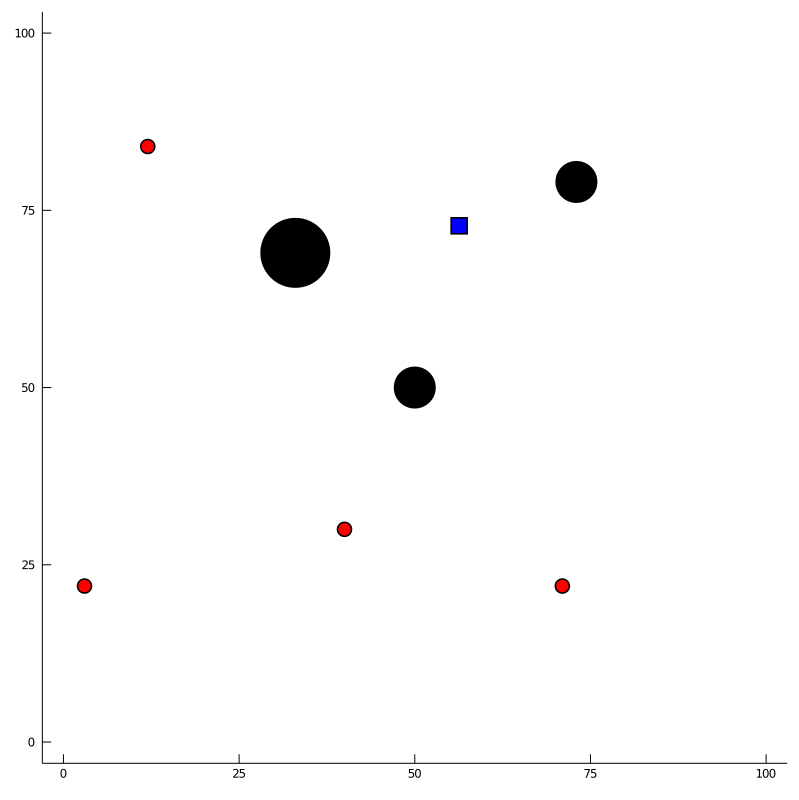

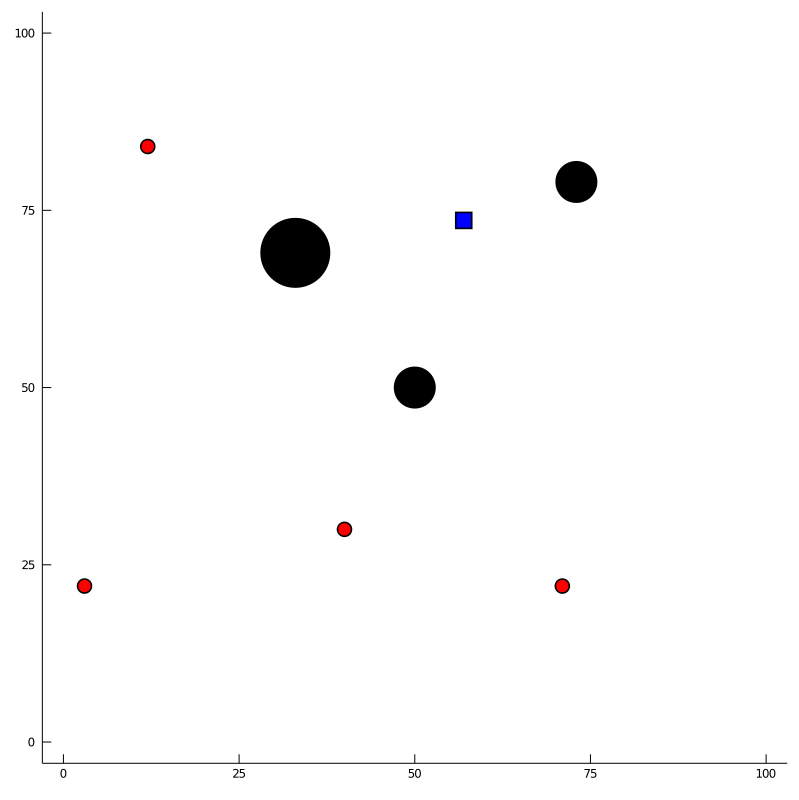

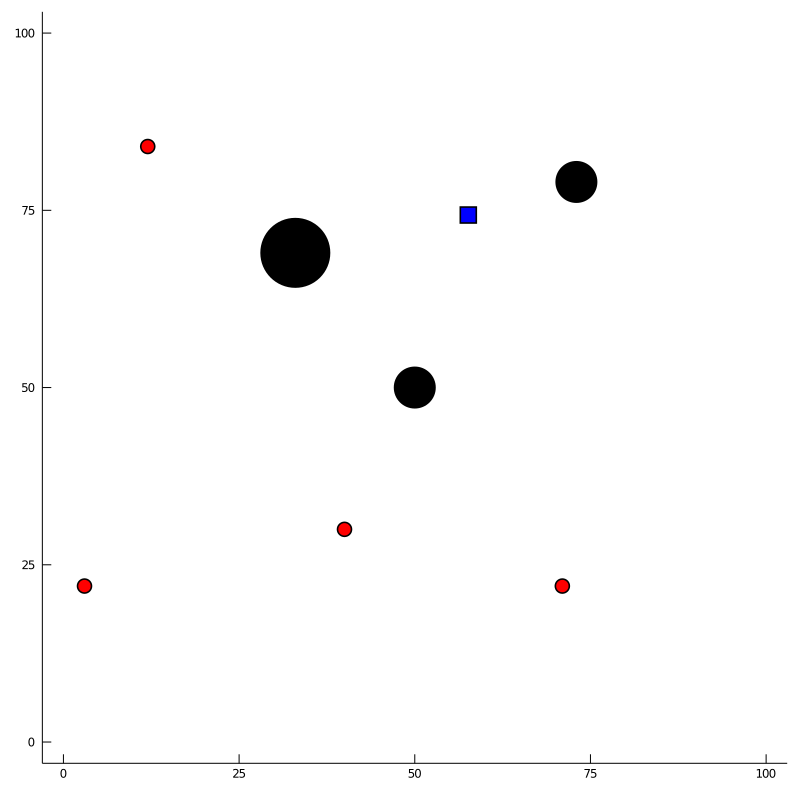

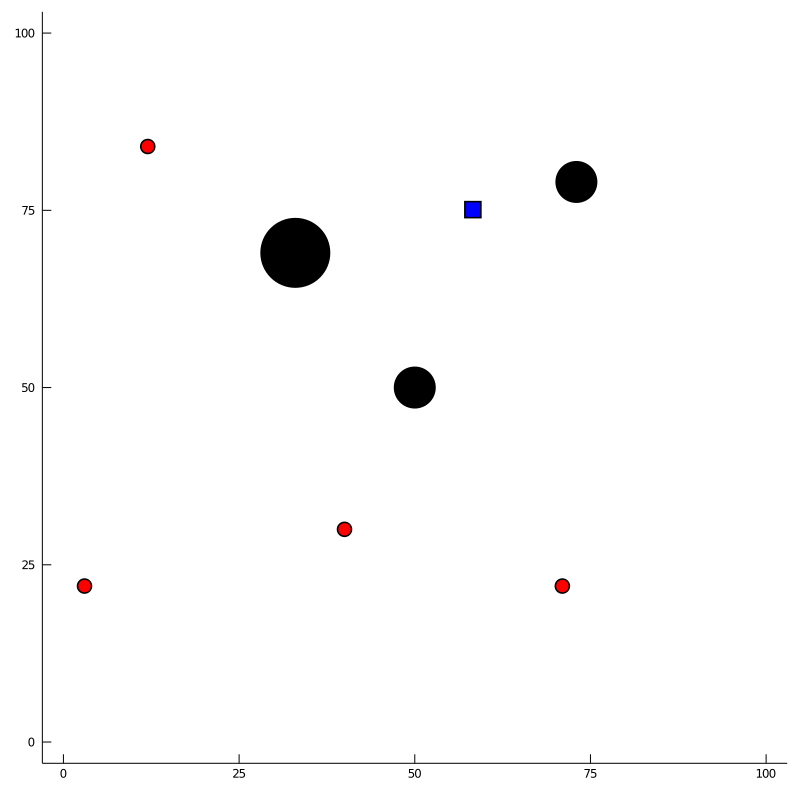

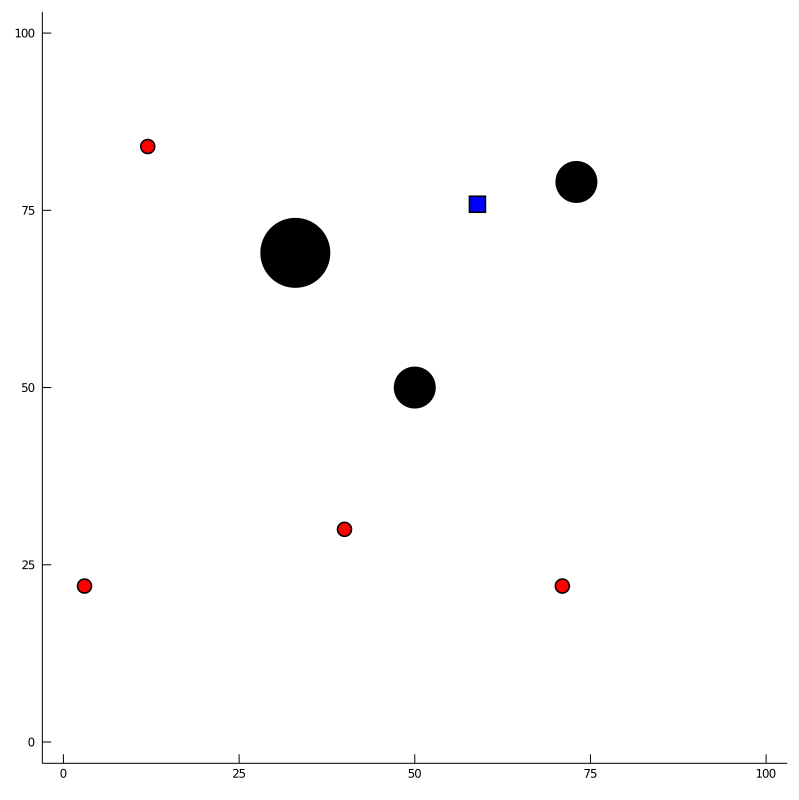

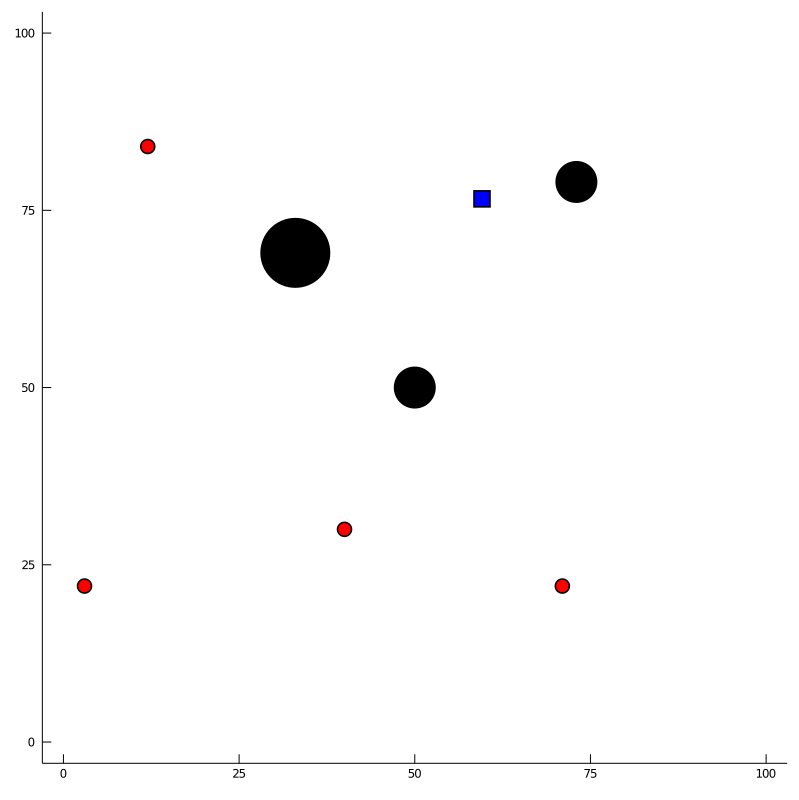

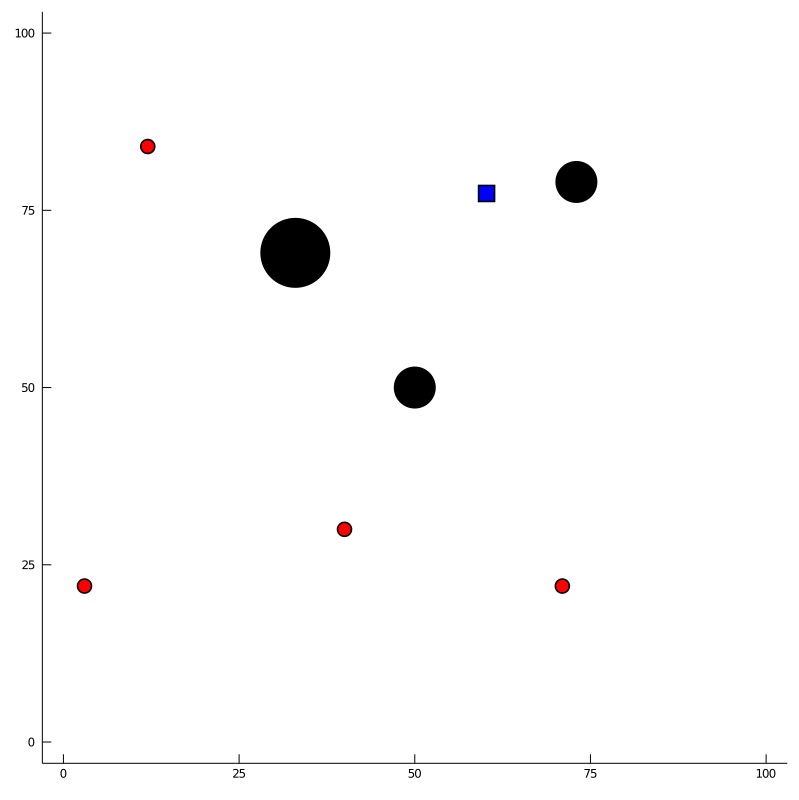

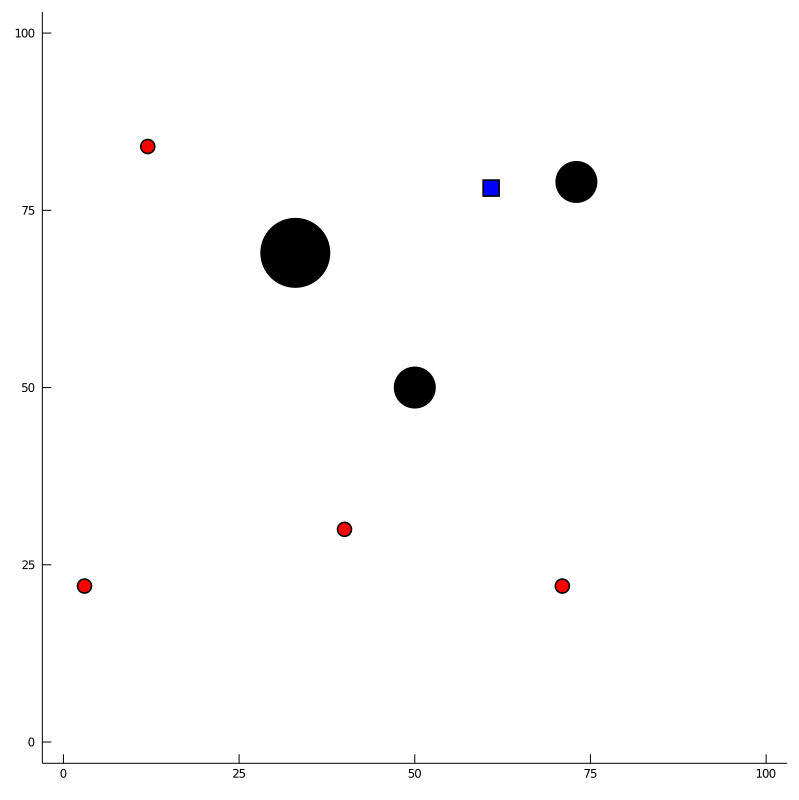

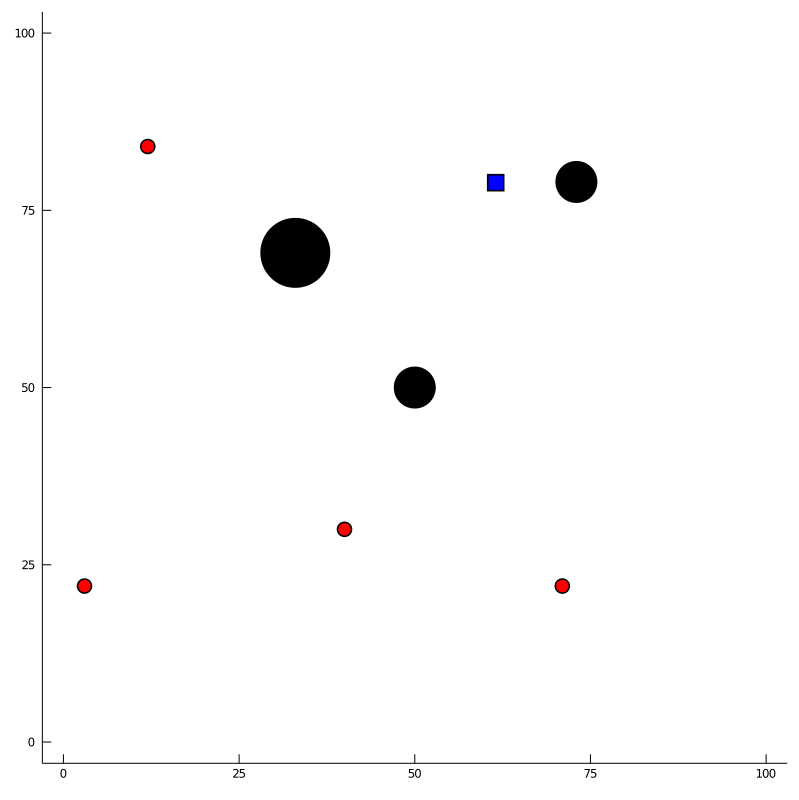

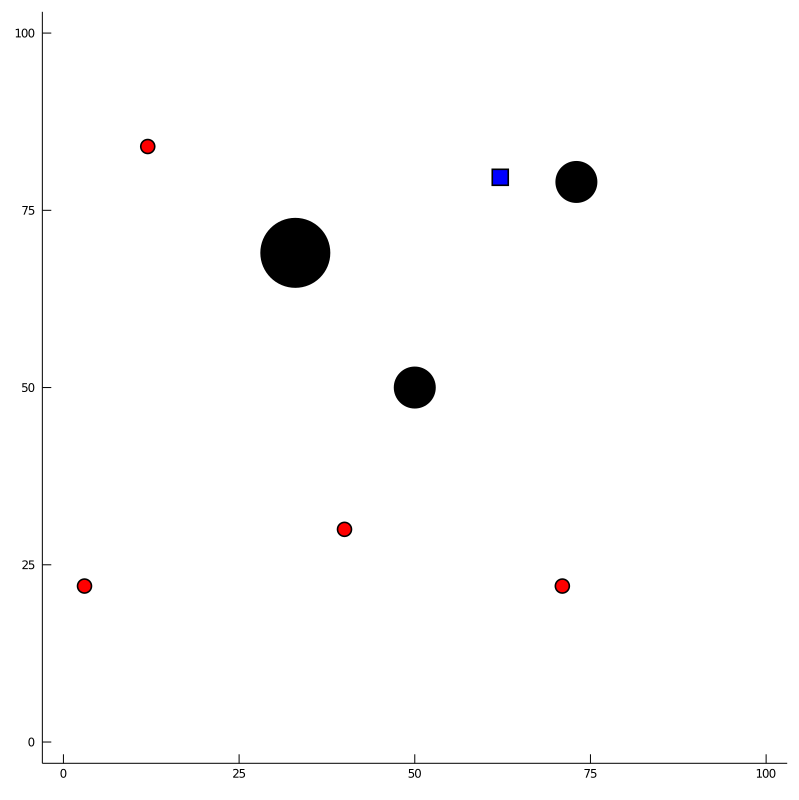

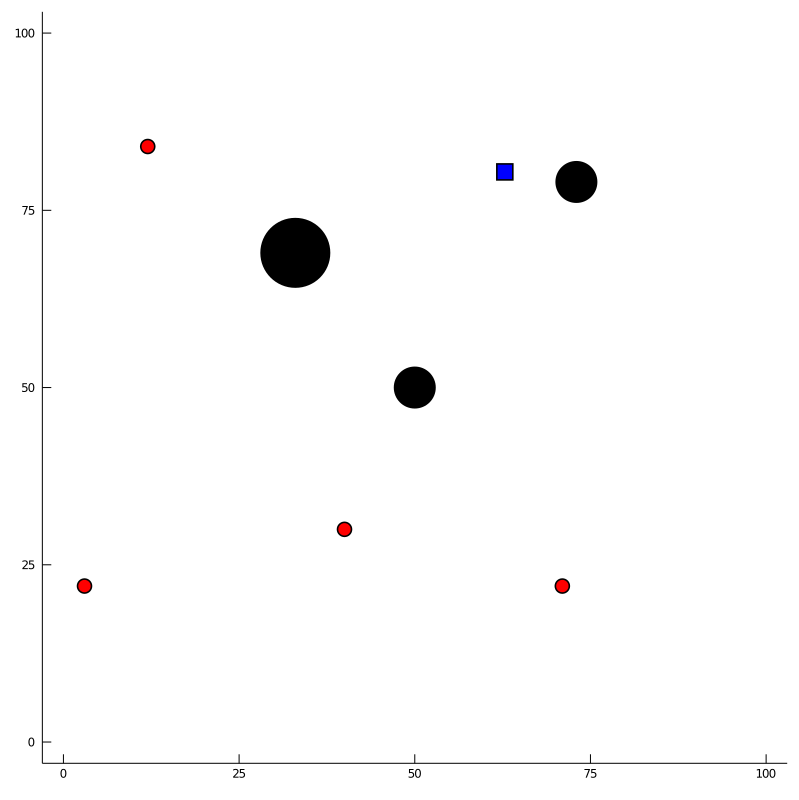

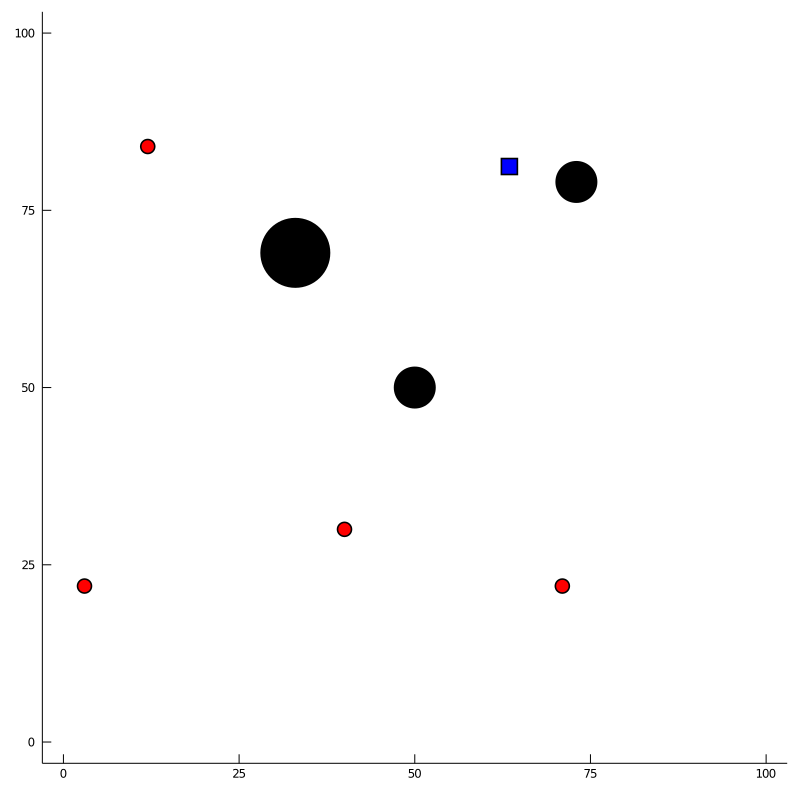

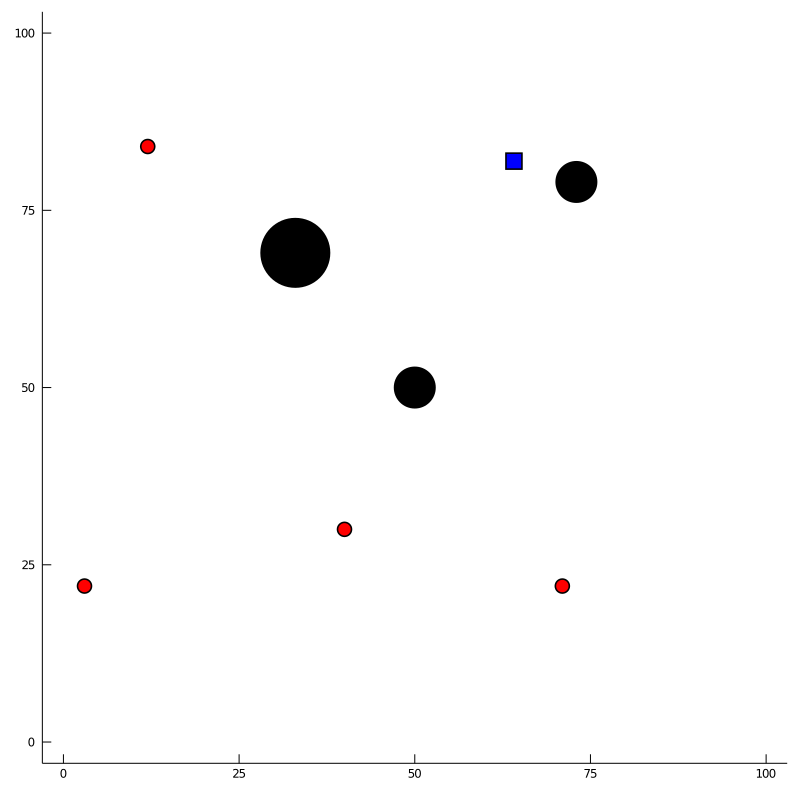

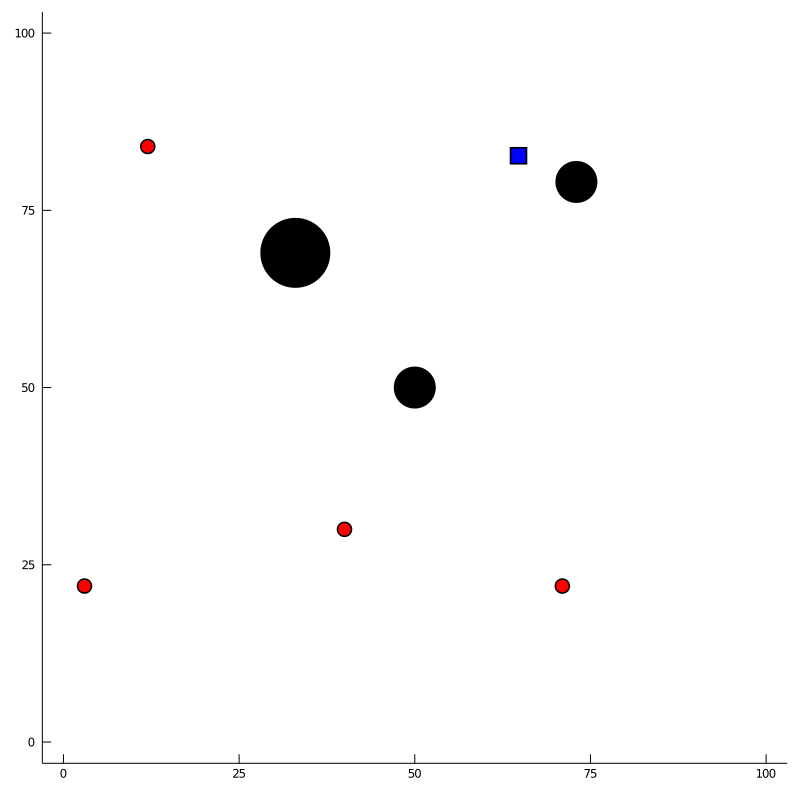

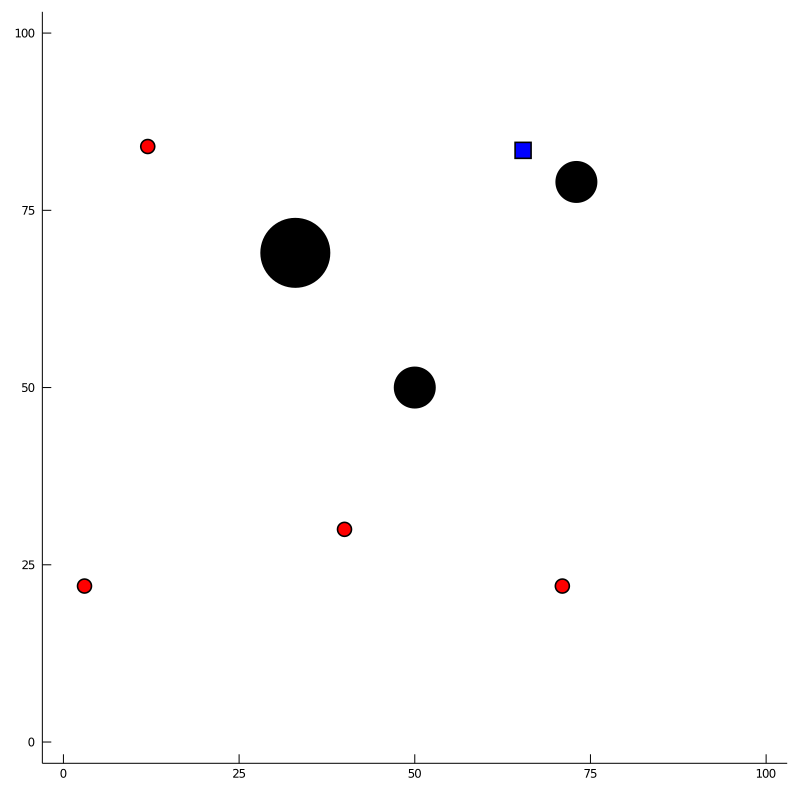

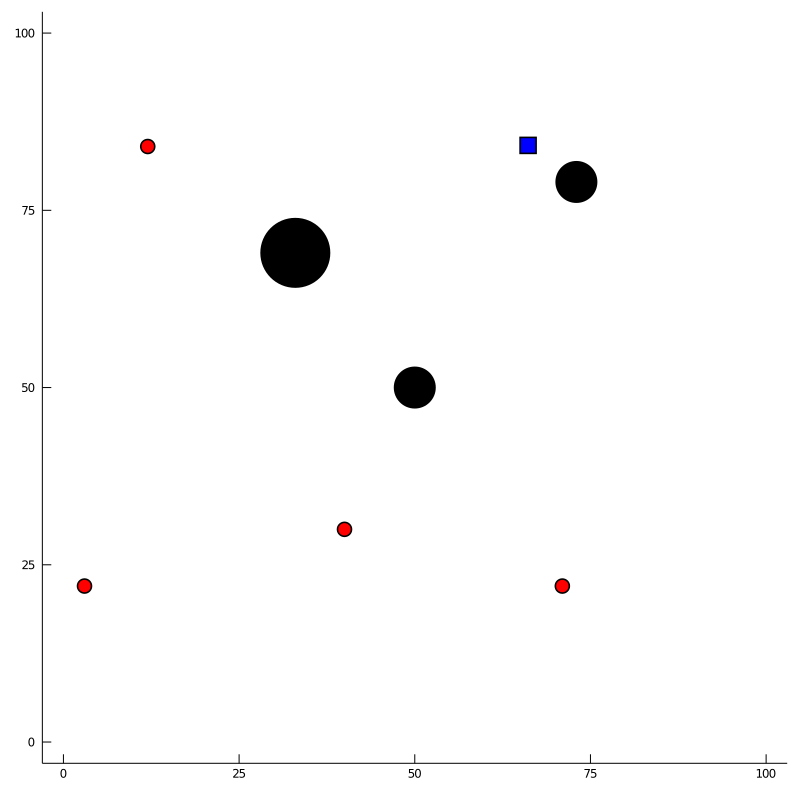

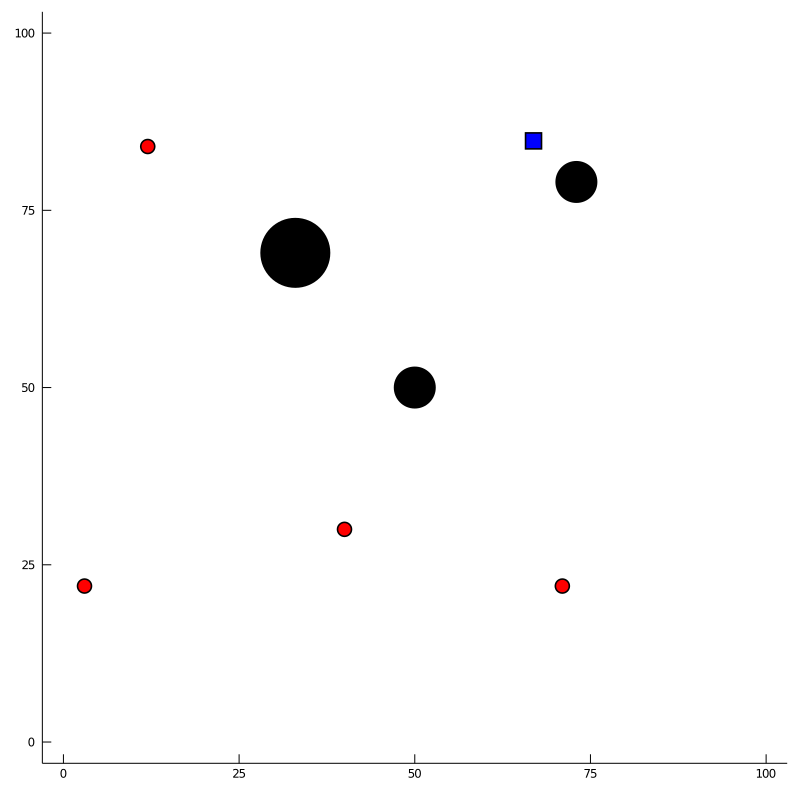

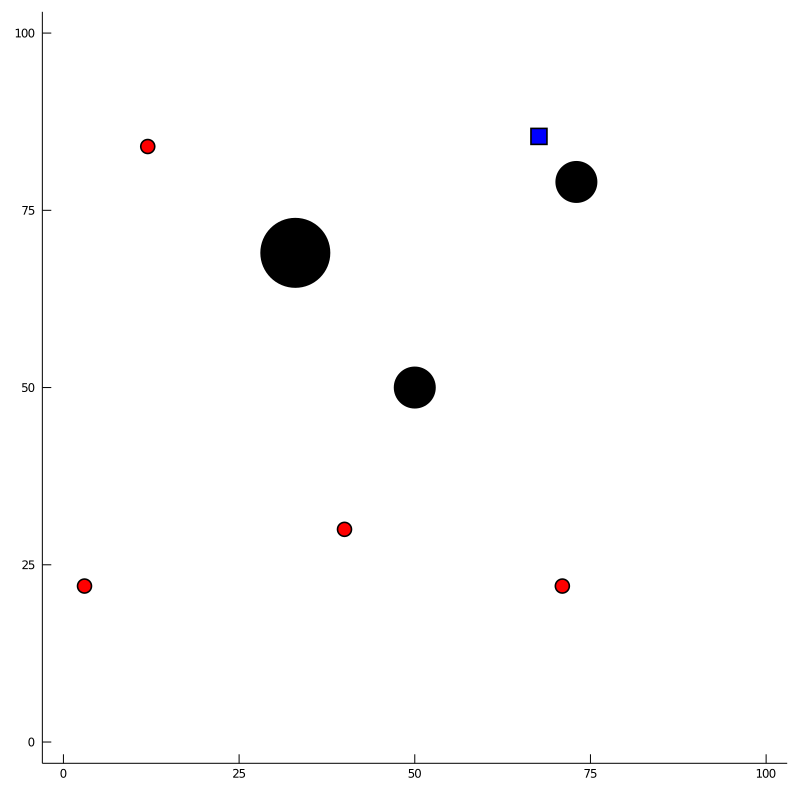

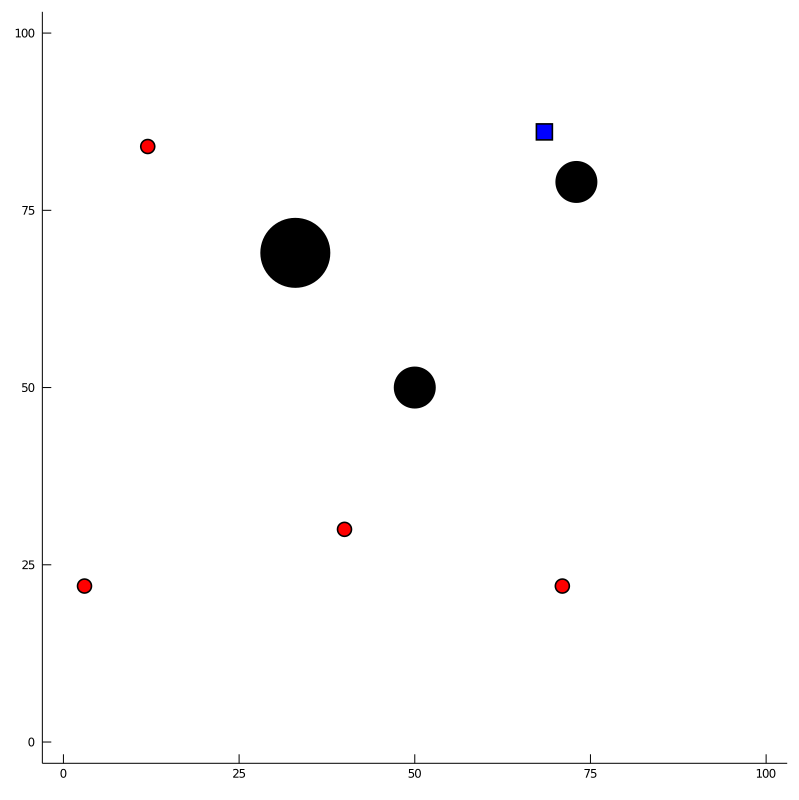

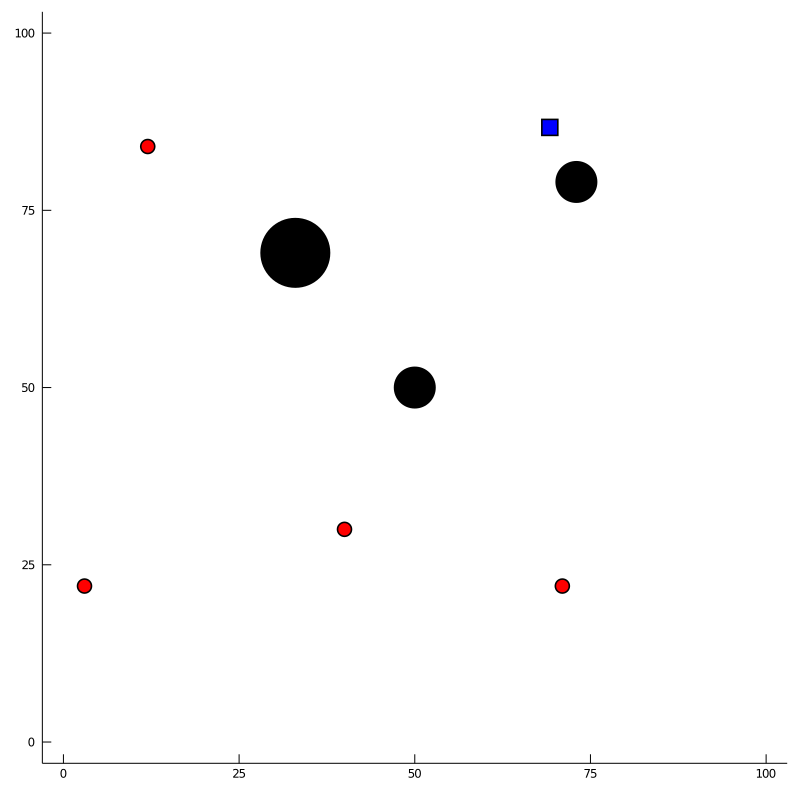

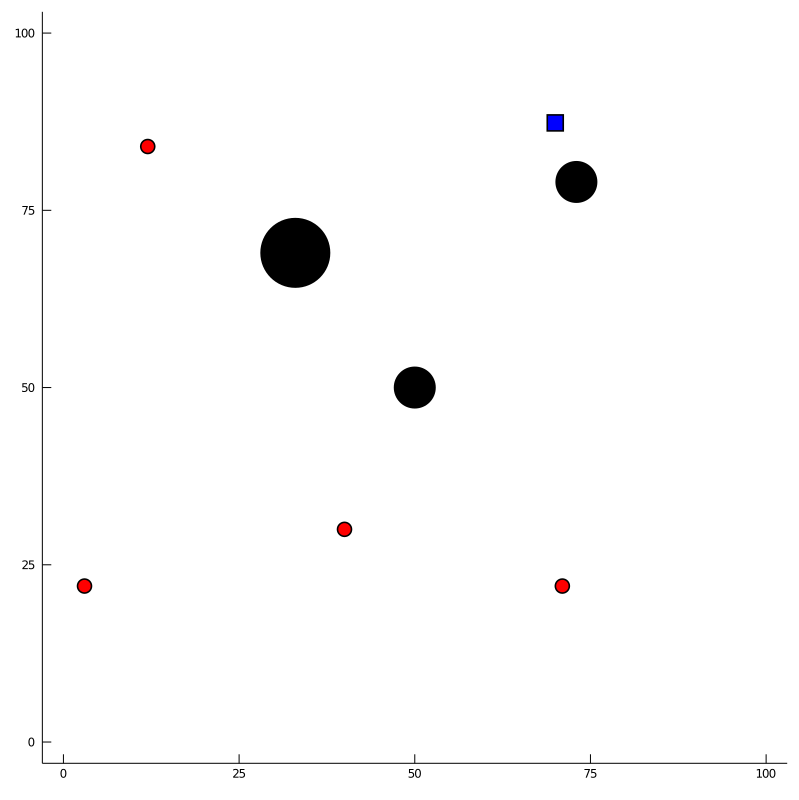

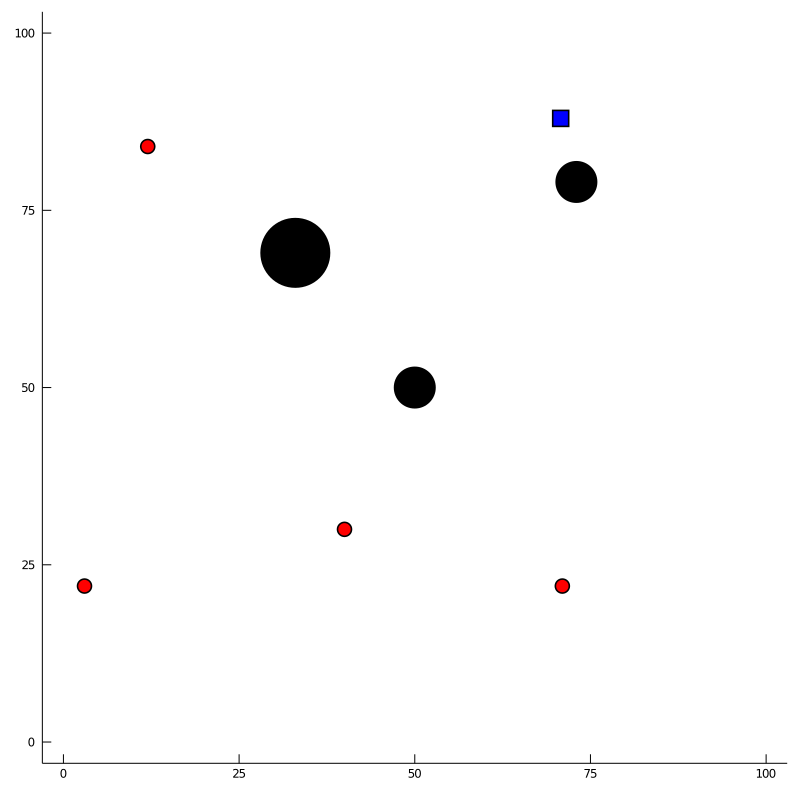

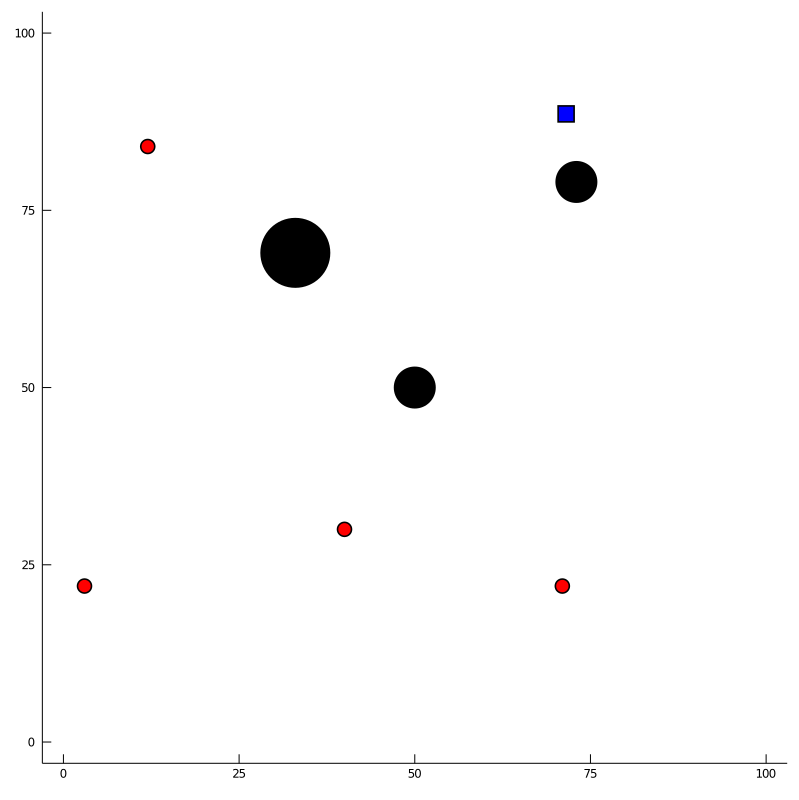

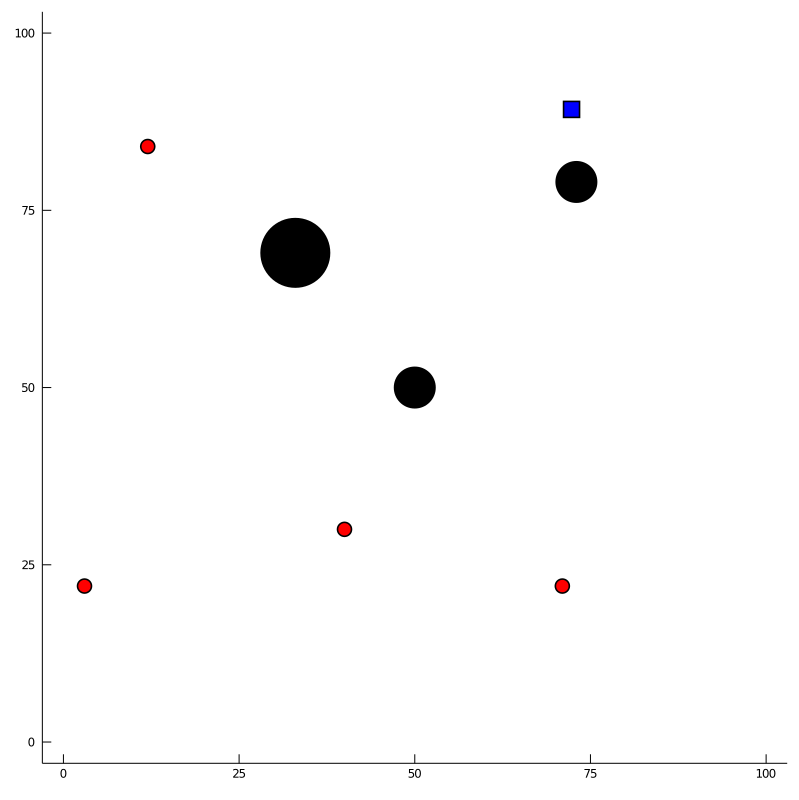

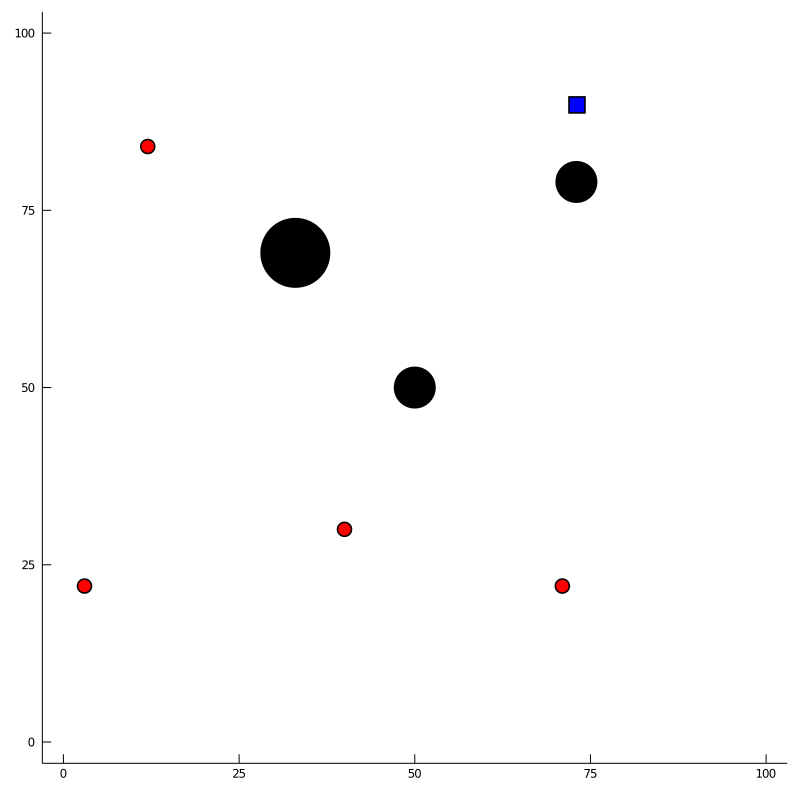

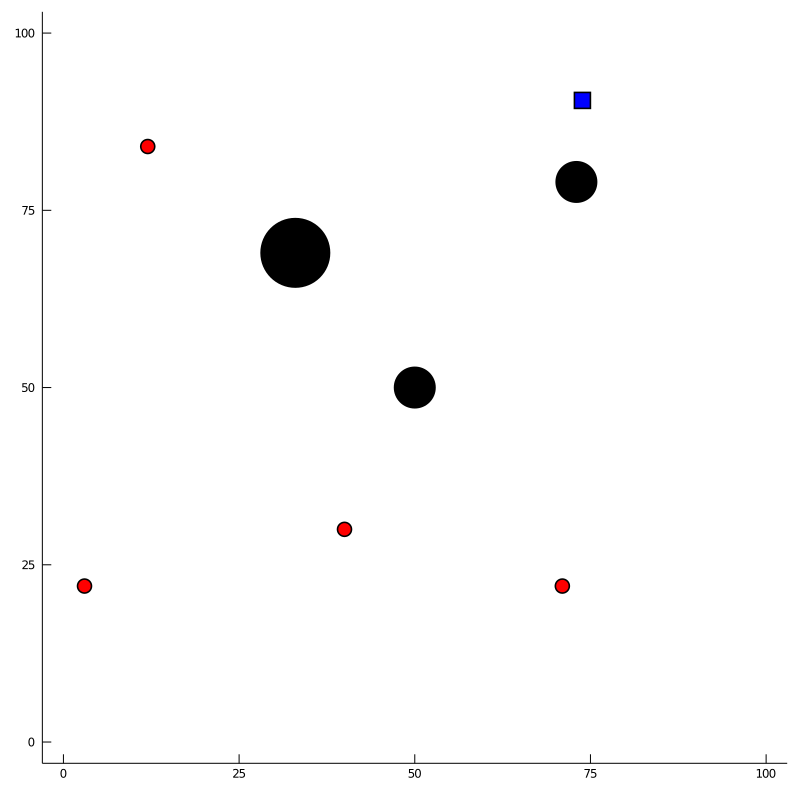

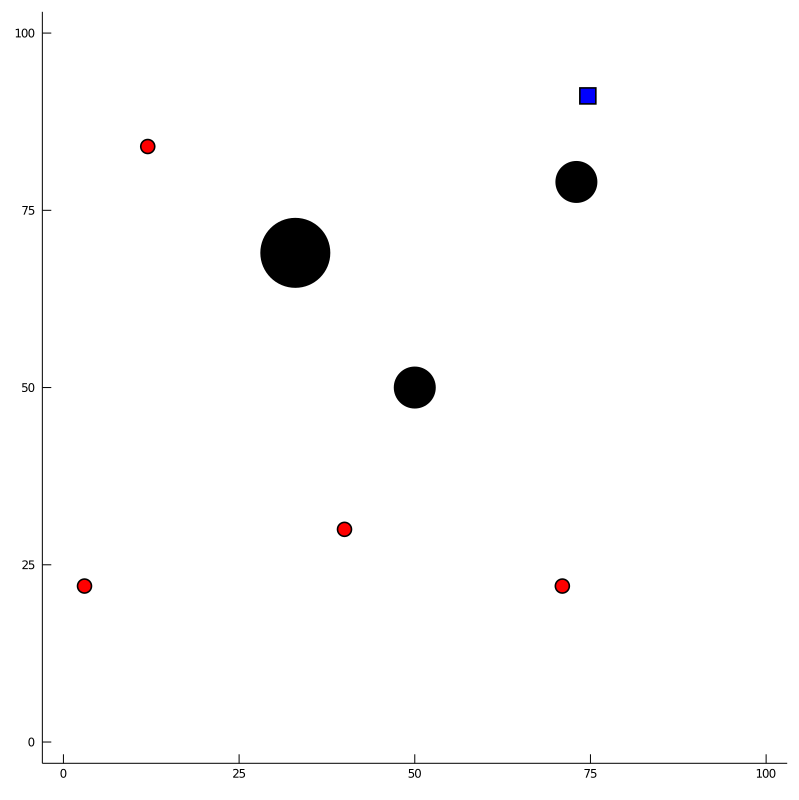

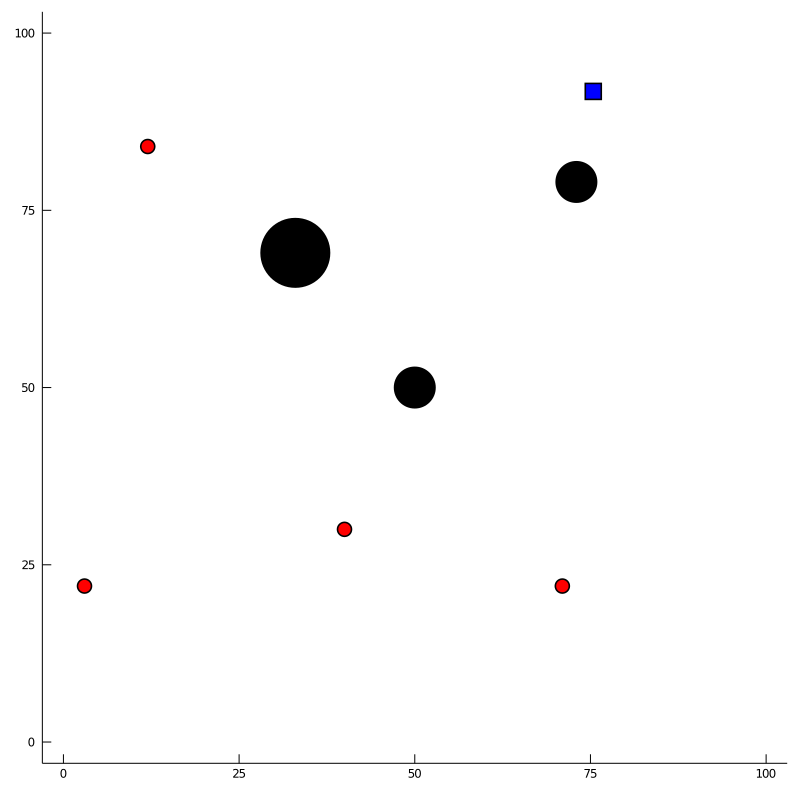

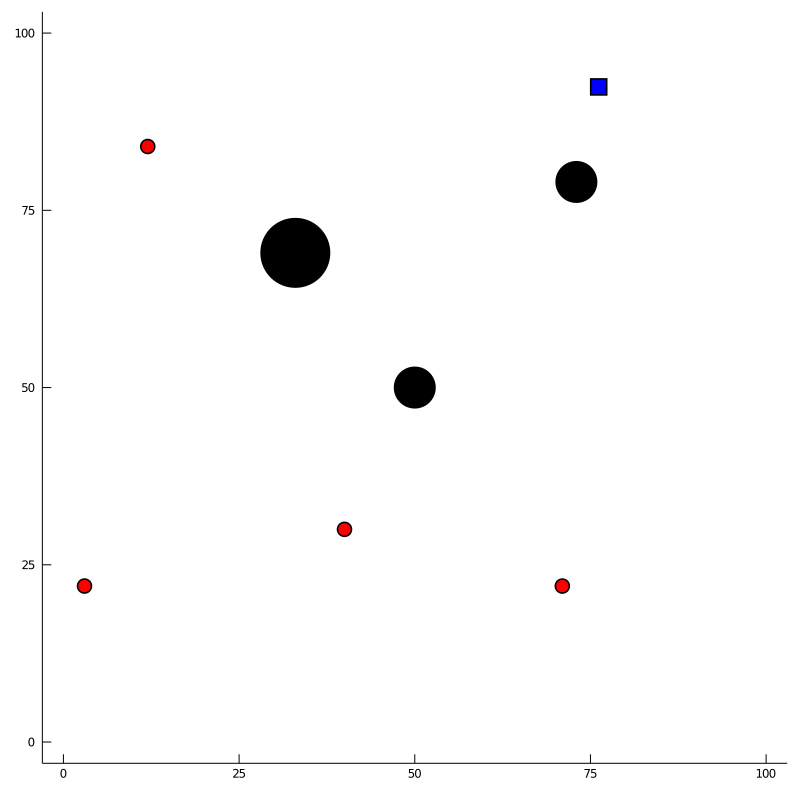

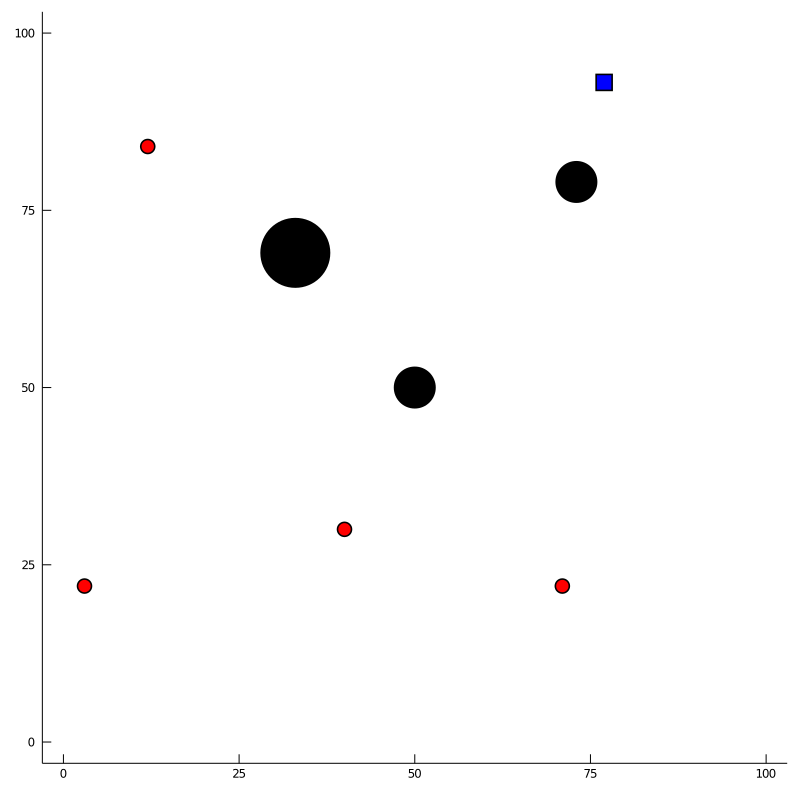

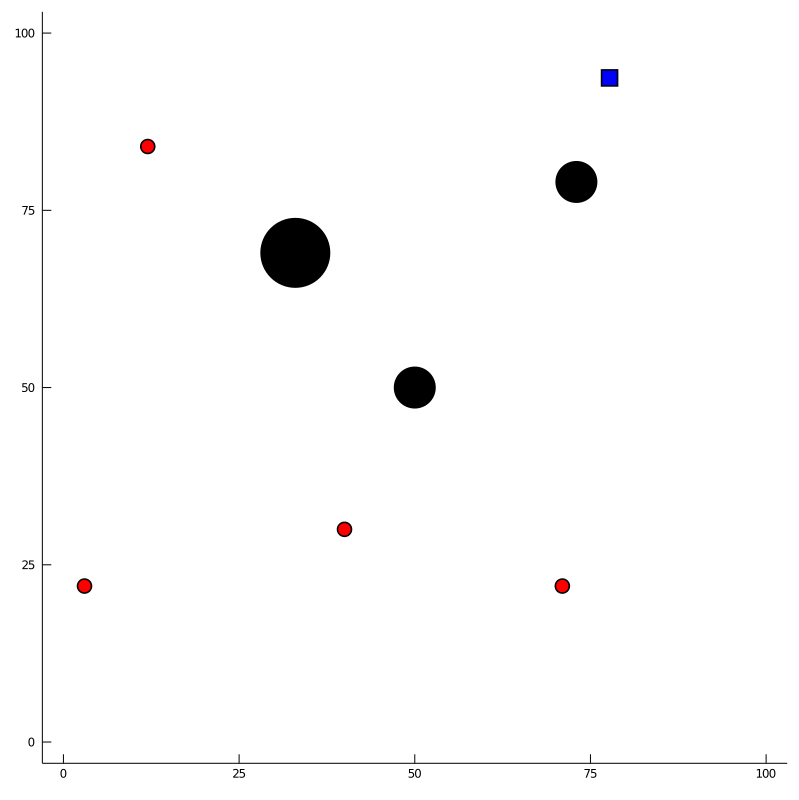

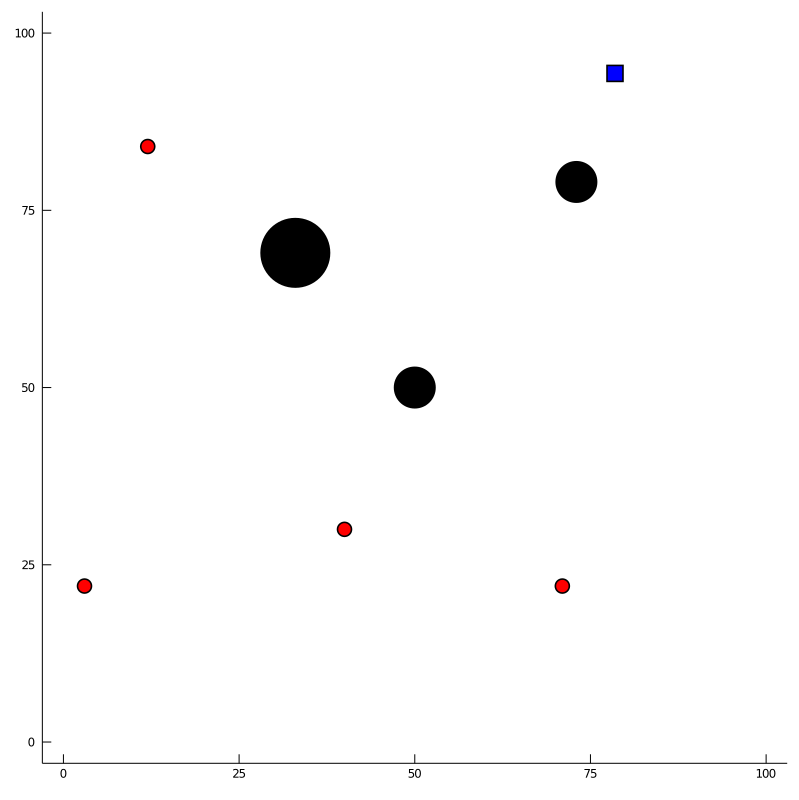

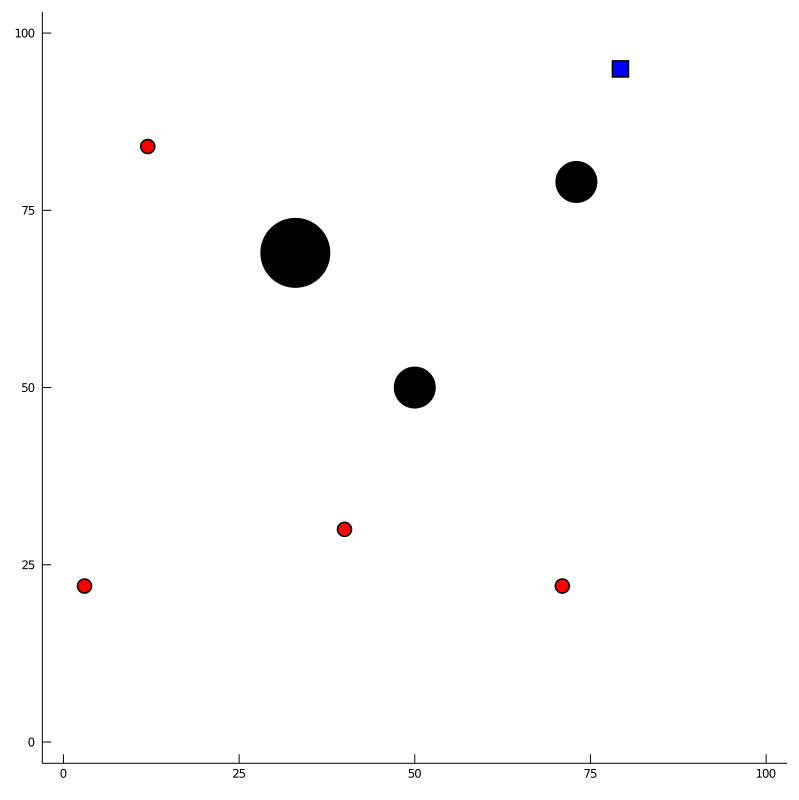

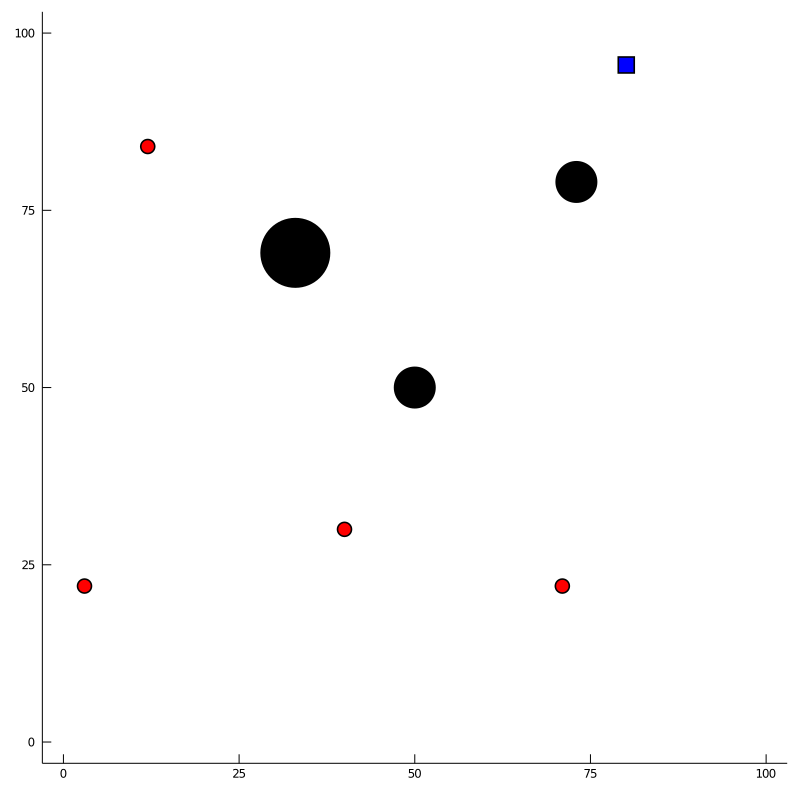

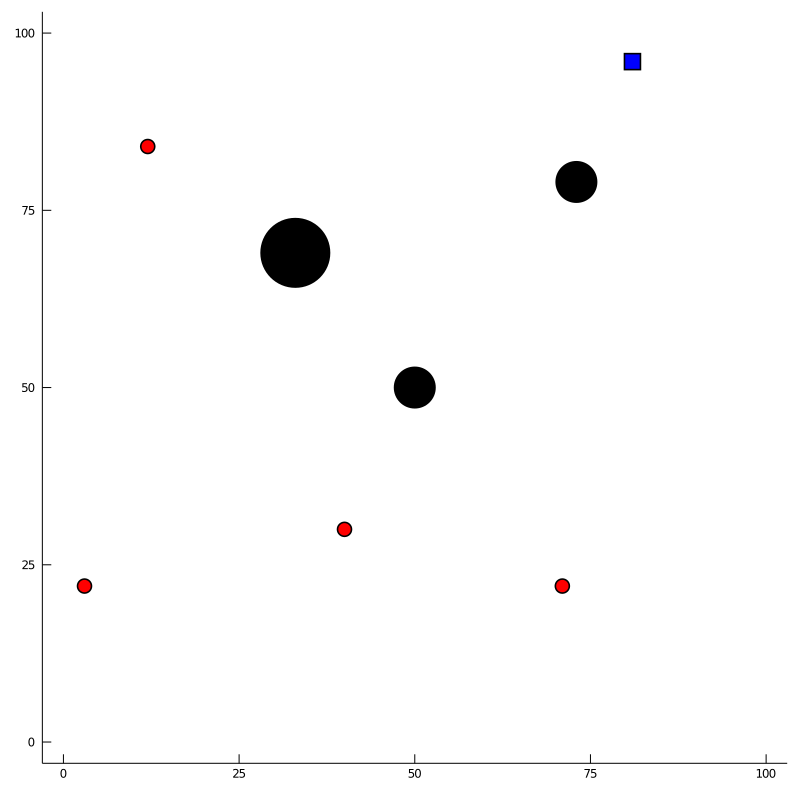

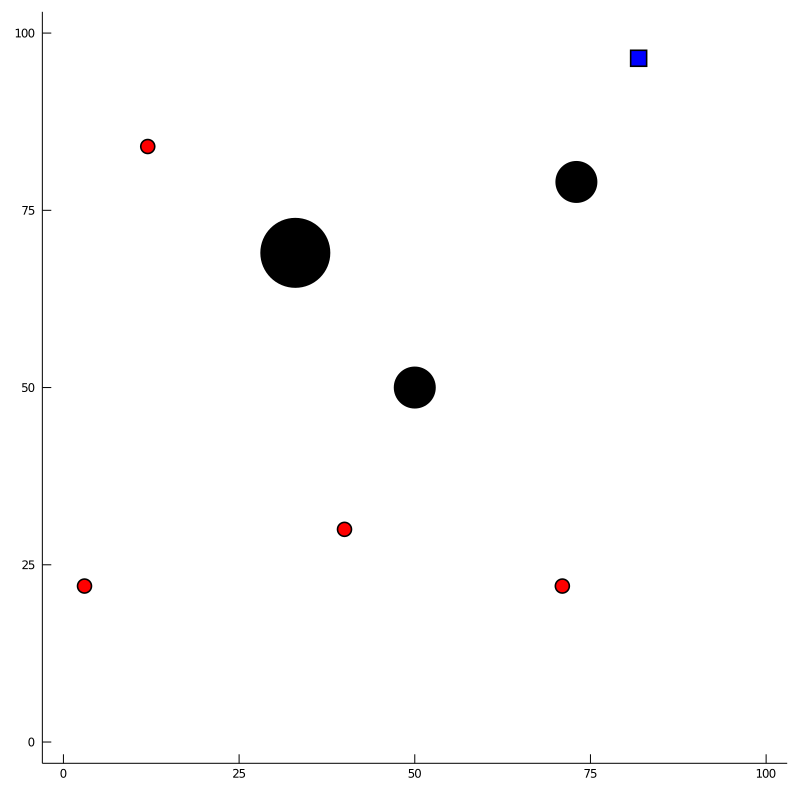

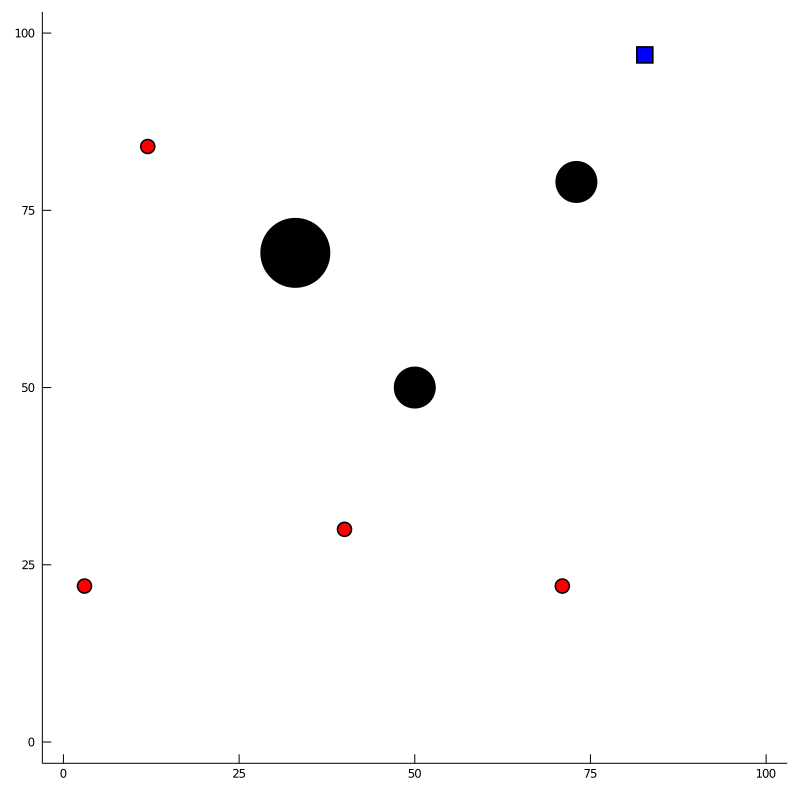

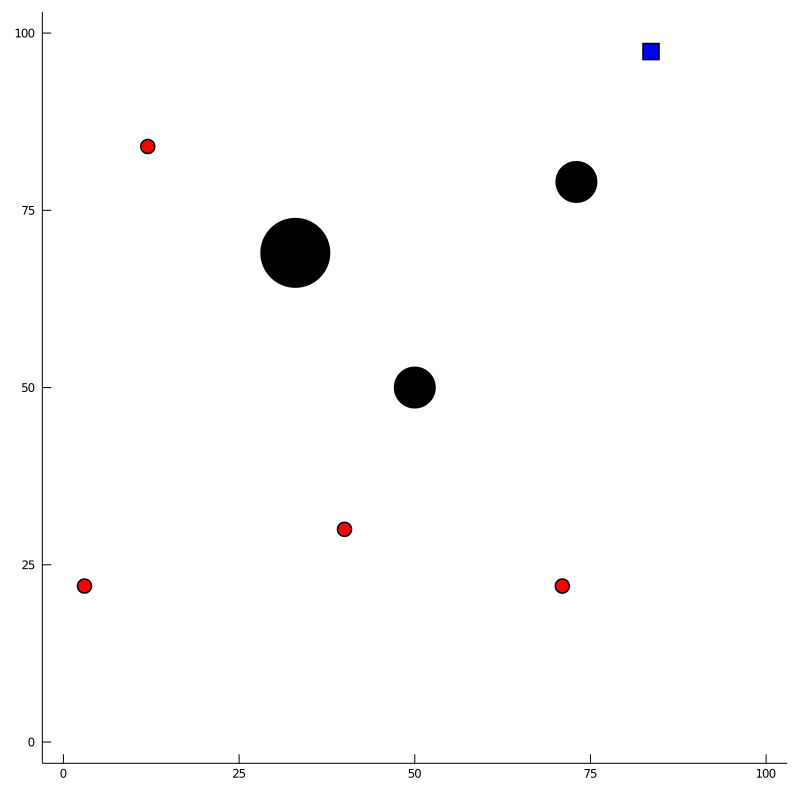

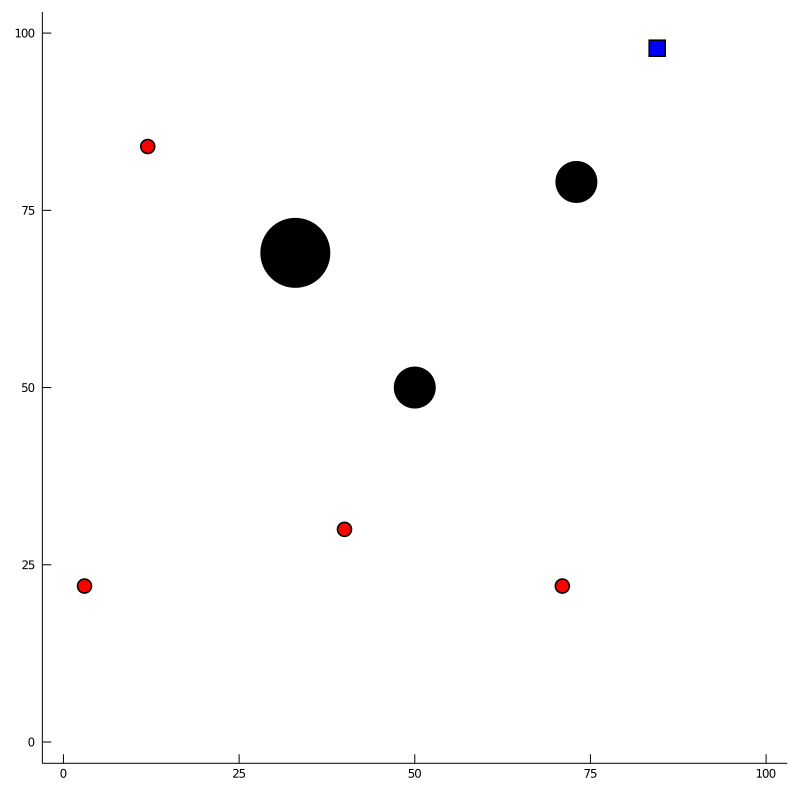

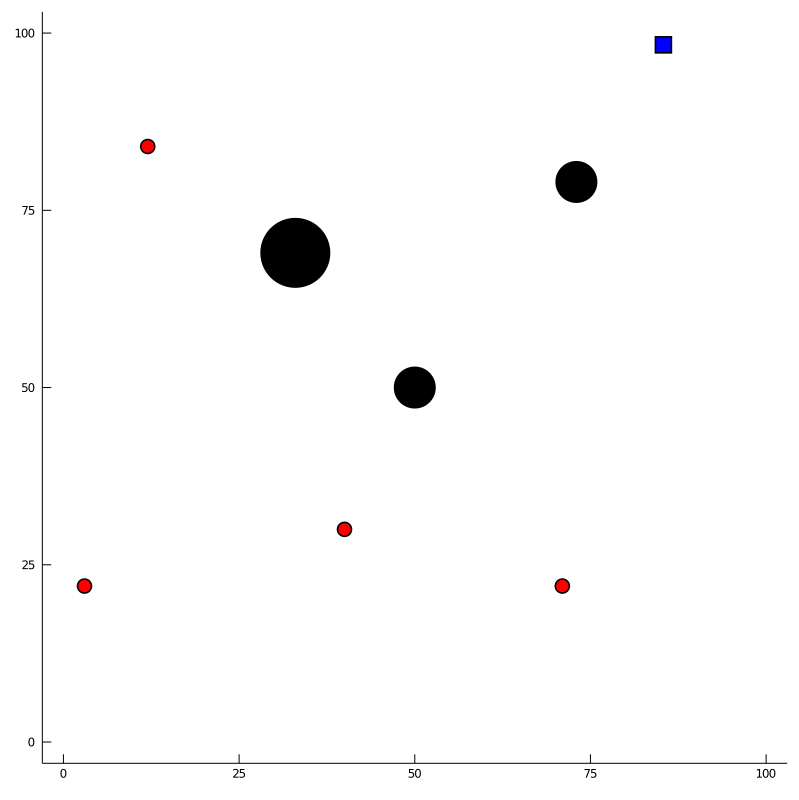

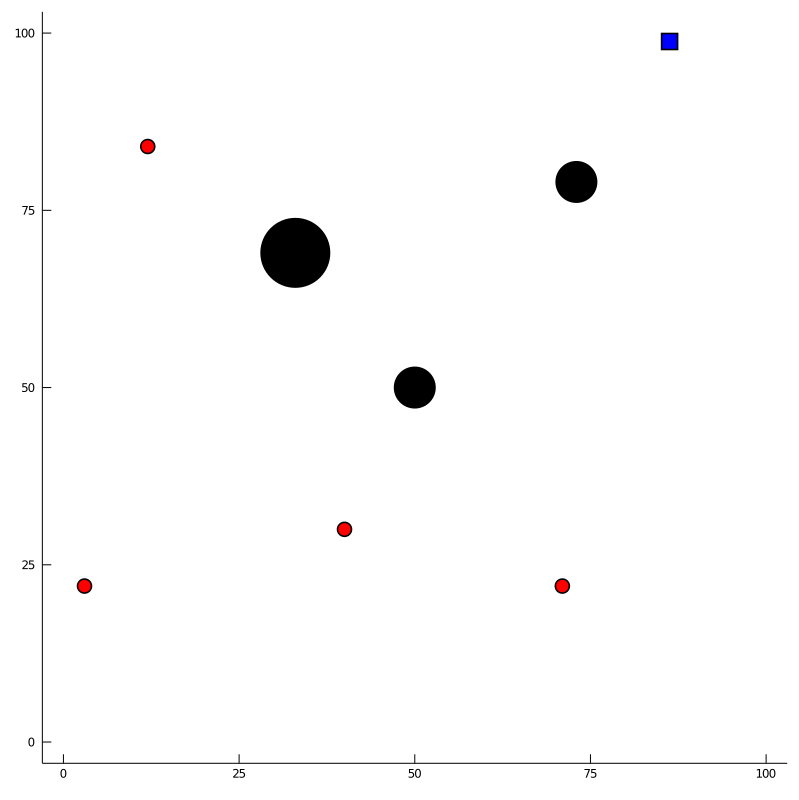

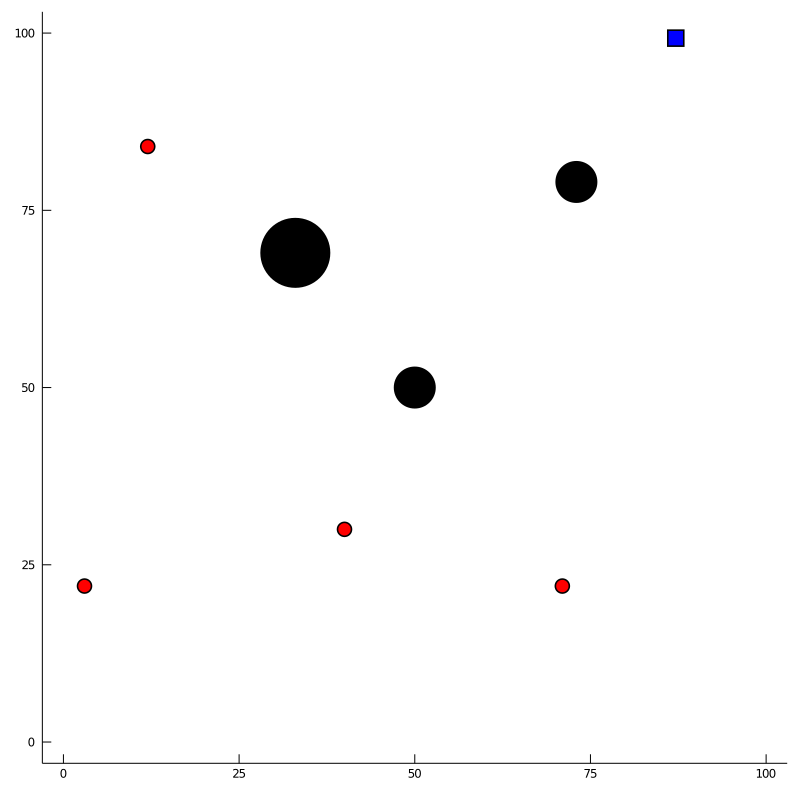

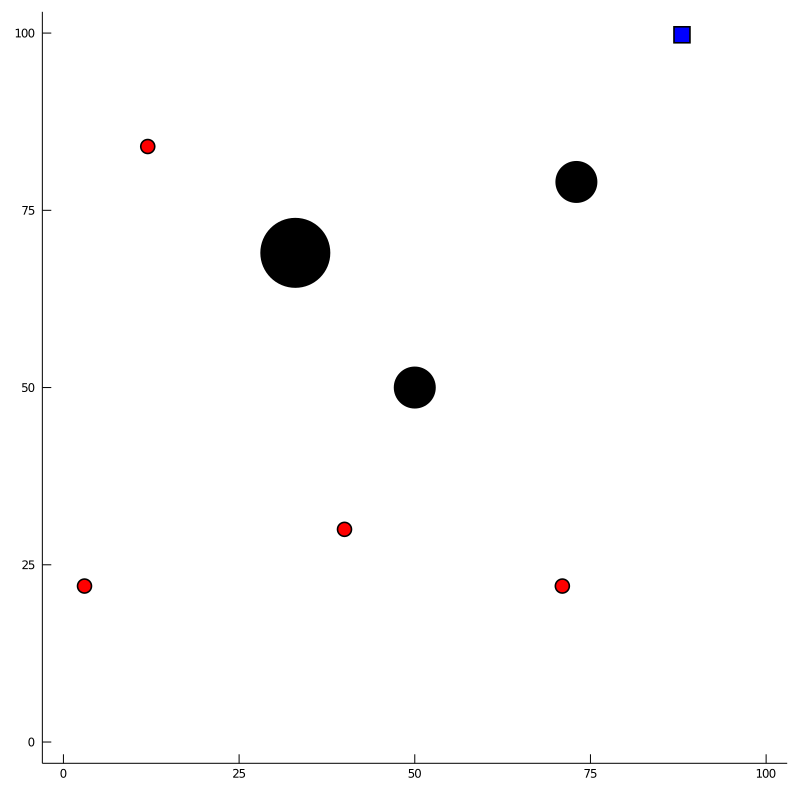

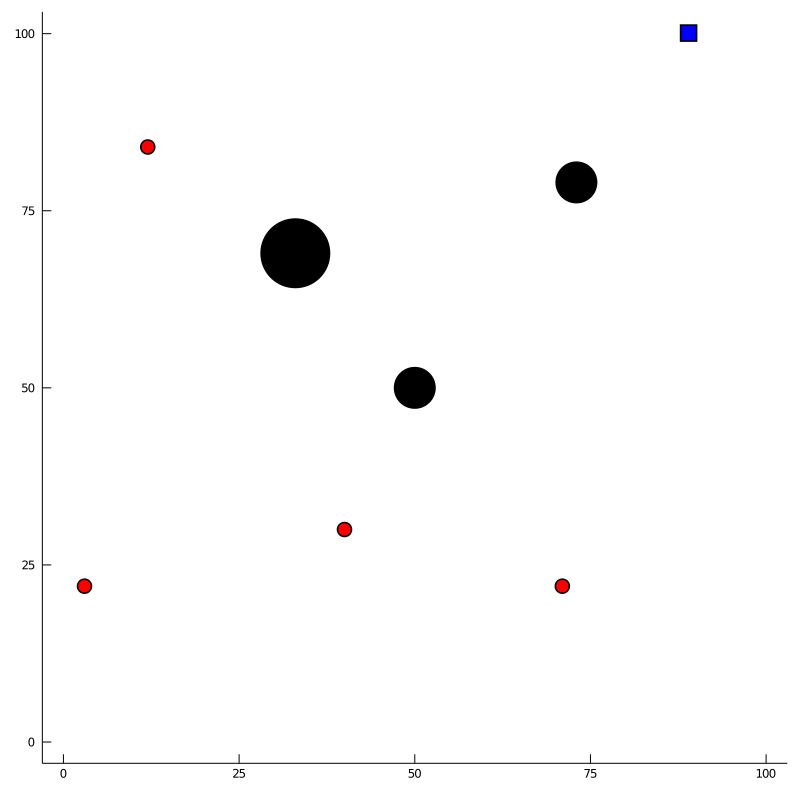

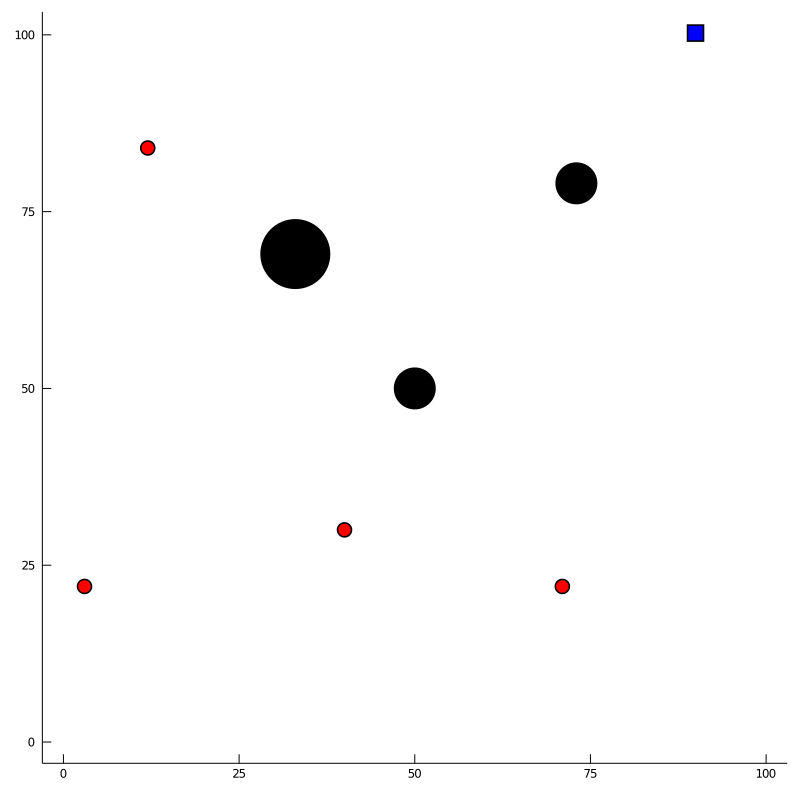

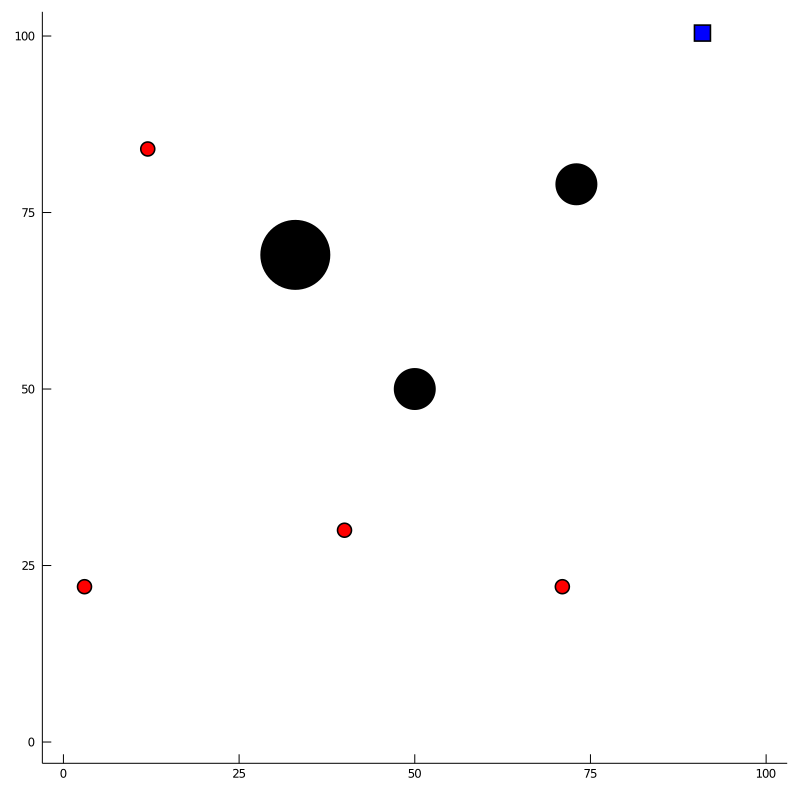

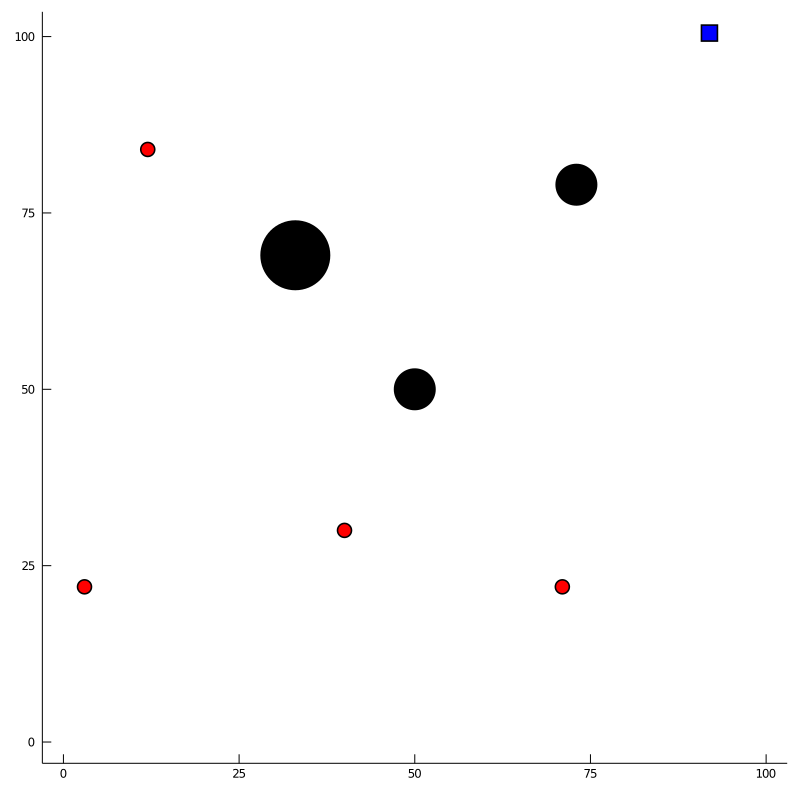

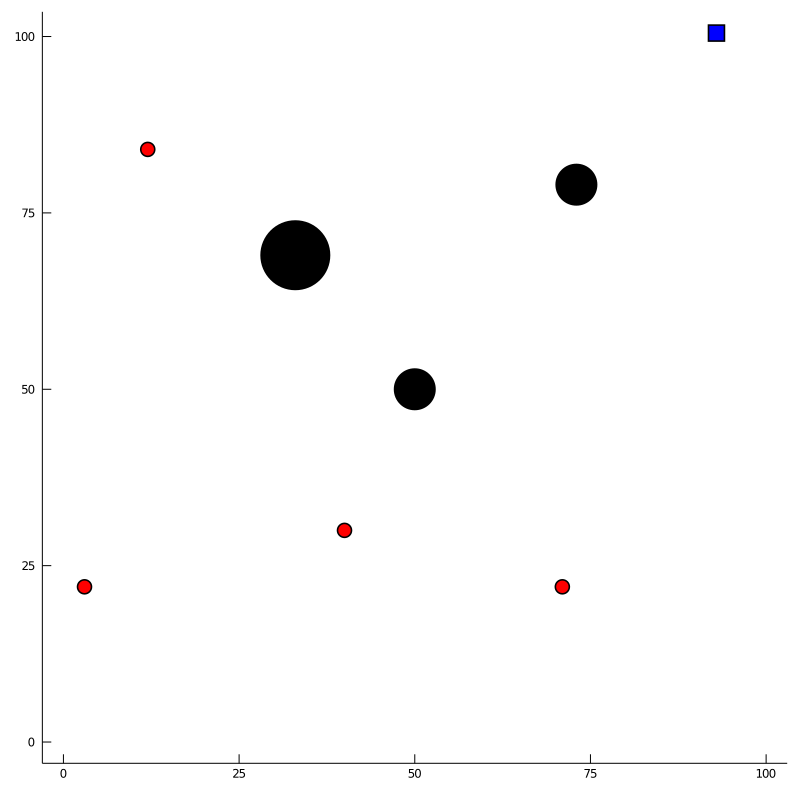

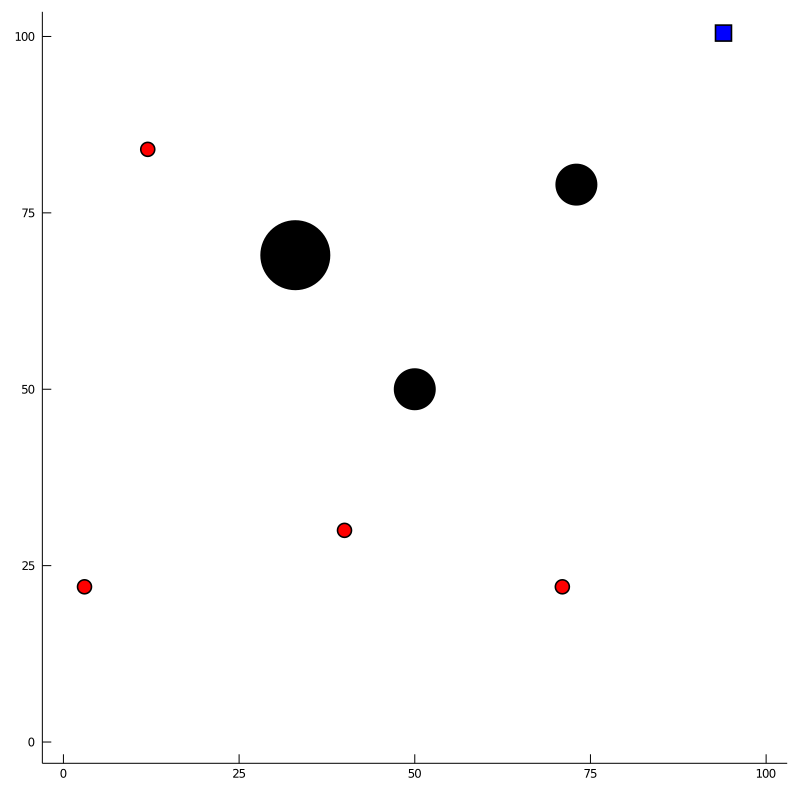

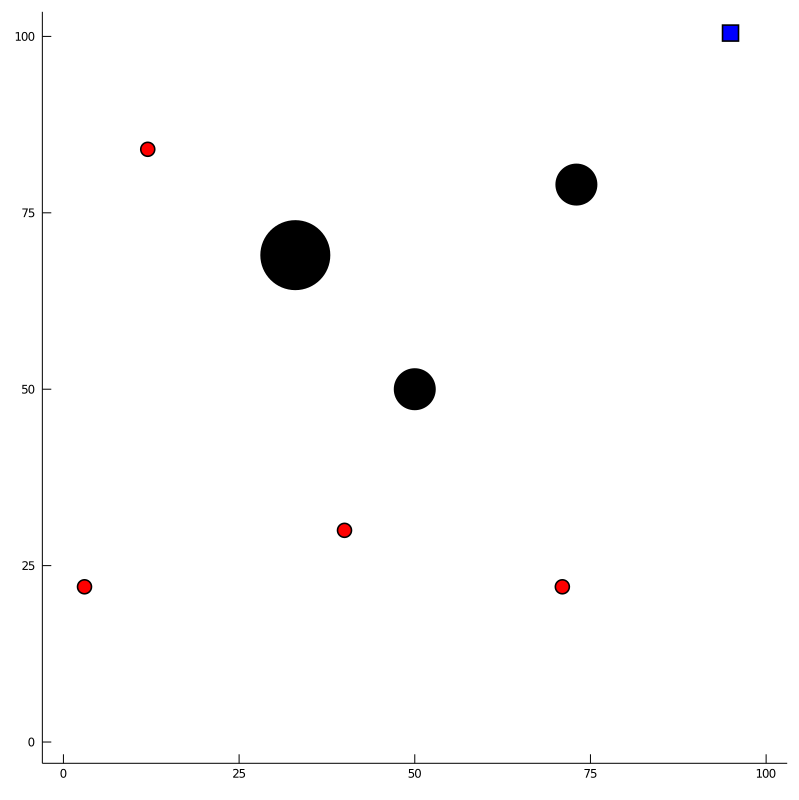

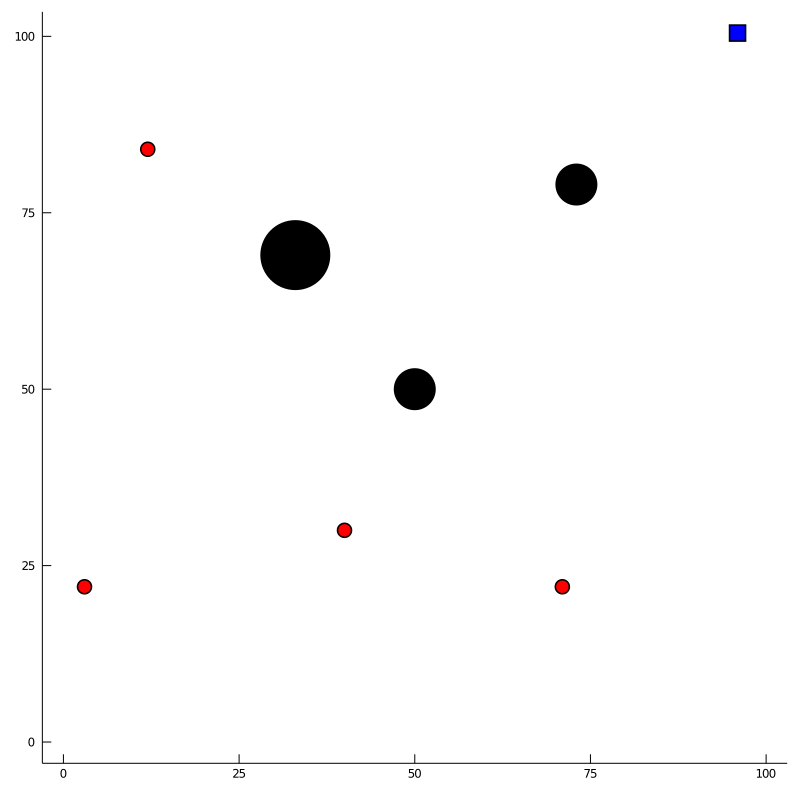

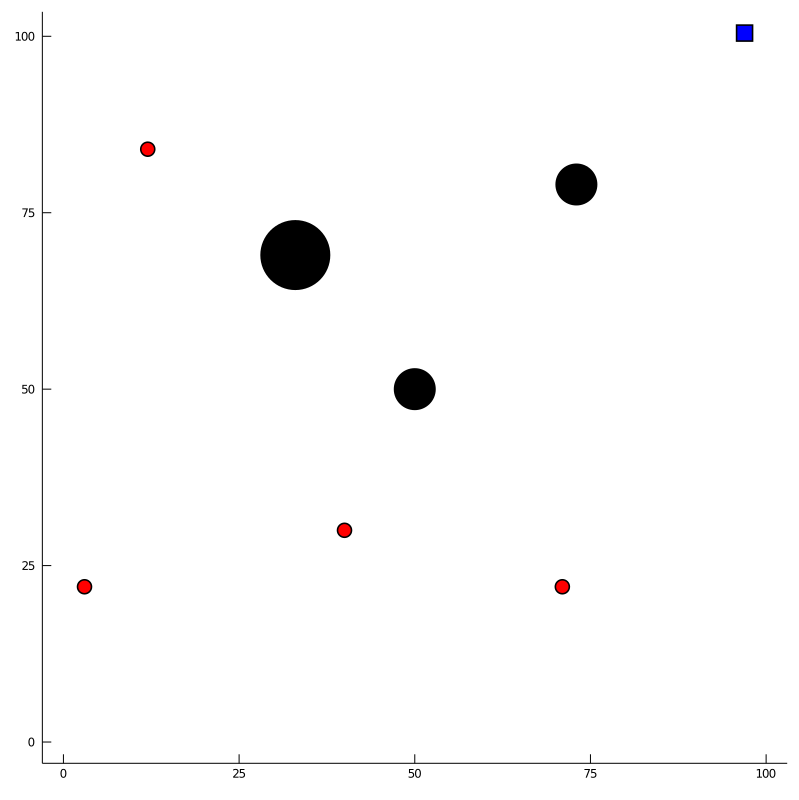

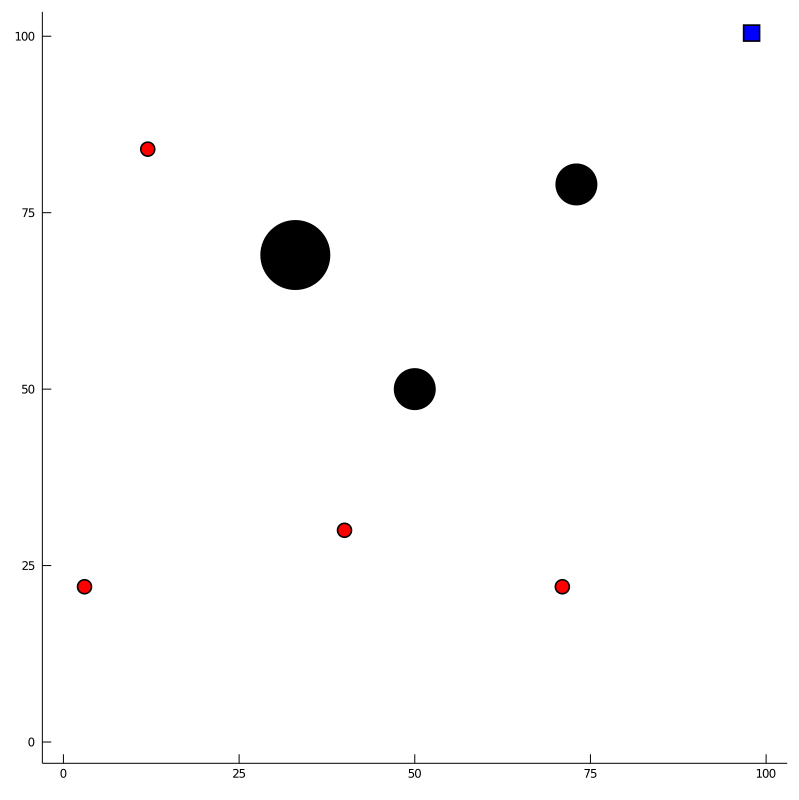

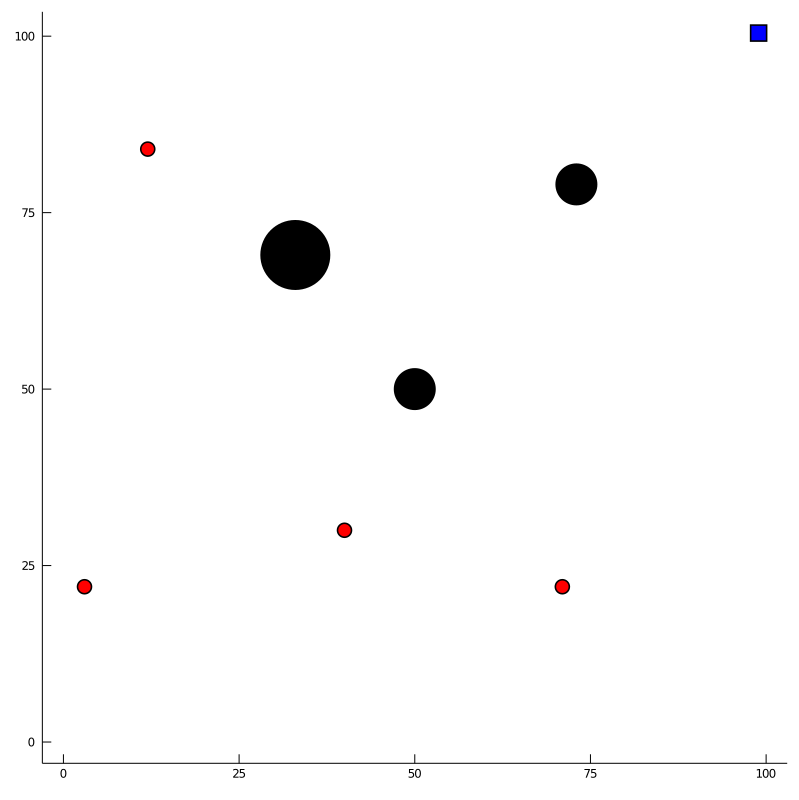

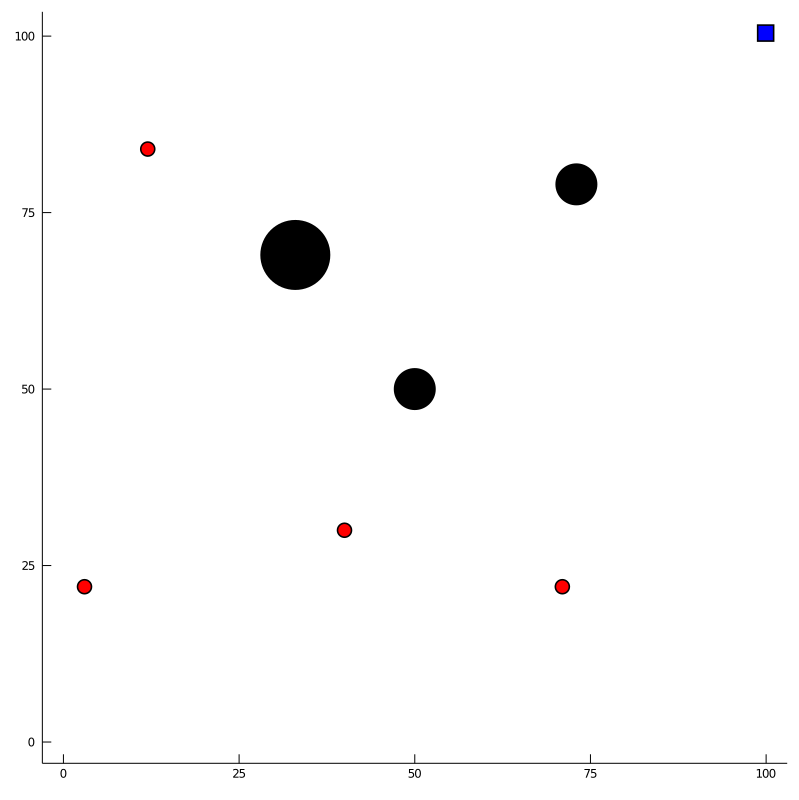

┌ Info: Saved animation to 
│   fn = /home/himanshu/Documents/Padhai/Research_Projects/human_aware_navigation/Speed_Planner/pomdp_planner.gif
└ @ Plots /home/himanshu/.julia/packages/Plots/u8HRI/src/animation.jl:104


Plots.AnimatedGif("/home/himanshu/Documents/Padhai/Research_Projects/human_aware_navigation/Speed_Planner/pomdp_planner.gif")
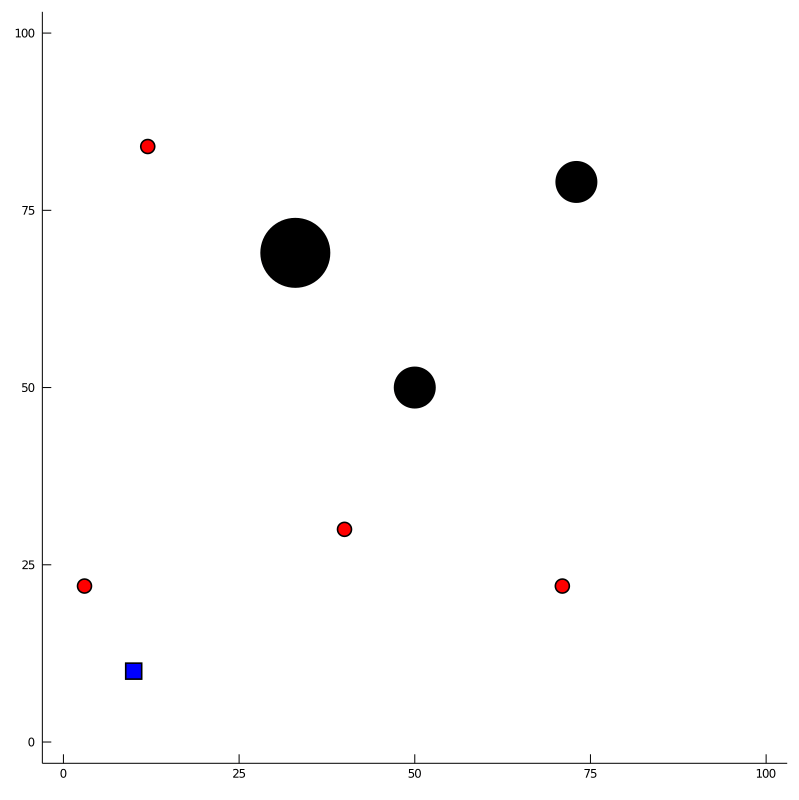

In [15]:
anim = @animate for i ∈ 1:length(path_x)
    env.cart.x = path_x[i]
    env.cart.y = path_y[i]
    display(env);
end
gif(anim, "pomdp_planner.gif", fps = 100)

In [ ]:
function has_human_reached_goal(env,i)
    distance::Float64 = ((env.humans[i].x - env.humans[i].goal.x)^2 + (env.humans[i].y - env.humans[i].goal.y)^2 )^0.5 
    if(distance<1.0)
        return true
    else
        return false
    end
end

function move_human_one_step(env,time_step,i)
    #First Quadrant
    if(env.humans[i].goal.x >= env.humans[i].x && (env.humans[i].goal.y >= env.humans[i].y))
        if(env.humans[i].goal.x == env.humans[i].x)
            env.humans[i].y += (env.humans[i].v)*time_step
            return
        elseif(env.humans[i].goal.y == env.humans[i].y)
            env.humans[i].x += (env.humans[i].v)*time_step
            return
        else
            heading_angle = atan((env.humans[i].goal.y - env.humans[i].y) / (env.humans[i].goal.x - env.humans[i].x))
            env.humans[i].x += (env.humans[i].v)*time_step*cos(heading_angle)
            env.humans[i].y += (env.humans[i].v)*time_step*sin(heading_angle)
            return
        end
    #Second Quadrant
    elseif(env.humans[i].goal.x <= env.humans[i].x && (env.humans[i].goal.y >= env.humans[i].y))
        if(env.humans[i].goal.x == env.humans[i].x)
            env.humans[i].y += (env.humans[i].v)*time_step
            return
        elseif(env.humans[i].goal.y == env.humans[i].y)
            env.humans[i].x -= (env.humans[i].v)*time_step
            return
        else
            heading_angle = atan((env.humans[i].goal.y - env.humans[i].y) / (env.humans[i].goal.x - env.humans[i].x))
            env.humans[i].x -= (env.humans[i].v)*time_step*cos(heading_angle)
            env.humans[i].y -= (env.humans[i].v)*time_step*sin(heading_angle)
            return
        end
    #Third Quadrant
    elseif(env.humans[i].goal.x <= env.humans[i].x && (env.humans[i].goal.y <= env.humans[i].y))
        if(env.humans[i].goal.x == env.humans[i].x)
            env.humans[i].y -= (env.humans[i].v)*time_step
            return
        elseif(env.humans[i].goal.y == env.humans[i].y)
            env.humans[i].x -= (env.humans[i].v)*time_step
            return
        else
            heading_angle = ((env.humans[i].goal.y - env.humans[i].y) / (env.humans[i].goal.x - env.humans[i].x))
            env.humans[i].x -= (env.humans[i].v)*time_step*cos(heading_angle)
            env.humans[i].y -= (env.humans[i].v)*time_step*sin(heading_angle)
            return
        end
    #Fourth Quadrant
        else(env.humans[i].goal.x >= env.humans[i].x && (env.humans[i].goal.y <= env.humans[i].y))
        if(env.humans[i].goal.x == env.humans[i].x)
            env.humans[i].y -= (env.humans[i].v)*time_step
            return
        elseif(env.humans[i].goal.y == env.humans[i].y)
            env.humans[i].x += (env.humans[i].v)*time_step
            return
        else
            heading_angle = ((env.humans[i].goal.y - env.humans[i].y) / (env.humans[i].goal.x - env.humans[i].x))
            env.humans[i].x += (env.humans[i].v)*time_step*cos(heading_angle)
            env.humans[i].y += (env.humans[i].v)*time_step*sin(heading_angle)
            return
        end
    end
end

In [24]:
# g1 = location(0,0,1)
# g2 = location(0,100,2)
# g3 = location(0,30,3)
# g4 = location(14,1,4)
# cart_goal = location(100,50,5)
# all_goals_list = [g1,g2,g3,g4]

# h1 = human_state(40,30,1,g3)
# h2 = human_state(3,22,1,g4)
# h3 = human_state(71,22,1,g2)
# h4 = human_state(12,84,1,g1)
# human_state_start_list = [h1,h2,h3,h4]

# o1 = obstacle_location(50,50,3)
# o2 = obstacle_location(33,69,5)
# o3 = obstacle_location(73,79,3)
# all_obstacle_list = [o1,o2,o3]

# golfcart = cart_state(0,50,0,1,1,cart_goal)

# env = experiment_environment(100.0,100.0,4,all_goals_list,human_state_start_list,all_obstacle_list,golfcart)
# stop_flag = has_human_reached_goal(env,1) && has_human_reached_goal(env,2) && has_human_reached_goal(env,3) && has_human_reached_goal(env,4)

# anim = @animate for i in 1:length(path_x)

#     env.cart.x = path_x[i]
#     env.cart.y = path_y[i]
#     if(!has_human_reached_goal(env,1))
#         move_human_one_step(env,1,1)
#     end
#     if(!has_human_reached_goal(env,2))
#         move_human_one_step(env,1,2)
#     end
#     if(!has_human_reached_goal(env,3))
#         move_human_one_step(env,1,3)
#     end
#     if(!has_human_reached_goal(env,4))
#         move_human_one_step(env,1,4)
#     end
#     display(env);
#     stop_flag = has_human_reached_goal(env,1) && has_human_reached_goal(env,2) && has_human_reached_goal(env,3) && has_human_reached_goal(env,4)
# end
# gif(anim, "path_with_pedestrian_simulation.gif", fps = 10)


In [20]:
# struct pomdp_pedestrian_state
#     x:: Int64
#     y:: Int64
#     goal:: location
# end    

struct cart_observations
    observed_pedestrian_positions:: Array{location}
end

struct SP_POMDP_state
    cart:: cart_state
    pedestrians:: Array{human_state}
    pedestrian_goals:: Array{location}
    path_covered_index:: Int64
end

struct human_intention
    distribution::Array{Float64}
end

#AZA
function isgoalstate(s, env)
    cart_x = s.cart.x
    cart_y = s.cart.y
    collision_flag = false
    
    if(env.cart.goal.x == cart_x && env.cart.goal.y == cart_y)
        return true
    end
    for human in s.pedestrians
        if(cart_x == human.x && cart_y == human.y)
            #display("Collision")
            return true
        end
    end
    return false
end

isgoalstate (generic function with 1 method)